In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from hagelslag.processing import EnhancedWatershed
from hagelslag.evaluation.ProbabilityMetrics import DistributedCRPS, DistributedROC, DistributedReliability, bootstrap
from hagelslag.evaluation import roc_curve, performance_diagram, attributes_diagram, ContingencyTable, ObjectEvaluator
from hagelslag.data import ModelOutput, HailForecastGrid
from hagelslag.util.make_proj_grids import read_arps_map_file, read_ncar_map_file, make_proj_grids
import os
from IPython.display import Image
from scipy.stats import percentileofscore, gamma, beta
import cPickle
from hagelslag.util.Config import Config
from glob import glob
from netCDF4 import Dataset, num2date
import re
from datetime import datetime, timedelta
from mpl_toolkits.basemap import Basemap
from hagelslag.processing.EnsembleProducts import EnsembleMemberProduct
from os.path import exists

## CAPS Ensemble Full Period Evaluation

In [8]:
# Load Evaluation data
eval_path = "/sharp/djgagne/neighbor_scores_ssef_unique_2015/"
period_file = "ssef_cqg_masked_diss_period_scores.csv"
hour_file = "ssef_cqg_closest_diss_hour_scores.csv"
forecast_dir = "/sharp/djgagne/track_forecasts_spring2015_cqg_closest_json/"
figure_path = "/sharp/djgagne/hail_dissertation_figures/"
valid_run_dates = pd.DatetimeIndex(sorted(os.listdir(forecast_dir)))
period_eval = pd.read_csv(eval_path + period_file, parse_dates=["Run_Date"], infer_datetime_format=True)
period_eval = period_eval.loc[period_eval["Run_Date"].isin(valid_run_dates)].reset_index(drop=True)
period_eval["ROC_Obj"] = [DistributedROC(input_str=r) for r in period_eval["ROC"]]
period_eval["Rel_Obj"] = [DistributedReliability(input_str=r) for r in period_eval["Reliability"]]
period_eval["Events"] = [e.contingency_tables["TP"][0] for e in period_eval["ROC_Obj"]]
period_eval["Nulls"] = [e.contingency_tables["FP"][0] for e in period_eval["ROC_Obj"]]
#hour_eval = pd.read_csv(eval_path + hour_file, parse_dates=["Run_Date"])
#hour_eval["ROC_Obj"] = [DistributedROC(input_str=r) for r in hour_eval["ROC"]]
#hour_eval["Rel_Obj"] = [DistributedReliability(input_str=r) for r in hour_eval["Reliability"]]
#hour_eval["Events"] = [e.contingency_tables["TP"][0] for e in hour_eval["ROC_Obj"]]
#hour_eval["Nulls"] = [e.contingency_tables["FP"][0] for e in hour_eval["ROC_Obj"]]

In [6]:
period_eval["ROC_Obj"]

0       Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
1       Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
2       Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
3       Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
4       Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
5       Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
6       Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
7       Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
8       Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
9       Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
10      Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
11      Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
12      Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
13      Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
14      Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
15      Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
16      Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
17      Obs_Th

['WRF_hailsz' 'WRF_cqgmax' 'Random-Forest-CV_dist' 'Random-Forest_dist'
 'Elastic-Net_dist' 'WRF_uh_max']
15
15
15
15
15
15


In [7]:
neighbor_radius = 28
smoothing_radius = 21
size_threshold = [50, 150, 40]
model_col = period_eval["Model_Name"]  + "_" + period_eval["Forecast_Variable"]
all_models = pd.unique(model_col)
print all_models
combined_stats = pd.DataFrame(index=all_models, 
                              columns=["ROC_total", "Rel_total", "ROC_set", "Rel_set", "ROC_boot", "Rel_boot"])
num_forecasts = 0
for model in all_models:
    idxs = (model_col == model) &\
           (period_eval["Smoothing_Radius"]==smoothing_radius) &\
           (period_eval["Size_Threshold"].isin(size_threshold)) &\
           (period_eval["Neighbor_Radius"]==neighbor_radius) & \
           (period_eval["Events"] > 0)
    nf = np.count_nonzero(idxs)
    if nf > num_forecasts:
        num_forecasts = nf
#booti = np.random.randint(0, num_forecasts, (1000, num_forecasts))
for model in all_models:
    idxs = (model_col == model) &\
           (period_eval["Smoothing_Radius"]==smoothing_radius) &\
           (period_eval["Size_Threshold"].isin(size_threshold)) &\
           (period_eval["Neighbor_Radius"]==neighbor_radius) & \
           (period_eval["Events"] > 0)
    combined_stats.loc[model, "ROC_total"] = period_eval.loc[idxs, "ROC_Obj"].sum()
    combined_stats.loc[model, "Rel_total"] = period_eval.loc[idxs, "Rel_Obj"].sum()
    combined_stats.loc[model, "ROC_set"] = period_eval.loc[idxs, "ROC_Obj"].values
    combined_stats.loc[model, "Rel_set"] = period_eval.loc[idxs, "Rel_Obj"].values
    #combined_stats.loc[model, "ROC_boot"] = bootstrap(period_eval.loc[idxs, "ROC_Obj"].values)
    #combined_stats.loc[model, "Rel_boot"] = bootstrap(period_eval.loc[idxs, "Rel_Obj"].values)
    #combined_stats.loc[model, "ROC_boot"] = combined_stats.loc[model, "ROC_set"][booti].sum(axis=1)
    #combined_stats.loc[model, "Rel_boot"] = combined_stats.loc[model, "Rel_set"][booti].sum(axis=1)

    print model, combined_stats.loc[model,"ROC_total"].max_csi(), combined_stats.loc[model, "Rel_total"].brier_skill_score()

['WRF_cqgmax' 'WRF_uh_max' 'Random-Forest-CV_dist' 'Elastic-Net_dist'
 'WRF_hailsz' 'Random-Forest_dist']
WRF_cqgmax 0.109111087088 0.0242343914655
WRF_uh_max 0.229206128158 0.163531842932
Random-Forest-CV_dist 0.221329501509 0.165815027753
Elastic-Net_dist 0.218772458808 0.160380669979
WRF_hailsz 0.133006055994 -0.00631255232794
Random-Forest_dist 0.202147287593 0.146562439807


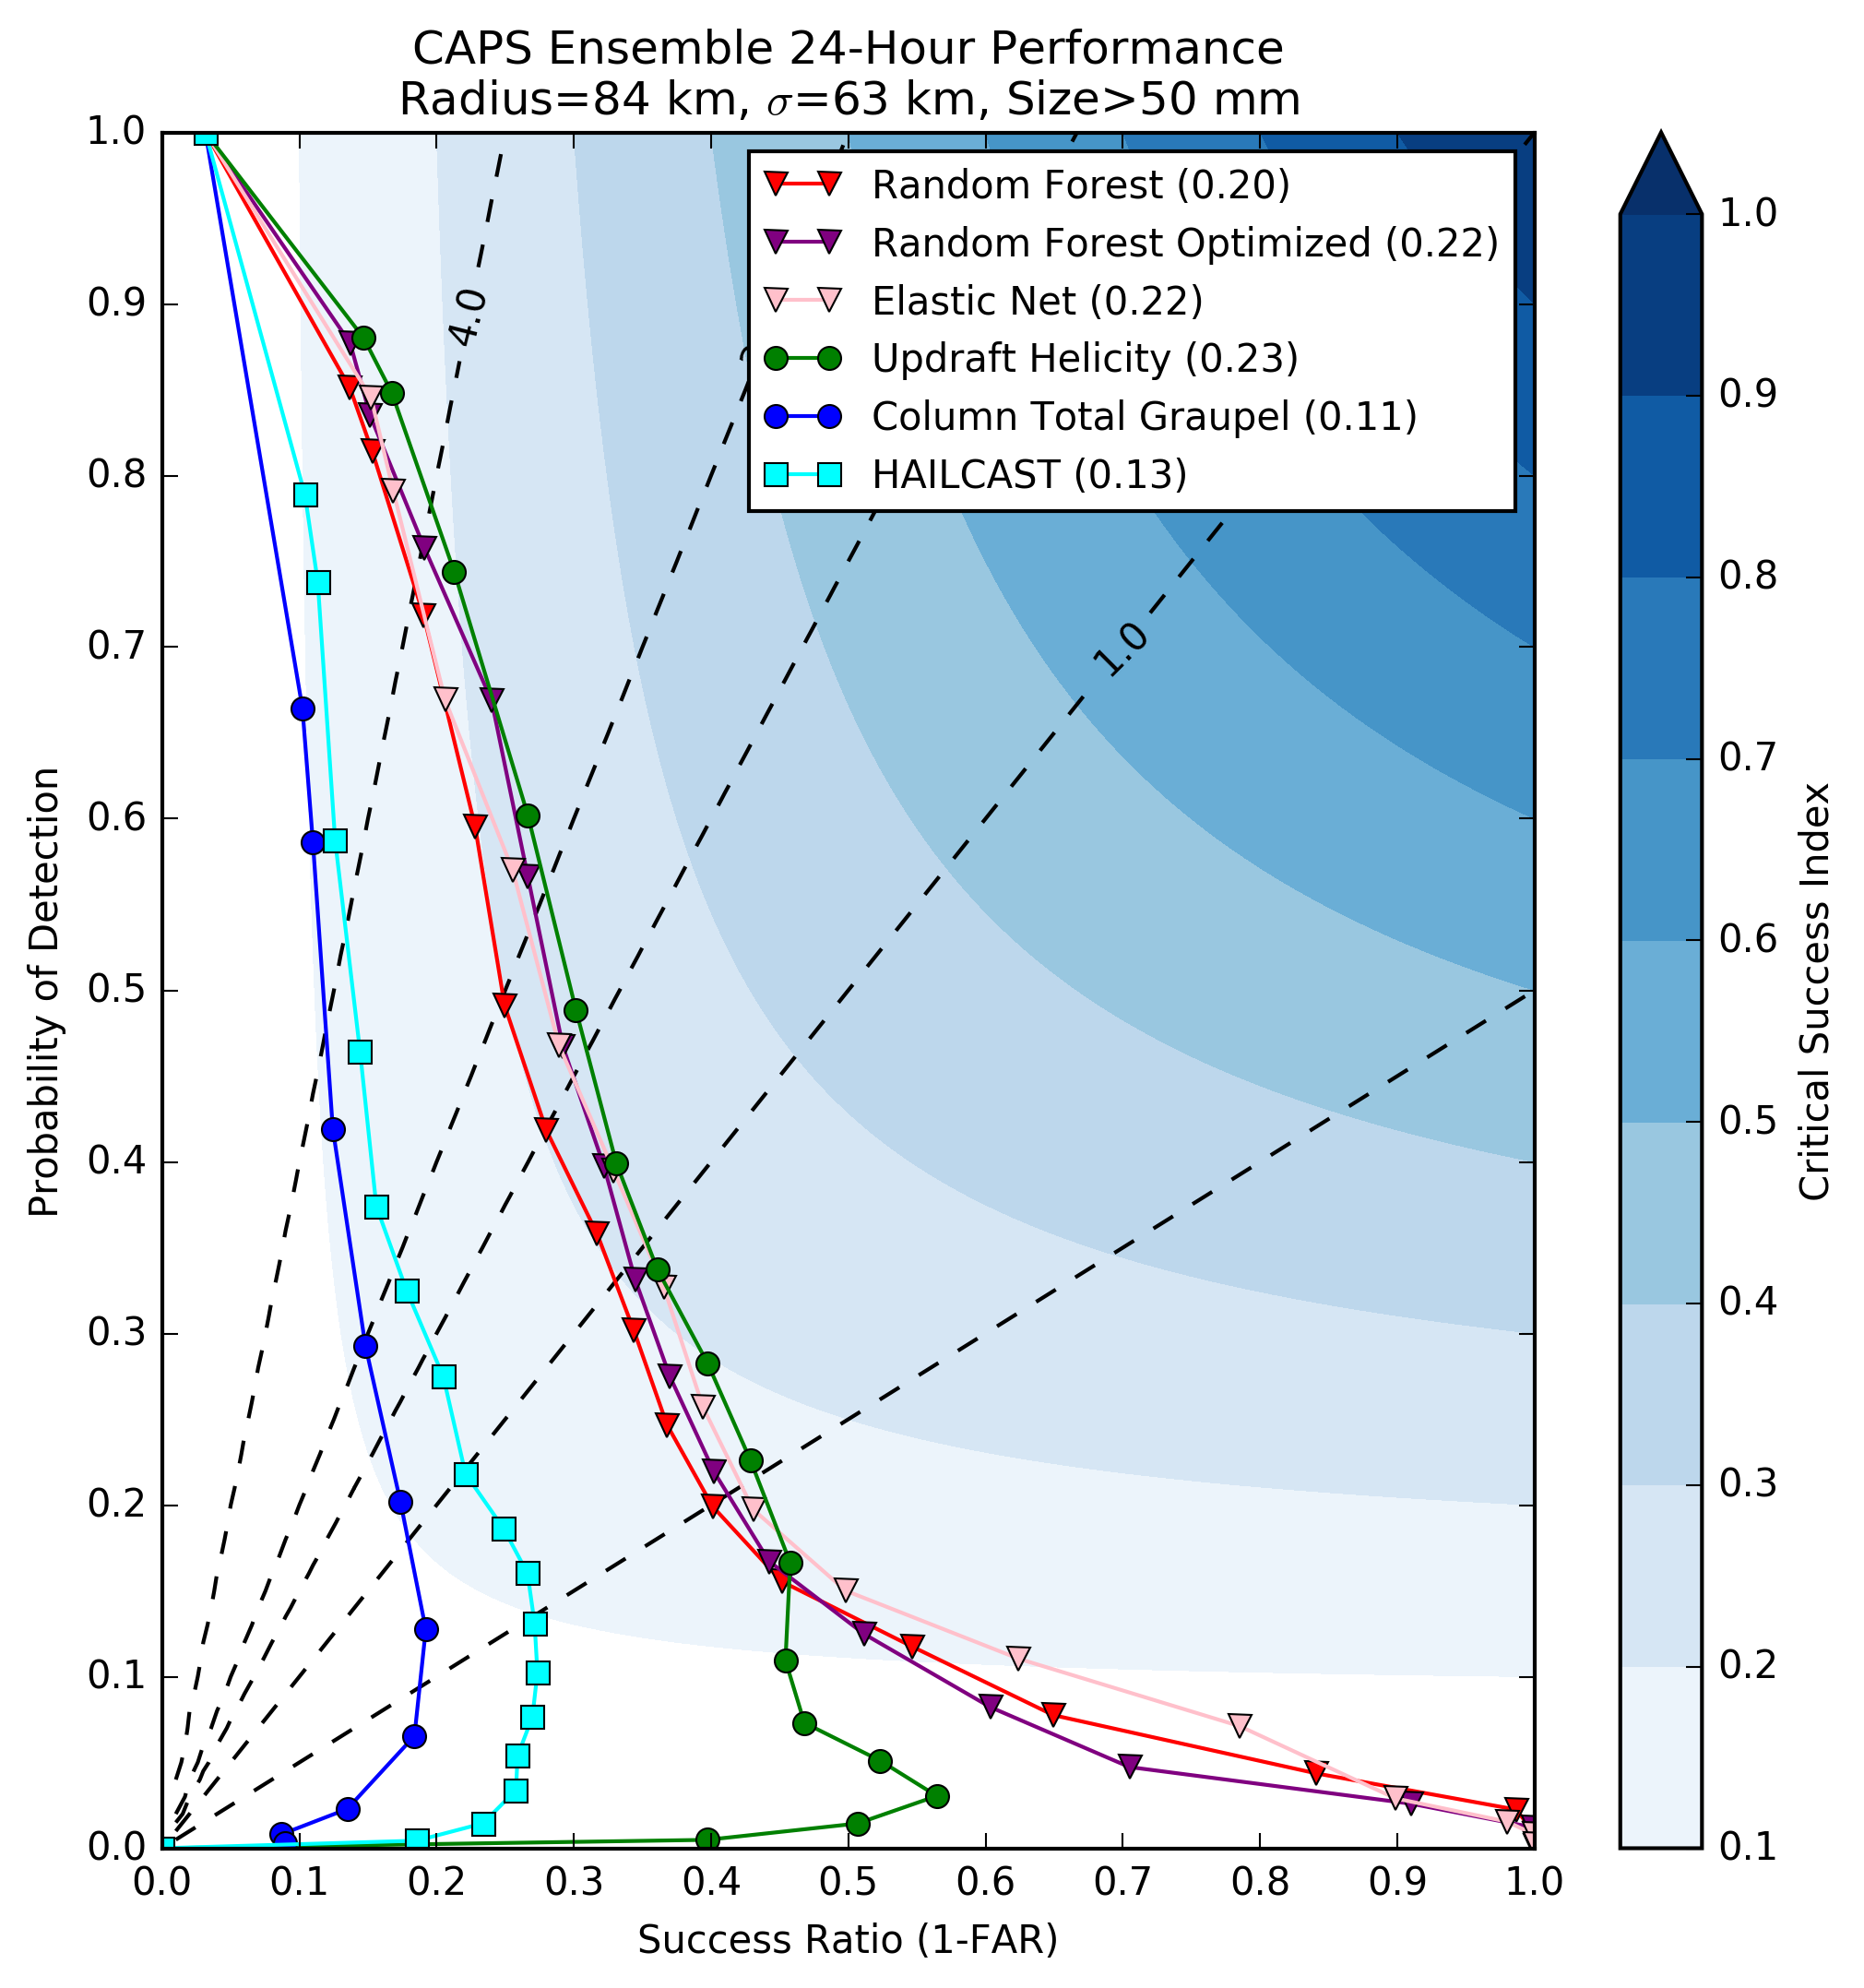

In [47]:
perf_filename = "/sharp/djgagne/hail_dissertation_figures/ssef_performance_full_period_2015_r_{0:d}_s_{1:d}_i_{2:d}.png".format(neighbor_radius,
                                                                                                                               smoothing_radius,
                                                                                                                               size_threshold[0])
model_order = ['Random-Forest_dist','Random-Forest-CV_dist', 'Elastic-Net_dist',
               'WRF_uh_max', 'WRF_cqgmax', 'WRF_hailsz']
model_names = ["Random Forest", "Random Forest Optimized", "Elastic Net", "Updraft Helicity", "Column Total Graupel", "HAILCAST"]
model_colors = ["red", "purple", "pink", "green", "blue", "cyan"]
markers = ["v"] * 3 + ['o'] * 2 + ['s'] * 1
perf_model_names = ["{0} ({1:0.2f})".format(model_names[m],
                                           combined_stats.loc[model_order, "ROC_total"].values[m].max_csi())
                   for m in range(len(model_names))]
performance_diagram(combined_stats.loc[model_order, "ROC_total"].values, perf_model_names, 
                    model_colors, markers, 
                    perf_filename,
                    title="CAPS Ensemble 24-Hour Performance\nRadius={0:d} km, $\sigma$={1:d} km, Size>{2:d} mm".format(neighbor_radius * 3, 
                                                                                                                    smoothing_radius * 3, 
                                                                                    size_threshold[0]), legend_params=dict(loc=0, fontsize=10))
                    #bootstrap_sets=combined_stats.loc[model_order, "ROC_boot"].values)
Image(perf_filename)

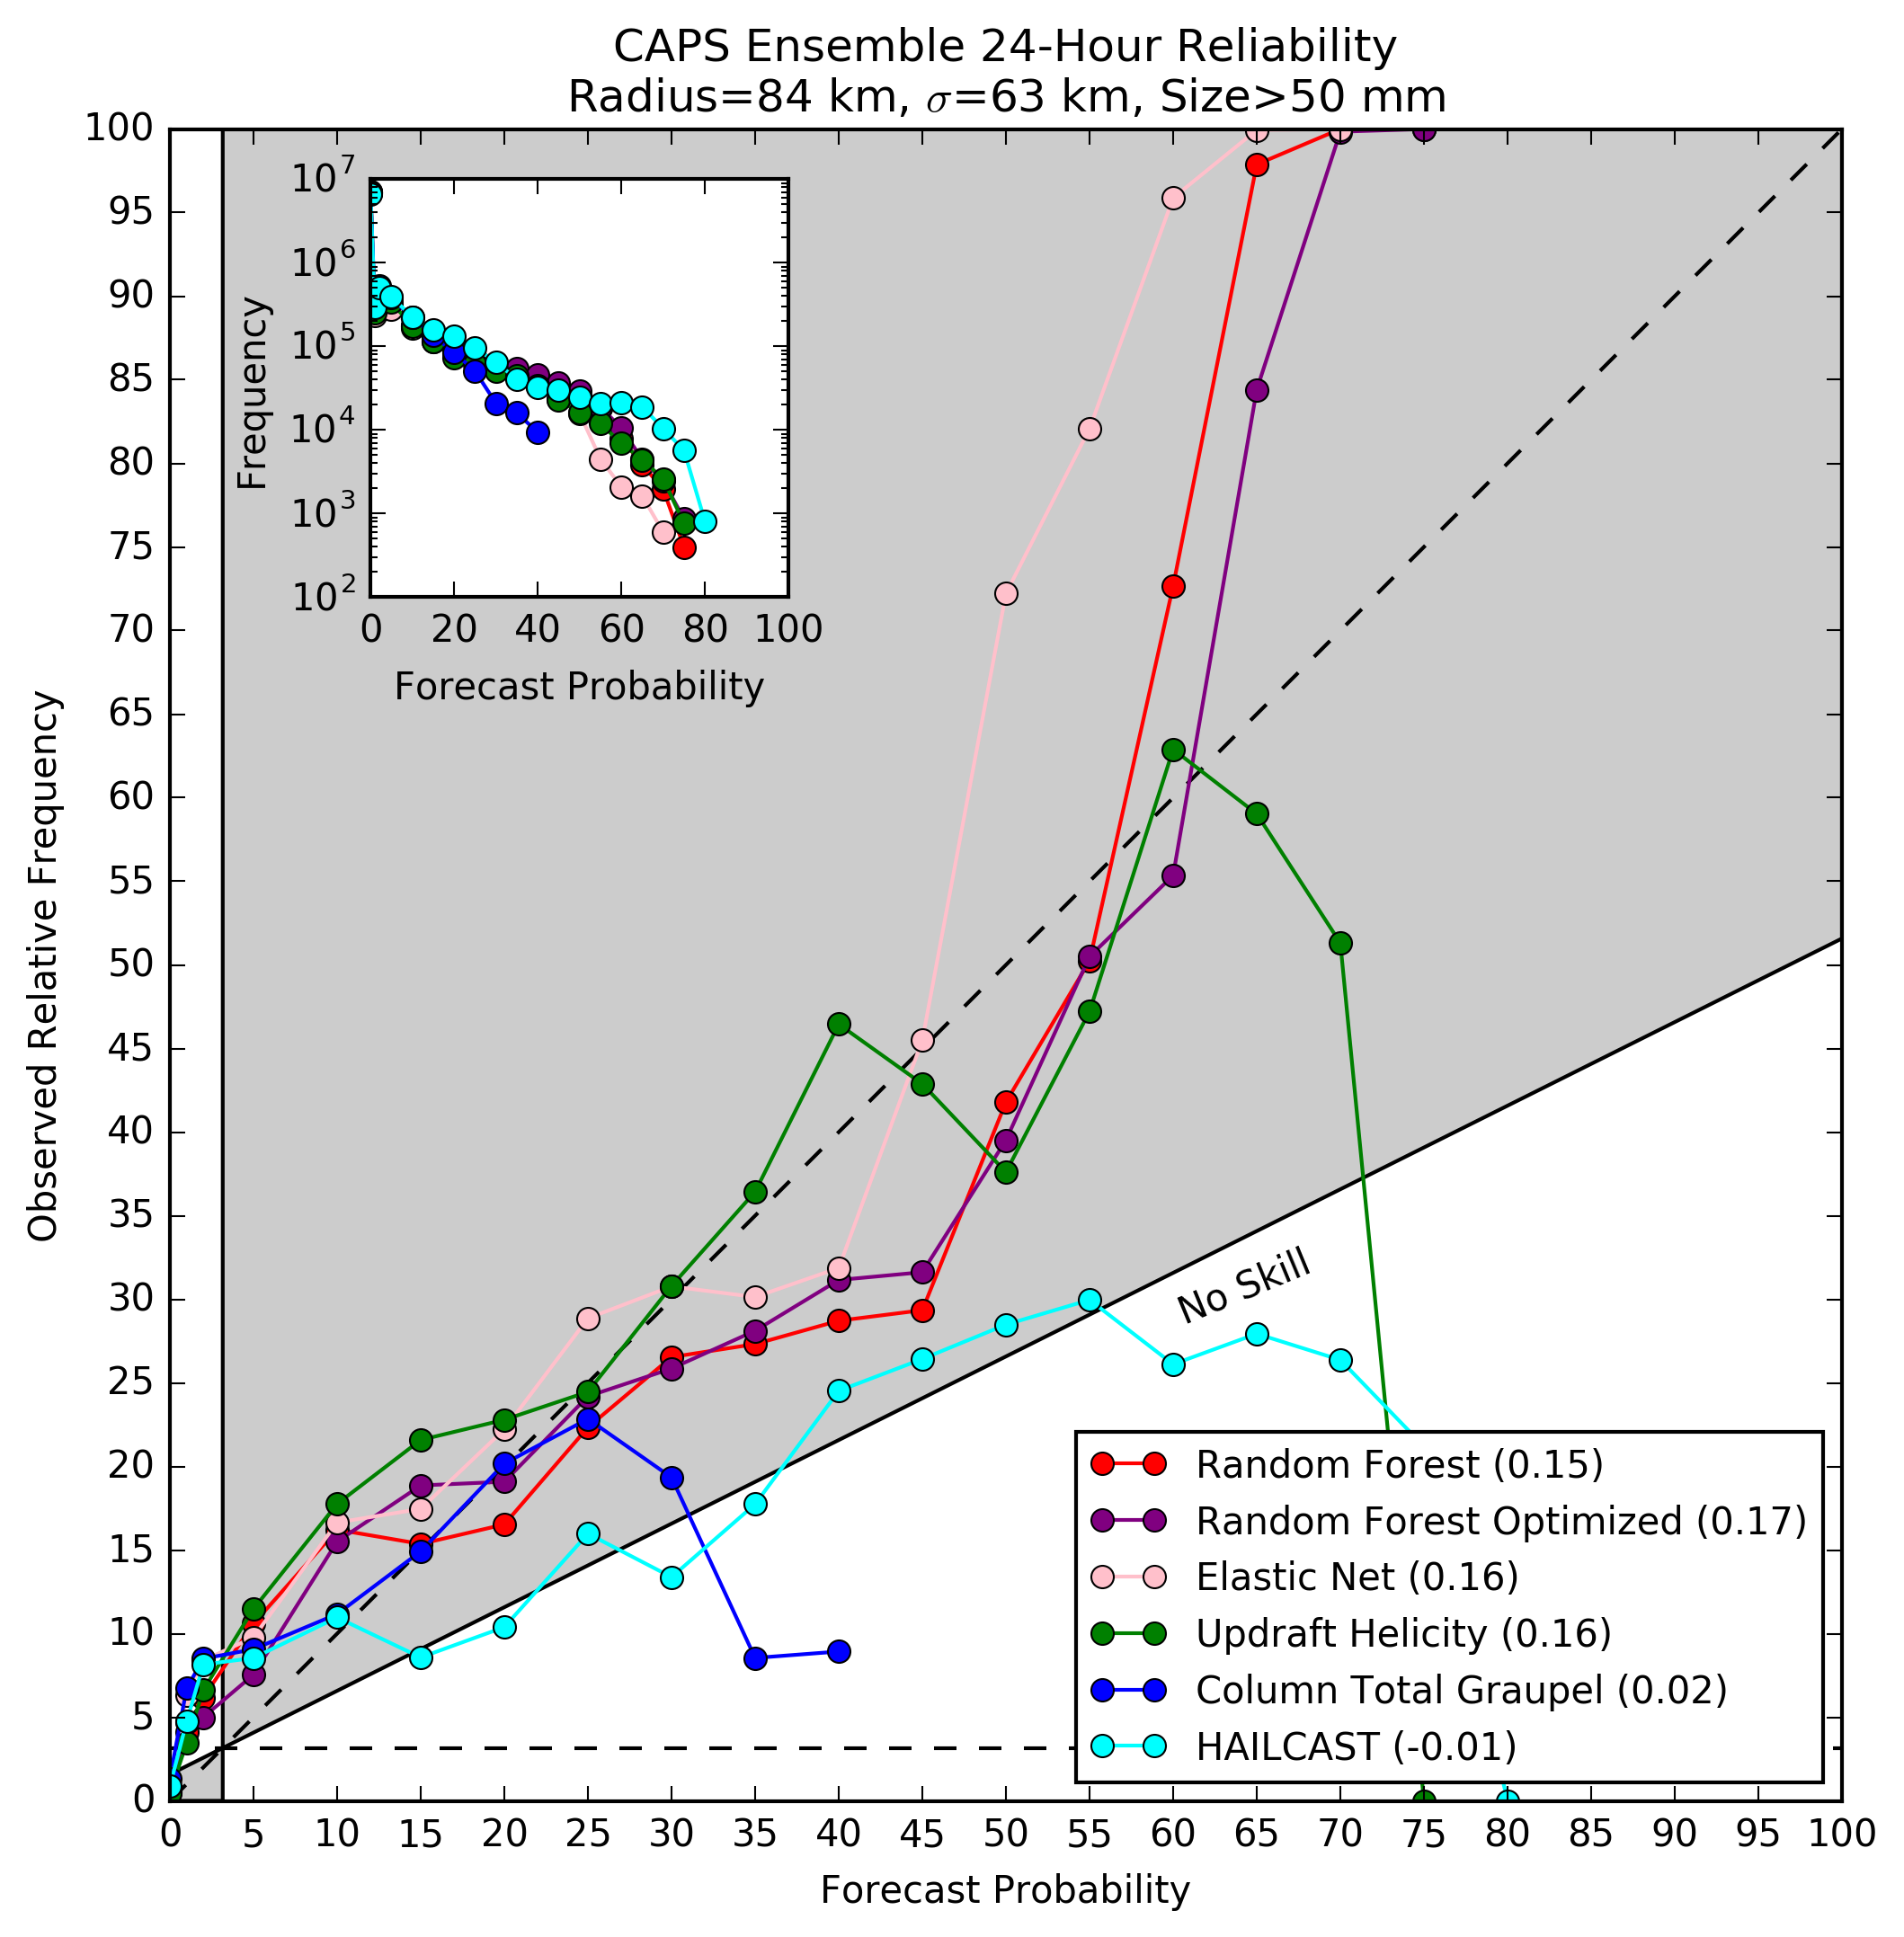

In [48]:
rel_filename = "/sharp/djgagne/hail_dissertation_figures/ssef_attributes_diagram_full_period_2015_r_{0:d}_s_{1:d}_i_{2:d}.png".format(neighbor_radius,
                                                                                                                               smoothing_radius,
                                                                                                                               size_threshold[0])
rel_model_names = ["{0} ({1:0.2f})".format(model_names[m],
                                           combined_stats.loc[model_order, "Rel_total"].values[m].brier_skill_score())
                   for m in range(len(model_names))]
attributes_diagram(combined_stats.loc[model_order, "Rel_total"].values, rel_model_names, 
                   model_colors, ["o"] * 6, 
                   rel_filename,
                   title="CAPS Ensemble 24-Hour Reliability\nRadius={0:d} km, $\sigma$={1:d} km, Size>{2:d} mm".format(neighbor_radius * 3, 
                                                                                                                    smoothing_radius * 3, 
                                                                                    size_threshold[0]))
                   #bootstrap_sets=combined_stats.loc[model_order,"Rel_boot"].values)
Image(rel_filename)

## Hour Evaluation

In [237]:
neighbor_radius = 28
smoothing_radius = 20
size_threshold = [50, 150, 40]
model_col = hour_eval["Model_Name"]  + "_" + hour_eval["Forecast_Variable"]
all_models = pd.unique(model_col)
print all_models
hour_combined_stats = pd.DataFrame(index=all_models, 
                                   columns=["ROC_total", "Rel_total", "ROC_set", "Rel_set", "ROC_boot", "Rel_boot"])
num_forecasts = 0
for model in all_models:
    idxs = (model_col == model) &\
           (hour_eval["Smoothing_Radius"]==smoothing_radius) &\
           (hour_eval["Size_Threshold"].isin(size_threshold)) &\
           (hour_eval["Neighbor_Radius"]==neighbor_radius) &\
           (hour_eval["Events"] > 0)
    nf = np.count_nonzero(idxs)
    if nf > num_forecasts:
        num_forecasts = nf
booti = np.random.randint(0, num_forecasts, (1000, num_forecasts))
for model in all_models:
    idxs = (model_col == model) &\
           (hour_eval["Smoothing_Radius"]==smoothing_radius) & \
           (hour_eval["Size_Threshold"].isin(size_threshold)) & \
           (hour_eval["Neighbor_Radius"]==neighbor_radius) & \
           (hour_eval["Events"] > 0)
    print np.count_nonzero(idxs)
    hour_combined_stats.loc[model, "ROC_total"] = hour_eval.loc[idxs, "ROC_Obj"].sum()
    hour_combined_stats.loc[model, "Rel_total"] = hour_eval.loc[idxs, "Rel_Obj"].sum()
    hour_combined_stats.loc[model, "ROC_set"] = hour_eval.loc[idxs, "ROC_Obj"].values
    hour_combined_stats.loc[model, "Rel_set"] = hour_eval.loc[idxs, "Rel_Obj"].values
    #combined_stats.loc[model, "ROC_boot"] = bootstrap(period_eval.loc[idxs, "ROC_Obj"].values)
    #combined_stats.loc[model, "Rel_boot"] = bootstrap(period_eval.loc[idxs, "Rel_Obj"].values)
    hour_combined_stats.loc[model, "ROC_boot"] = hour_combined_stats.loc[model, "ROC_set"][booti].sum(axis=1)
    hour_combined_stats.loc[model, "Rel_boot"] = hour_combined_stats.loc[model, "Rel_set"][booti].sum(axis=1)

    print model, hour_combined_stats.loc[model,"ROC_total"].max_csi(), hour_combined_stats.loc[model, "Rel_total"].brier_skill_score()

['WRF_uh_max' 'Elastic-Net_dist' 'WRF_hailsz' 'Random-Forest-CV_dist'
 'WRF_cqgmax' 'Random-Forest_dist']
116
WRF_uh_max 0.065885172403 0.0256428039347
116
Elastic-Net_dist 0.0884969145299 0.0468387113622
116
WRF_hailsz 0.045346223358 0.00251024848225
116
Random-Forest-CV_dist 0.0936722986248 0.0514646434712
116
WRF_cqgmax 0.0310949157591 0.00445992024434
116
Random-Forest_dist 0.0872453652058 0.0454714492081


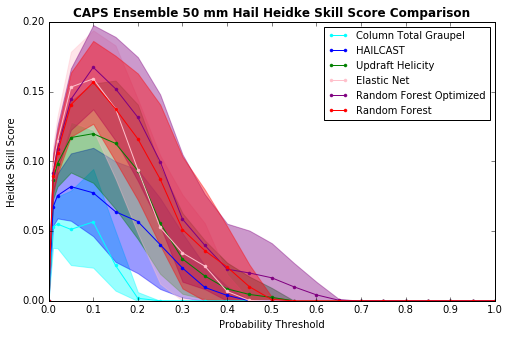

In [240]:
plt.figure(figsize=(8,5))
csi_func = np.frompyfunc(ContingencyTable.hss, 1, 1)
for m, model in enumerate(model_order):
    cts = np.array([ContingencyTable(*ct) for ct in hour_combined_stats.loc[model, "ROC_total"].contingency_tables.values])
    ct_boot = np.array([[ContingencyTable(*ct) for ct in ctb.contingency_tables.values] 
                        for ctb in hour_combined_stats.loc[model, "ROC_boot"]])
    ets_boot = csi_func(ct_boot)
    ets_bounds = np.percentile(ets_boot,[2.5, 97.5], axis=0).astype(float)
    ets = csi_func(cts).astype(float)
    plt.fill_between(hour_combined_stats.loc[model, "ROC_total"].thresholds, ets_bounds[1], ets_bounds[0], color=model_colors[m], alpha=0.4)
    plt.plot(hour_combined_stats.loc[model, "ROC_total"].thresholds, ets, label=model_names[m], color=model_colors[m], marker='.')
    
plt.legend(loc=0, fontsize=10)
plt.xlim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 0.2)
plt.xlabel("Probability Threshold")
plt.ylabel("Heidke Skill Score")
plt.title("CAPS Ensemble 50 mm Hail Heidke Skill Score Comparison", fontweight="bold")

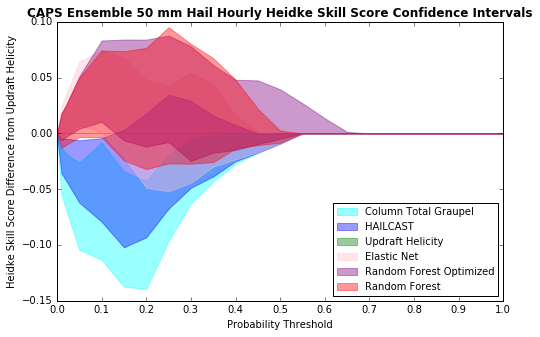

In [238]:
plt.figure(figsize=(8,5))
score_func = np.frompyfunc(ContingencyTable.hss, 1, 1)
baseline_boot = np.array([[ContingencyTable(*ct) for ct in ctb.contingency_tables.values] 
                          for ctb in hour_combined_stats.loc["WRF_uh_max", "ROC_boot"]])
baseline_score = score_func(baseline_boot).astype(float)
for m, model in enumerate(model_order):
    #cts = np.array([ContingencyTable(*ct) for ct in combined_stats.loc[model, "ROC_total"].contingency_tables.values])
    ct_boot = np.array([[ContingencyTable(*ct) for ct in ctb.contingency_tables.values] 
                        for ctb in hour_combined_stats.loc[model, "ROC_boot"]])
    score_boot = score_func(ct_boot) - baseline_score
    score_bounds = np.percentile(score_boot,[2.5, 97.5], axis=0).astype(float)
    #mean_score = score_func(cts).astype(float)
    plt.fill_between(hour_combined_stats.loc[model, "ROC_total"].thresholds, score_bounds[1], score_bounds[0], 
                     color=model_colors[m], alpha=0.4, label=model_names[m])
    #plt.plot(combined_stats.loc[model, "ROC_total"].thresholds, mean_score, label=model_names[m], 
    #         color=model_colors[m], marker='.')
    
plt.legend(loc="lower right", fontsize=10)
plt.xlim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Heidke Skill Score Difference from Updraft Helicity")
plt.xlabel("Probability Threshold")
plt.title("CAPS Ensemble 50 mm Hail Hourly Heidke Skill Score Confidence Intervals", fontweight="bold")

In [165]:
combined_stats["Rel_boot"][0][0].reliability_curve().shape

(23, 5)

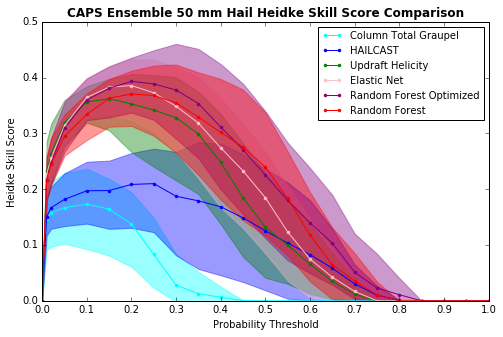

In [229]:
plt.figure(figsize=(8,5))
csi_func = np.frompyfunc(ContingencyTable.hss, 1, 1)
for m, model in enumerate(model_order):
    cts = np.array([ContingencyTable(*ct) for ct in combined_stats.loc[model, "ROC_total"].contingency_tables.values])
    ct_boot = np.array([[ContingencyTable(*ct) for ct in ctb.contingency_tables.values] for ctb in combined_stats.loc[model, "ROC_boot"]])
    ets_boot = csi_func(ct_boot)
    ets_bounds = np.percentile(ets_boot,[2.5, 97.5], axis=0).astype(float)
    ets = csi_func(cts).astype(float)
    plt.fill_between(combined_stats.loc[model, "ROC_total"].thresholds, ets_bounds[1], ets_bounds[0], color=model_colors[m], alpha=0.4)
    plt.plot(combined_stats.loc[model, "ROC_total"].thresholds, ets, label=model_names[m], color=model_colors[m], marker='.')
    
plt.legend(loc=0, fontsize=10)
plt.xlim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 0.5)
plt.xlabel("Probability Threshold")
plt.ylabel("Heidke Skill Score")
plt.title("CAPS Ensemble 50 mm Hail Heidke Skill Score Comparison", fontweight="bold")

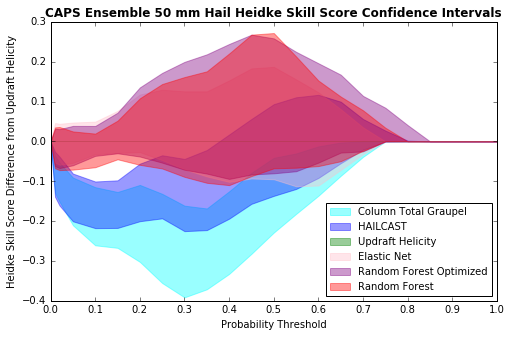

In [219]:
plt.figure(figsize=(8,5))
score_func = np.frompyfunc(ContingencyTable.hss, 1, 1)
baseline_boot = np.array([[ContingencyTable(*ct) for ct in ctb.contingency_tables.values] 
                          for ctb in combined_stats.loc["WRF_uh_max", "ROC_boot"]])
baseline_score = score_func(baseline_boot).astype(float)
for m, model in enumerate(model_order):
    #cts = np.array([ContingencyTable(*ct) for ct in combined_stats.loc[model, "ROC_total"].contingency_tables.values])
    ct_boot = np.array([[ContingencyTable(*ct) for ct in ctb.contingency_tables.values] 
                        for ctb in combined_stats.loc[model, "ROC_boot"]])
    score_boot = score_func(ct_boot) - baseline_score
    score_bounds = np.percentile(score_boot,[2.5, 97.5], axis=0).astype(float)
    #mean_score = score_func(cts).astype(float)
    plt.fill_between(combined_stats.loc[model, "ROC_total"].thresholds, score_bounds[1], score_bounds[0], 
                     color=model_colors[m], alpha=0.4, label=model_names[m])
    #plt.plot(combined_stats.loc[model, "ROC_total"].thresholds, mean_score, label=model_names[m], 
    #         color=model_colors[m], marker='.')
    
plt.legend(loc="lower right", fontsize=10)
plt.xlim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Heidke Skill Score Difference from Updraft Helicity")
plt.xlabel("Probability Threshold")
plt.title("CAPS Ensemble 50 mm Hail Heidke Skill Score Confidence Intervals", fontweight="bold")

In [127]:
csi_func = np.frompyfunc(ContingencyTable.csi, 1,1)
ContingencyTable.csi(ct_boot[0,0])

0.031761268203215877

In [116]:
pbs = bootstrap(combined_stats.loc["Random-Forest-CV_dist","ROC_set"])

In [4]:
def permutation_test(set_a, set_b, num_samples=1000, func="max_csi"):
    score = getattr(set_a.sum(),func)() - getattr(set_b.sum(),func)()
    diffs = np.zeros(num_samples)
    shuffled_set = np.concatenate((set_a, set_b))
    for i in range(num_samples):
        np.random.shuffle(shuffled_set)
        diffs[i] = getattr(shuffled_set[0:set_a.size].sum(),func)() - getattr(shuffled_set[set_a.size:].sum(),func)()
    return diffs, score

diffs, score = permutation_test(combined_stats.loc["Random-Forest-CV_dist", "Rel_set"], 
                     combined_stats.loc["SSEF_uh_max", "Rel_set"], func="brier_skill_score")
print percentileofscore(diffs, score)
print score

KeyError: 'the label [SSEF_uh_max] is not in the [index]'

In [240]:
auc_diffs, auc_score = permutation_test(combined_stats.loc["Random-Forest-CV_dist", "ROC_set"], 
                     combined_stats.loc["SSEF_uh_max", "ROC_set"], func="auc")
print percentileofscore(auc_diffs, auc_score)
print auc_score

96.2
0.0375675329919


In [118]:
np.percentile([b.auc() for b in bs], [5, 95])

array([ 0.89398718,  0.93716626])

In [193]:
d = np.vstack((np.arange(10)[::-1], np.arange(10))).T
print d
print d[np.arange(0,10), np.random.randint(0,2,10)]

[[9 0]
 [8 1]
 [7 2]
 [6 3]
 [5 4]
 [4 5]
 [3 6]
 [2 7]
 [1 8]
 [0 9]]
[9 8 2 6 4 4 6 2 8 9]


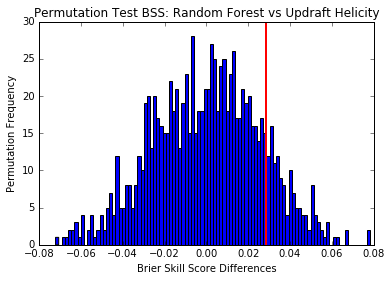

In [239]:
plt.figure(figsize=(6,4), dpi=300)
plt.hist(diffs,100)
plt.plot([score,score],[0,30],'r-',lw=2)
plt.xlabel("Brier Skill Score Differences")
plt.ylabel("Permutation Frequency")
plt.title("Permutation Test BSS: Random Forest vs Updraft Helicity")

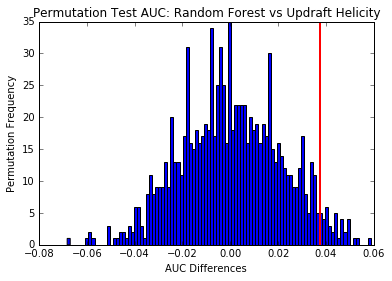

In [245]:
plt.figure(figsize=(6,4), dpi=300)
plt.hist(auc_diffs,100)
plt.plot([auc_score,auc_score],[0,35],'r-',lw=2)
plt.xlabel("AUC Differences")
plt.ylabel("Permutation Frequency")
plt.title("Permutation Test AUC: Random Forest vs Updraft Helicity")

In [234]:
rf_bss = np.array([r.brier_skill_score() for r in combined_stats.loc["Random-Forest-CV_dist","Rel_set"]])
uh_bss = np.array([r.brier_skill_score() for r in combined_stats.loc["SSEF_uh_max","Rel_set"]])
print rf_bss - uh_bss, np.count_nonzero((rf_bss - uh_bss) > 0), rf_bss.size, np.mean(rf_bss - uh_bss)

[-0.10502587 -0.00200295 -0.0573181   0.10627878  0.02043137 -0.02119697
  0.31092484  0.07504412  0.02379151 -0.03140158  0.1230066  -0.0567373
  0.09202382 -0.03329808 -0.01801112] 7 15 0.02843393842


## Variable Importances

In [13]:
storm_variables = ["uh_max", "r10cmx", "wupmax", "cqgmax", "wdnmax", "echotp", "accppt", "pwat",
                   "bku", "bkv"]
potential_variables = ["mlcape", "mlcins", "mucape", "mucins", "sblcl", "srh03", "shr06", "tmp500",
                       "tmp700", "dewp2m", "temp2m", "sph850", "sph700", "sph500", "lllr", "lr75",
                       "u10m", "v10m", "u700", "v700"]
shape_variables = ["area", "eccentricity", "major_axis_length", "minor_axis_length", "orientation",
                   "extent"]
tendency_variables = ["mucape", "dewp2m", "temp2m"]
variable_statistics = ["mean", "max", "min", "std", "skew",
                       "percentile_10", "percentile_50", "percentile_90"]
input_columns = ["Forecast_Hour", "Valid_Hour_UTC", "Duration_Step", "Duration_Total",
                 "Storm_Motion_U", "Storm_Motion_V"]
for var in storm_variables:
    for stat in variable_statistics:
        input_columns.append(var + "-storm_" + stat)
for var in potential_variables:
    for stat in variable_statistics:
        input_columns.append(var + "-potential_" + stat)
for var in tendency_variables:
    for stat in variable_statistics:
        input_columns.append(var + "-tendency_" + stat)
input_columns += shape_variables

In [14]:
long_storm_vars = ["Updraft Helicity", "Reflectivity -10C", "Updraft Speed", "Graupel Mass", "Downdraft Speed",
                   "Echo Top Height", "Precipitation", "Precipitable Water", "Bunkers U", "Bunkers V"]
long_potential_vars = ["MLCAPE", "MLCIN", "MUCAPE", "MUCIN", "LCL Height", "Storm-Relative Helicity (0-3 km)",
                      "Bulk Wind Difference (0-6 km)", "Temperature 500 mb", "Temperature 700 mb", "Dewpoint 2 m",
                      "Temperature 2 m", "Specific Humidity 850 mb", "Specific Humidity 700 mb", 
                       "Specific Humidity 500 mb", "Low-Level Lapse Rate", "Lapse Rate 700-500 mb", "U 10 m", "V 10 m",
                      "U 700 mb", "V 700 mb"]


In [15]:
def get_variable_importances(model_name, model_type, input_columns, path):
    model_files = sorted(glob(path + "*_{0}_*{1}.pkl".format(model_name.replace(" ","-"), model_type)))
    print model_files
    model_categories = []
    for model_file in model_files:
        category = model_file.split("/")[-1].split("_")[0]
        if category not in model_categories:
            model_categories.append(category)
    importances = pd.DataFrame(index=input_columns, columns=model_categories, dtype=float)
    for model_file in model_files:
        category = model_file.split("/")[-1].split("_")[0]
        model_out = open(model_file)
        model_obj = cPickle.load(model_out)
        model_out.close()
        if hasattr(model_obj, "feature_importances_"):
            importances[category] = model_obj.feature_importances_
        elif hasattr(model_obj, "best_estimator_"):
            if hasattr(model_obj.best_estimator_, "feature_importances_"):
                importances[category] = model_obj.best_estimator_.feature_importances_
    return importances
vi_model = "Random Forest"
vi_model_type = "condition"
rf_dist_importances = get_variable_importances(vi_model, vi_model_type, input_columns, 
                                                "/sharp/djgagne/track_models_spring2015_cqg_masked/")
importance_stat_matrices = {}
ordered_var_stats = ["min", "percentile_10", "mean", "percentile_50", 
                     "percentile_90", "max", "std", "skew"]
fancy_stat_labels = ["Min", "10th%", "Mean", "50th%", "90th%",
                    "Max", "SD", "Skew", "Total"]        
for col in rf_dist_importances:
    importance_stat_matrices[col] = pd.DataFrame(index=storm_variables + potential_variables, columns=ordered_var_stats)
    for var in importance_stat_matrices[col].index:
        vtype = "storm" if var in storm_variables else "potential"
        for stat in importance_stat_matrices[col].columns:
            
            importance_stat_matrices[col].loc[var, stat] = rf_dist_importances.loc[var + "-"+ vtype+"_" + stat, col]
    importance_stat_matrices[col]["Total"] = importance_stat_matrices[col].sum(axis=1)

['/sharp/djgagne/track_models_spring2015_cqg_masked/MY_Random-Forest_condition.pkl', '/sharp/djgagne/track_models_spring2015_cqg_masked/Morrison_Random-Forest_condition.pkl', '/sharp/djgagne/track_models_spring2015_cqg_masked/Thompson_Random-Forest_condition.pkl', '/sharp/djgagne/track_models_spring2015_cqg_masked/WDM6_Random-Forest_condition.pkl']


In [16]:
for col in rf_dist_importances:
    print col
    ranks = np.argsort(importance_stat_matrices[col]["Total"])
    fig, ax = plt.subplots(figsize=(7, 8), dpi=300)
    plt.subplots_adjust(top=0.93)
    plt.pcolor(np.log10(importance_stat_matrices[col].astype(float).values[ranks]), 
               cmap=plt.get_cmap("RdPu",30),vmin=-3, vmax=-1, edgecolors='k')
    cbar = plt.colorbar()
    cbar.set_label("$\log_{10}$(Variable Importance Score)")
    plt.yticks(np.arange(30) + 0.5, 
               np.array(long_storm_vars+long_potential_vars)[ranks])
    ax.xaxis.set_label_position('top') 
    ax.xaxis.tick_top()
    plt.xticks(np.arange(importance_stat_matrices[col].columns.shape[0])+0.5,
              fancy_stat_labels, rotation=0)
    for (i,j), v in np.ndenumerate(importance_stat_matrices[col].astype(float).values[ranks]):
        tcolor = "k"
        if np.log10(v) > -2.2:
            tcolor = 'white'
        plt.text(j + 0.15,i + 0.2,"{0:0.2f}".format(np.log10(v)),color=tcolor)
    plt.suptitle(col + " " + vi_model + " Variable Importance Scores", x=0.4, fontsize=14, fontweight="bold")
    plt.savefig(figure_path + "{0}_{1}_{2}_vi_matrix.png".format(col, vi_model.replace(" ","-"), vi_model_type), 
                dpi=300, bbox_inches="tight")
    plt.savefig(figure_path + "{0}_{1}_{2}_vi_matrix.pdf".format(col, vi_model.replace(" ","-"), vi_model_type), 
                dpi=300, bbox_inches="tight")
    plt.close()

MY
Morrison
Thompson
WDM6


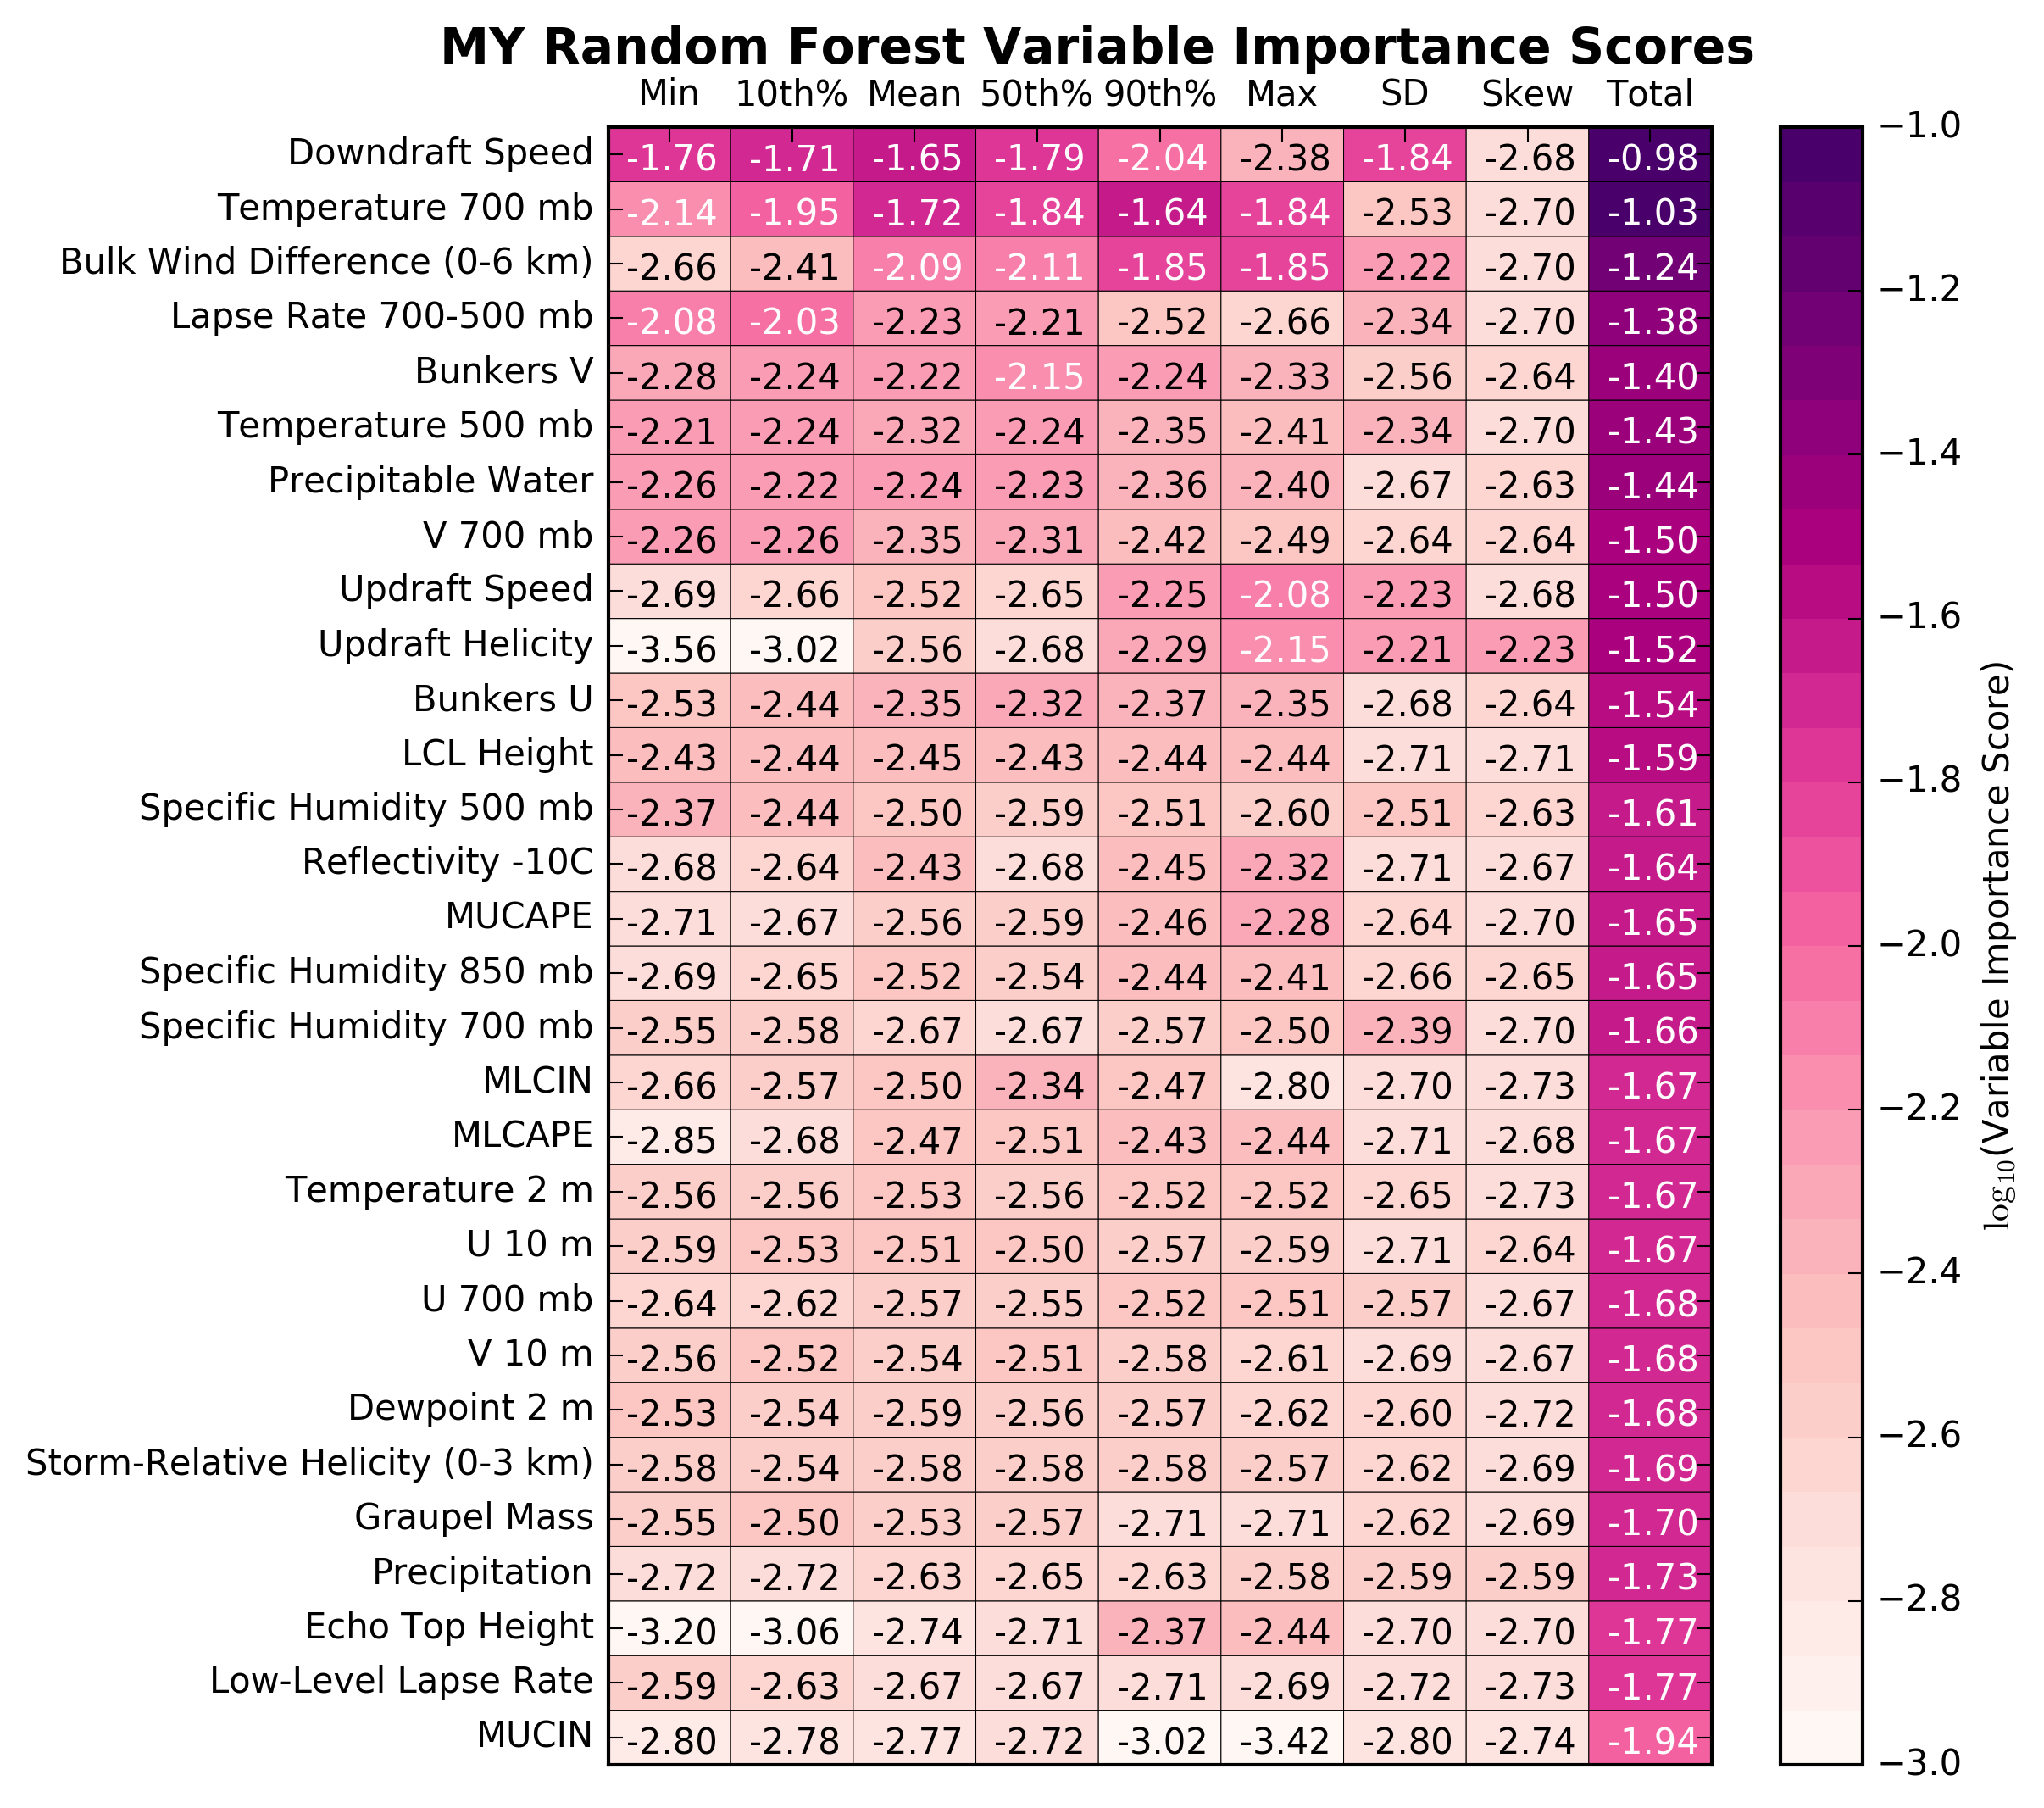

In [19]:
Image("/sharp/djgagne/hail_dissertation_figures/MY_Random-Forest_condition_vi_matrix.png")

## Hail Object Evaluation

In [198]:
model_names=dict(dist=["Random Forest", "Elastic Net", "Random Forest CV"],
                               condition=["Random Forest"])
model_types = ["dist", "condition"]
forecast_bins={"dist": np.array(["Shape_f", "Location_f", "Scale_f"]),
                             "condition": np.array(["ProbHail"]),
                             "translation-x":np.arange(-240000, 264000, 24000),
                             "translation-y":np.arange(-240000, 264000, 24000),
                             "start-time":np.arange(-6, 7, 1)
                             }
oe = ObjectEvaluator(datetime(2015,5,27), "SSEF", "wrf-s3cn_arw", model_names, model_types, 
                     forecast_bins, np.array([0, 25, 50, 75]), 
                "/sharp/djgagne/track_forecasts_spring2015_cqg_masked_json/", 
               "/sharp/djgagne/track_data_spring2015_cqg_masked_csv/")
oe.load_forecasts()
oe.load_obs()
oe.merge_obs()

In [453]:
def load_inputs(self):
        """
        Loads the track total and step files and merges the information into a single data frame.
        """
        track_total_file = self.track_data_csv_path + \
            "track_total_{0}_{1}_{2}.csv".format(self.ensemble_name,
                                                 self.ensemble_member,
                                                 self.run_date.strftime("%Y%m%d"))
        track_step_file = self.track_data_csv_path + \
            "track_step_{0}_{1}_{2}.csv".format(self.ensemble_name,
                                                self.ensemble_member,
                                                self.run_date.strftime("%Y%m%d"))
        #track_total_cols = ["Track_ID", "Translation_Error_X", "Translation_Error_Y", "Start_Time_Error"]
        #track_step_cols = ["Step_ID", "Track_ID", "Hail_Size", "Shape", "Location", "Scale"]
        track_step_data = pd.read_csv(track_step_file, index_col="Step_ID")
        return track_step_data

In [454]:
inputs = load_inputs(oe)

In [431]:
combo_data = pd.merge(inputs, oe.forecasts['dist']["Random Forest CV"])
combo_data = pd.merge(combo_data, oe.forecasts['condition']['Random Forest'])

In [496]:
track_files = sorted(glob("/sharp/djgagne/track_data_spring2016_cqg_closest_csv/track_step_SSEF_wrf-s3m8_arw*.csv"))
track_data = pd.concat([pd.read_csv(f) for f in track_files], ignore_index=True)


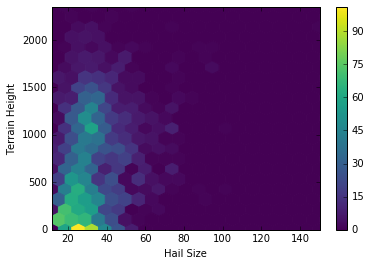

In [535]:
plt.hexbin(track_data.loc[track_data.Scale > 0,'Hail_Size'].values, 
           track_data.loc[track_data.Scale > 0,'hgtsfc_min'].values, gridsize=20, cmap="viridis")
plt.xlabel("Hail Size")
plt.ylabel("Terrain Height")
plt.colorbar()

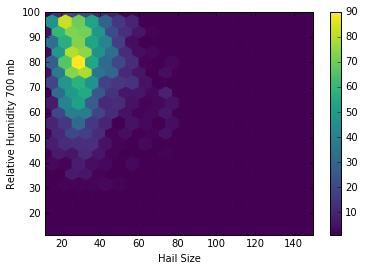

In [533]:
plt.hexbin(track_data.loc[track_data.Scale > 0,'Hail_Size'].values, 
           track_data.loc[track_data.Scale > 0,'rh700-potential_percentile_50'].values, gridsize=20, cmap="viridis",
          vmin=1)
plt.xlabel("Hail Size")
plt.ylabel("Relative Humidity 700 mb")
plt.colorbar()

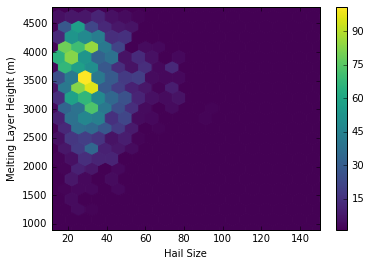

In [543]:
plt.hexbin(track_data.loc[track_data.Scale > 0,'Hail_Size'].values, 
           track_data.loc[track_data.Scale > 0,'melth-potential_mean'].values, gridsize=20, cmap="viridis",
          vmin=1)
plt.xlabel("Hail Size")
plt.ylabel("Melting Layer Height (m)")
plt.colorbar()

In [288]:
for c in inputs.columns:
    print c

Step_ID
Track_ID
Date
Forecast_Hour
Valid_Hour_UTC
Duration
Centroid_Lon
Centroid_Lat
Storm_Motion_U
Storm_Motion_V
uh_max_mean
uh_max_max
uh_max_min
uh_max_std
uh_max_skew
uh_max_percentile_10
uh_max_percentile_50
uh_max_percentile_90
r10cmx_mean
r10cmx_max
r10cmx_min
r10cmx_std
r10cmx_skew
r10cmx_percentile_10
r10cmx_percentile_50
r10cmx_percentile_90
wupmax_mean
wupmax_max
wupmax_min
wupmax_std
wupmax_skew
wupmax_percentile_10
wupmax_percentile_50
wupmax_percentile_90
cqgmax_mean
cqgmax_max
cqgmax_min
cqgmax_std
cqgmax_skew
cqgmax_percentile_10
cqgmax_percentile_50
cqgmax_percentile_90
wdnmax_mean
wdnmax_max
wdnmax_min
wdnmax_std
wdnmax_skew
wdnmax_percentile_10
wdnmax_percentile_50
wdnmax_percentile_90
echotp_mean
echotp_max
echotp_min
echotp_std
echotp_skew
echotp_percentile_10
echotp_percentile_50
echotp_percentile_90
accppt_mean
accppt_max
accppt_min
accppt_std
accppt_skew
accppt_percentile_10
accppt_percentile_50
accppt_percentile_90
pwat_mean
pwat_max
pwat_min
pwat_std
pwat_sk

In [361]:
bmap = Basemap(projection='cyl', resolution='l', fix_aspect=False,
              llcrnrlon=-125, llcrnrlat=23,
              urcrnrlon=-60, urcrnrlat=50)

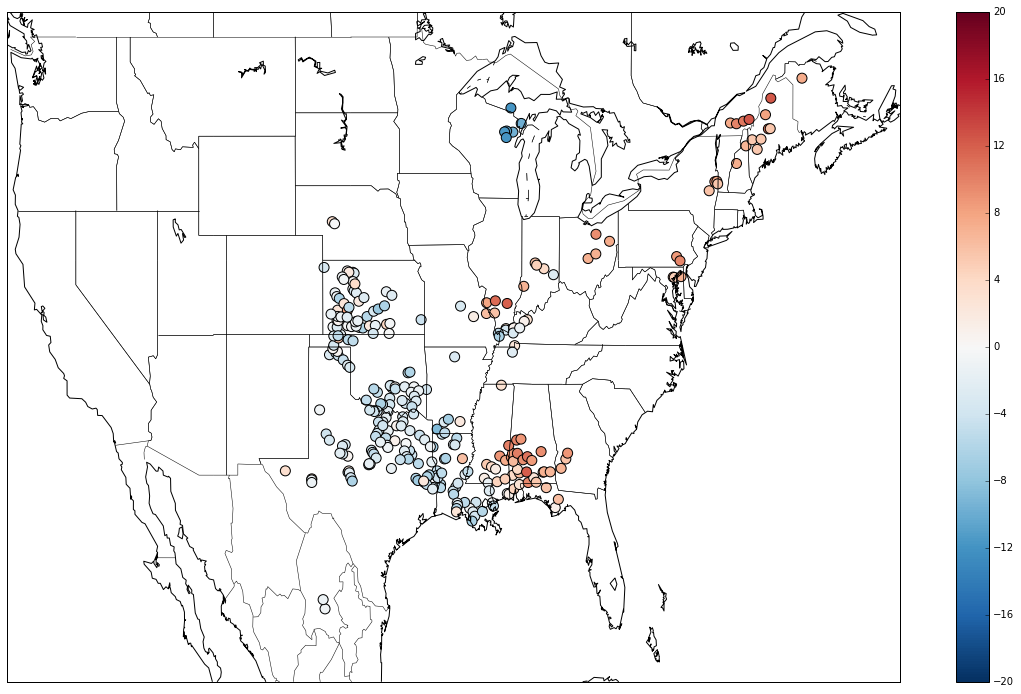

In [446]:
plt.figure(figsize=(20, 12))
bmap.drawstates()
bmap.drawcoastlines()
bmap.drawcountries()
plt.scatter(combo_data['Centroid_Lon'], combo_data['Centroid_Lat'], 100,
            combo_data['bkv_mean'], 
            cmap="RdBu_r", vmin=-20, vmax=20)
plt.colorbar()

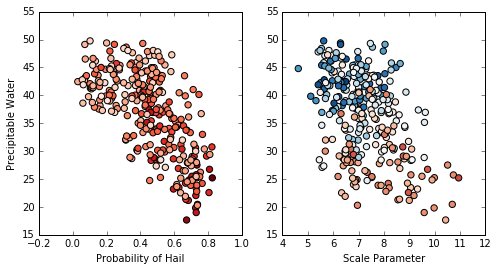

In [450]:
plot_var = "pwat_min"
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.scatter(combo_data["ProbHail"], combo_data[plot_var], 40, combo_data["Scale_f"], cmap="Reds")
plt.xlabel("Probability of Hail")
plt.ylabel("Precipitable Water")
plt.subplot(1,2,2)
plt.scatter(combo_data["Scale_f"], combo_data[plot_var], 40, combo_data["ProbHail"], cmap="RdBu_r",
           vmin=0, vmax=1)
plt.xlabel("Scale Parameter")

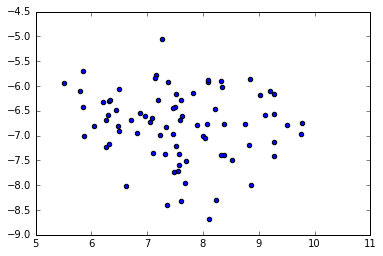

In [403]:
plt.scatter(combo_data["Scale_f"], combo_data["lr75-potential_min"] )

In [536]:
member_info = pd.read_csv("/sharp/djgagne/member_info_ssef_spring2015.csv", index_col="Ensemble_Member")

In [535]:
members = ["wrf-s3cn_arw"] + ["wrf-s3m{0:d}_arw".format(d) for d in range(3, 14)]
ens_prods = {}
for member in members:
    print member
    ens_prods[member] = EnsembleMemberProduct("SSEF", "Random Forest CV", member, datetime(2015,5,27), 
                           "dist", datetime(2015,5,27,13), datetime(2015,5,28,12), 
                            "/sharp/djgagne/track_forecasts_spring2015_cqg_masked_json/", False,
                           map_file="/home/djgagne/hagelslag/mapfiles/ssef2015.map",
                           condition_model_name="Random Forest")
    ens_prods[member].load_data()

wrf-s3cn_arw
Load track forecasts SSEF 20150527
wrf-s3m3_arw
Load track forecasts SSEF 20150527
wrf-s3m4_arw
Load track forecasts SSEF 20150527
wrf-s3m5_arw
Load track forecasts SSEF 20150527
wrf-s3m6_arw
Load track forecasts SSEF 20150527
wrf-s3m7_arw
Load track forecasts SSEF 20150527
wrf-s3m8_arw
Load track forecasts SSEF 20150527
wrf-s3m9_arw
Load track forecasts SSEF 20150527
wrf-s3m10_arw
Load track forecasts SSEF 20150527
wrf-s3m11_arw
Load track forecasts SSEF 20150527
wrf-s3m12_arw
Load track forecasts SSEF 20150527
wrf-s3m13_arw
Load track forecasts SSEF 20150527


In [534]:
def load_mrms(start_date, end_date, variable, path="/sharp/djgagne/mrms_spring2015//"):
    all_dates = pd.DatetimeIndex(start=start_date, end=end_date, freq="1H")
    data_files = np.array(sorted(glob(path + variable + "/*.nc")))
    data_file_dates = np.array([df.split("/")[-1][len(variable)+1:len(variable)+9] for df in data_files])
    curr_date = None
    prev_date = None
    ds = None
    data = []
    for date in all_dates:
        print date
        curr_date = date.date().strftime("%Y%m%d")
        if curr_date != prev_date:
            if prev_date is not None:
                ds.close()
            filename = data_files[curr_date == data_file_dates][0]
            ds = Dataset(filename)
            var_times = num2date(ds.variables["time"][:], ds.variables["time"].units)
        ti = np.where(var_times == date)[0]
        data.append(ds.variables[variable][ti][0])
    return np.array(data)
run_date = datetime(2015,5,27)            
start_date = run_date + timedelta(hours=13)          
mrms_data = load_mrms(start_date, start_date + timedelta(hours=23),"MESH_Max_60min_00.50")
us_mask_file = Dataset("/home/djgagne/hagelslag/mapfiles/ssef_2015_us_mask.nc")
us_mask = us_mask_file.variables["usa_mask"][:]
us_mask_file.close()
mrms_data = mrms_data * us_mask

2015-05-27 13:00:00
2015-05-27 14:00:00
2015-05-27 15:00:00
2015-05-27 16:00:00
2015-05-27 17:00:00
2015-05-27 18:00:00
2015-05-27 19:00:00
2015-05-27 20:00:00
2015-05-27 21:00:00
2015-05-27 22:00:00
2015-05-27 23:00:00
2015-05-28 00:00:00
2015-05-28 01:00:00
2015-05-28 02:00:00
2015-05-28 03:00:00
2015-05-28 04:00:00
2015-05-28 05:00:00
2015-05-28 06:00:00
2015-05-28 07:00:00
2015-05-28 08:00:00
2015-05-28 09:00:00
2015-05-28 10:00:00
2015-05-28 11:00:00
2015-05-28 12:00:00


In [537]:
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter
def period_surrogate_severe_prob(data, threshold, radius, sigma, stagger):
        i_grid, j_grid = np.indices(data.shape[1:])
        max_data = data.max(axis=0)
        if np.count_nonzero(max_data >= threshold) > 0:
            max_points = np.array(np.where(max_data >= threshold)).T
            max_tree = cKDTree(max_points)
            stagger_points = np.vstack((i_grid[::stagger, ::stagger].ravel(), j_grid[::stagger, ::stagger].ravel())).T
            valid_stagger_points = np.zeros(stagger_points.shape[0])
            stagger_tree = cKDTree(stagger_points)
            hit_points = np.unique(np.concatenate(max_tree.query_ball_tree(stagger_tree, radius)))
            valid_stagger_points[hit_points] += 1
            surrogate_grid = valid_stagger_points.reshape(i_grid[::stagger, ::stagger].shape)
            surrogate_grid = gaussian_filter(surrogate_grid, sigma)
        else:
            surrogate_grid = np.zeros(max_data[::stagger, ::stagger].shape)
        return surrogate_grid
mrms_prob = period_surrogate_severe_prob(mrms_data, 50, 14, 2, 14)

In [538]:
uh_prods = {}
for member in members:
    print member
    uh_prods[member] = EnsembleMemberProduct("SSEF", "WRF", member, datetime(2015,5,27), 
                           "hailsz", datetime(2015,5,27,13), datetime(2015,5,28,12), 
                            "/sharp/djgagne/spring2015_nc/", False,
                           map_file="/home/djgagne/hagelslag/mapfiles/ssef2015.map",
                           condition_model_name=None)
    uh_prods[member].load_data()

wrf-s3cn_arw
wrf-s3m3_arw
wrf-s3m4_arw
wrf-s3m5_arw
wrf-s3m6_arw
wrf-s3m7_arw
wrf-s3m8_arw
wrf-s3m9_arw
wrf-s3m10_arw
wrf-s3m11_arw
wrf-s3m12_arw
wrf-s3m13_arw


In [539]:
ss_probs = {}
for member in members:
    print member
    ss_probs[member] = ens_prods[member].period_surrogate_severe_prob(50, 14, 2, 14)

wrf-s3cn_arw
wrf-s3m3_arw
wrf-s3m4_arw
wrf-s3m5_arw
wrf-s3m6_arw
wrf-s3m7_arw
wrf-s3m8_arw
wrf-s3m9_arw
wrf-s3m10_arw
wrf-s3m11_arw
wrf-s3m12_arw
wrf-s3m13_arw


In [540]:
ss_uh_probs = {}
for member in members:
    print member
    ss_uh_probs[member] = uh_prods[member].period_surrogate_severe_prob(50, 14, 2, 14)

wrf-s3cn_arw
wrf-s3m3_arw
wrf-s3m4_arw
wrf-s3m5_arw
wrf-s3m6_arw
wrf-s3m7_arw
wrf-s3m8_arw
wrf-s3m9_arw
wrf-s3m10_arw
wrf-s3m11_arw
wrf-s3m12_arw
wrf-s3m13_arw


In [167]:
projd = ens_prods["wrf-s3cn_arw"].proj_dict
gridd = ens_prods["wrf-s3cn_arw"].grid_dict
bmap = Basemap(projection=projd["proj"], 
               resolution="l", 
               lon_0=projd["lon_0"], 
               lat_0=projd["lat_0"],
               lat_1=projd["lat_1"],
               lat_2=projd["lat_2"],
               #llcrnrlon=gridd["sw_lon"],
               #llcrnrlat=gridd["sw_lat"],
               #urcrnrlon=gridd["ne_lon"],
               #urcrnrlat=gridd["ne_lat"],
               llcrnrlon=-106,
               llcrnrlat=28,
               urcrnrlon=-80,
               urcrnrlat=45,
               rsphere=projd["a"])

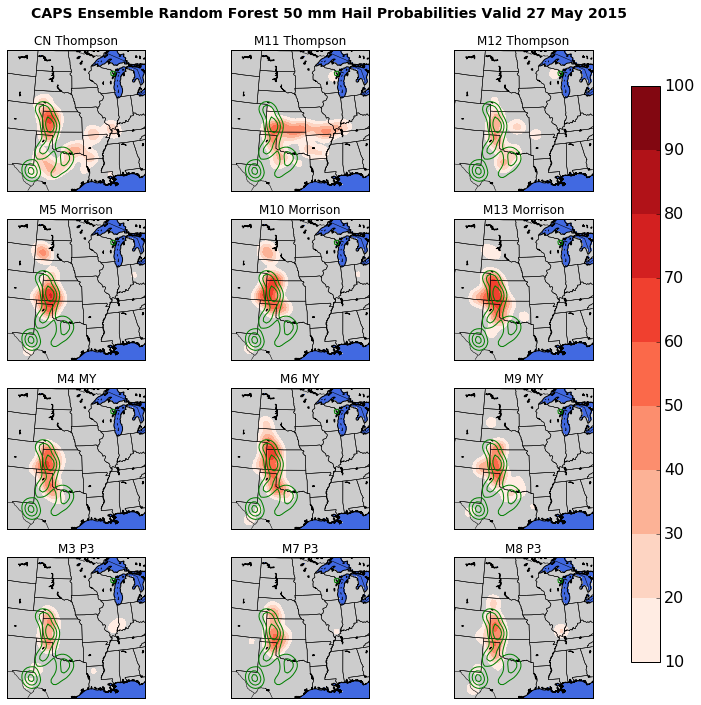

In [541]:
fig, all_axes = plt.subplots(4,3, figsize=(10, 10))
plt.subplots_adjust(0.02, 0.02, 0.9, 0.92)
stagger = 14
x_g, y_g = bmap(ens_prods["wrf-s3cn_arw"].mapping_data["lon"][::stagger,::stagger], 
               ens_prods["wrf-s3cn_arw"].mapping_data["lat"][::stagger,::stagger])
mp_members_order = ["wrf-s3cn_arw", "wrf-s3m11_arw", "wrf-s3m12_arw"] +\
                   ["wrf-s3m5_arw", "wrf-s3m10_arw", "wrf-s3m13_arw"] +\
                   ["wrf-s3m4_arw", "wrf-s3m6_arw", "wrf-s3m9_arw"] +\
                   ["wrf-s3m3_arw", "wrf-s3m7_arw", "wrf-s3m8_arw"]
for a, ax in enumerate(all_axes.ravel()):
    bmap.drawcoastlines(ax=ax)
    bmap.drawstates(ax=ax)
    bmap.drawcountries(ax=ax)
    bmap.drawlsmask(ocean_color="royalblue", ax=ax)
    co = ax.contourf(x_g, y_g, ss_probs[mp_members_order[a]] * 100, np.arange(10, 110, 10), cmap="Reds")
    ax.contour(x_g, y_g, mrms_prob * 100, [10, 20, 30], colors=["green"])
    ax.set_title(mp_members_order[a][6:-4].upper() + " " + member_info.loc[mp_members_order[a], "MicrophysicsTrue"])
fig.suptitle("CAPS Ensemble Random Forest 50 mm Hail Probabilities Valid 27 May 2015", fontsize=14, fontweight="bold")
cbar_ax = fig.add_axes([0.92, 0.07, 0.04, 0.8])
cbar = fig.colorbar(co, cax=cbar_ax)
cbar.ax.tick_params(labelsize=16)
plt.savefig("/sharp/djgagne/hail_dissertation_figures/ml_hail_ss_20150527.pdf", dpi=300, bbox_inches="tight")

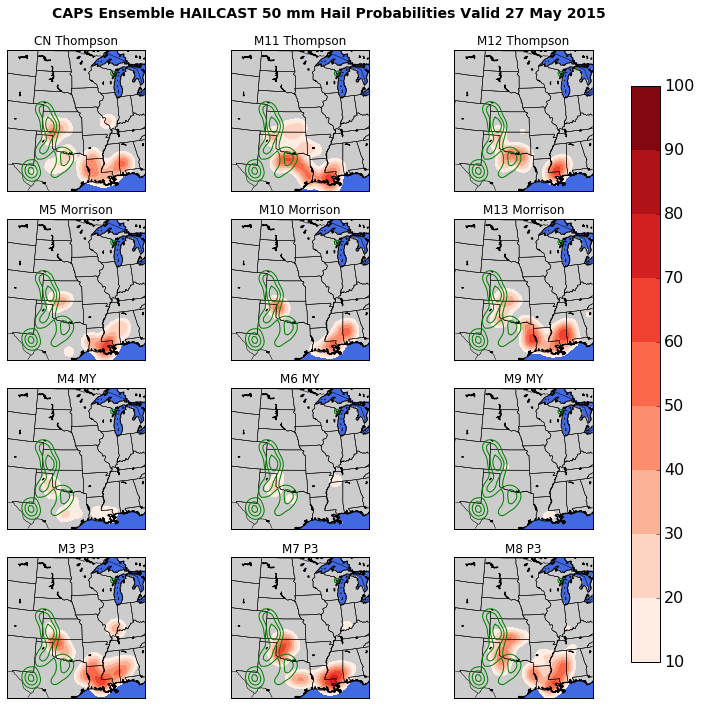

In [542]:
fig, all_axes = plt.subplots(4,3, figsize=(10, 10))
plt.subplots_adjust(0.02, 0.02, 0.9, 0.92)
stagger = 14
x_g, y_g = bmap(ens_prods["wrf-s3cn_arw"].mapping_data["lon"][::stagger,::stagger], 
               ens_prods["wrf-s3cn_arw"].mapping_data["lat"][::stagger,::stagger])
mp_members_order = ["wrf-s3cn_arw", "wrf-s3m11_arw", "wrf-s3m12_arw"] +\
                   ["wrf-s3m5_arw", "wrf-s3m10_arw", "wrf-s3m13_arw"] +\
                   ["wrf-s3m4_arw", "wrf-s3m6_arw", "wrf-s3m9_arw"] +\
                   ["wrf-s3m3_arw", "wrf-s3m7_arw", "wrf-s3m8_arw"]
for a, ax in enumerate(all_axes.ravel()):
    bmap.drawcoastlines(ax=ax)
    bmap.drawstates(ax=ax)
    bmap.drawcountries(ax=ax)
    bmap.drawlsmask(ocean_color="royalblue", ax=ax)
    co = ax.contourf(x_g, y_g, ss_uh_probs[mp_members_order[a]] * 100, np.arange(10, 110, 10), cmap="Reds")
    ax.contour(x_g, y_g, mrms_prob * 100, [10, 20, 30], colors=["green"])
    ax.set_title(mp_members_order[a][6:-4].upper() + " " + member_info.loc[mp_members_order[a], "MicrophysicsTrue"])
fig.suptitle("CAPS Ensemble HAILCAST 50 mm Hail Probabilities Valid 27 May 2015", fontsize=14, fontweight="bold")
cbar_ax = fig.add_axes([0.92, 0.07, 0.04, 0.8])
cbar = fig.colorbar(co, cax=cbar_ax)
cbar.ax.tick_params(labelsize=16)
plt.savefig("/sharp/djgagne/hail_dissertation_figures/hailcast_ss_20150527.pdf", dpi=300, bbox_inches="tight")

65.8404
64.0294
62.881
64.1323
65.596
67.2462
66.794
63.6958
62.9638
63.7947
62.2273
61.874


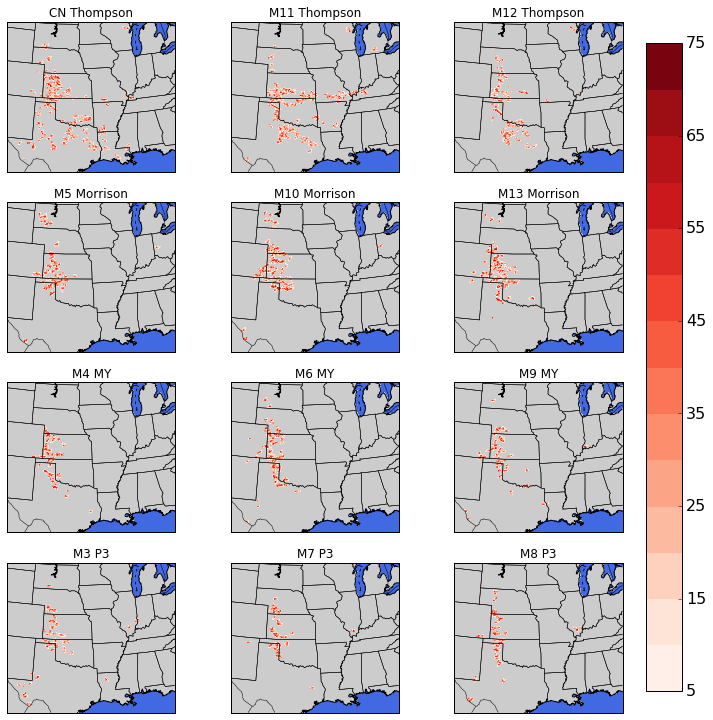

In [178]:
fig, all_axes = plt.subplots(4,3, figsize=(10, 10))
plt.subplots_adjust(0.02, 0.02, 0.9, 0.98)
stagger = 14
x_g, y_g = bmap(ens_prods["wrf-s3cn_arw"].mapping_data["lon"], 
               ens_prods["wrf-s3cn_arw"].mapping_data["lat"])
mp_members_order = ["wrf-s3cn_arw", "wrf-s3m11_arw", "wrf-s3m12_arw"] +\
                   ["wrf-s3m5_arw", "wrf-s3m10_arw", "wrf-s3m13_arw"] +\
                   ["wrf-s3m4_arw", "wrf-s3m6_arw", "wrf-s3m9_arw"] +\
                   ["wrf-s3m3_arw", "wrf-s3m7_arw", "wrf-s3m8_arw"]
for a, ax in enumerate(all_axes.ravel()):
    bmap.drawcoastlines(ax=ax)
    bmap.drawstates(ax=ax)
    bmap.drawcountries(ax=ax)
    bmap.drawlsmask(ocean_color="royalblue", ax=ax)
    print ens_prods[mp_members_order[a]].data.max()
    co = ax.contourf(x_g, y_g, ens_prods[mp_members_order[a]].data.max(axis=0), np.arange(5, 80, 5), cmap="Reds")
    ax.set_title(mp_members_order[a][6:-4].upper() + " " + member_info.loc[mp_members_order[a], "MicrophysicsTrue"])
cbar_ax = fig.add_axes([0.92, 0.05, 0.05, 0.9])
cbar = fig.colorbar(co, cax=cbar_ax)
cbar.ax.tick_params(labelsize=16)
plt.savefig("/sharp/djgagne/hail_dissertation_figures/max_hail_20150527.png", dpi=300, bbox_inches="tight")

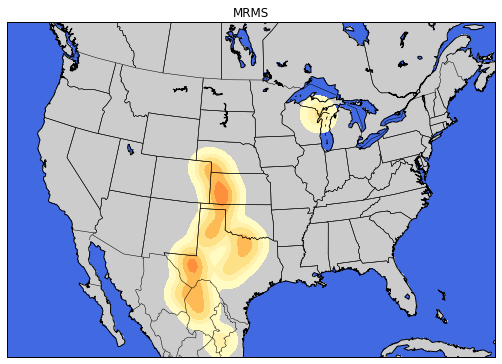

In [160]:
mean_prob = np.dstack(ss_probs.values()).mean(axis=-1)
fig, ax = plt.subplots(figsize=(10, 6))
bmap.drawcoastlines(ax=ax)
bmap.drawstates(ax=ax)
bmap.drawcountries(ax=ax)
bmap.drawlsmask(ocean_color="royalblue", ax=ax)

ax.contourf(x_g, y_g, mrms_prob * 100, [1, 5] + range(10, 80, 10), cmap="YlOrRd")
ax.set_title("MRMS")


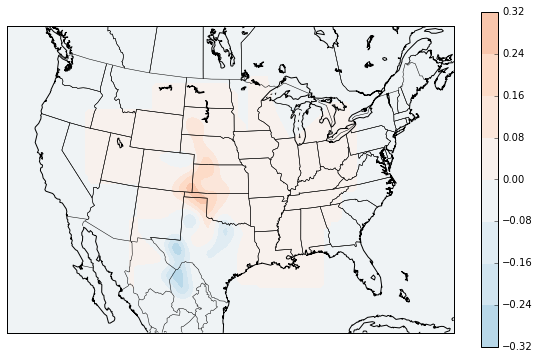

In [154]:
fig, ax = plt.subplots(figsize=(10, 6))
bmap.drawcoastlines(ax=ax)
bmap.drawstates(ax=ax)
bmap.drawcountries(ax=ax)
bmap.drawlsmask(ocean_color="royalblue", ax=ax)
plt.contourf(x_g, y_g, mean_prob - mrms_prob, cmap="RdBu_r", vmin=-1, vmax=1)
plt.colorbar()

In [142]:
np.mean(np.abs(mean_prob - mrms_prob))

0.013232632675087468

In [155]:
np.mean(np.abs(np.dstack(ss_probs.values()).mean(axis=-1) - mrms_prob))

0.0088760629254821984

(array([ 223.,  156.,  117.,  103.,   74.,   50.,   43.,   25.,   26.,
          19.,   24.,   11.,   13.,    4.,   10.,    6.,    8.,    8.,
           5.,    6.,    4.,    4.,    7.,    6.,    4.,    5.,    1.,
           4.,    5.,    4.,    3.,    4.,    3.,    5.,    3.,    4.,
           4.,    1.,    3.,    1.,    3.,    7.,    3.,    4.,    2.,
           4.,    2.,    3.,    3.,    5.,    3.,    3.,    3.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 

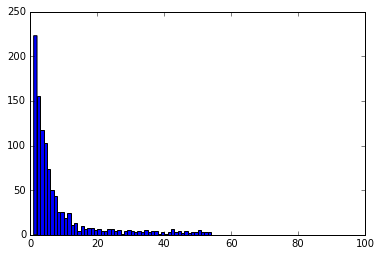

In [158]:
plt.hist(mean_prob.ravel() * 100, np.arange(1, 100))

In [206]:
merged_data_cn = pd.read_csv("/sharp/djgagne/track_forecasts_spring2015_cqg_masked_merged_csv/track_forecast_data_SSEF_wrf-s3cn_arw_combined.csv")
solar_files = sorted(glob("/sharp/djgagne/ssef_solar_data_2015/site_data_SSEF_wrf-s3cn_arw*.csv"))
solar_data_cn = pd.concat([pd.read_csv(x) for x in solar_files], ignore_index=True)
solar_data_cn =solar_data_cn.dropna()

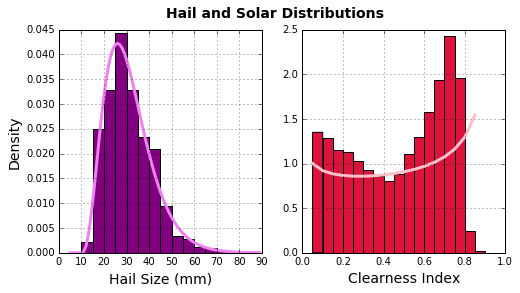

In [261]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
merged_data_cn.loc[merged_data_cn["Hail_Size"] > 0, "Hail_Size"].hist(bins=np.arange(5, 90, 5), color="purple", normed=True)
plt.plot(np.arange(5, 90, ), gamma.pdf(np.arange(5, 90, ), 
                                       *gamma.fit(merged_data_cn.loc[merged_data_cn["Hail_Size"] > 0, 
                                                                     "Hail_Size"].values)),
        color="violet", lw=3)
plt.ylabel("Density", fontsize=14)
plt.xlabel("Hail Size (mm)", fontsize=14)
plt.subplot(1,2,2)
solar_vals = solar_data_cn["CLRI_Mean"][solar_data_cn["CLRI_Mean"] < 1].values
solar_data_cn["CLRI_Mean"].hist(bins=np.arange(0.05, 1, 0.05), color="crimson", normed=True)
plt.plot(np.arange(0.05, 0.9, 0.05), beta.pdf(np.arange(0.05, 0.9, 0.05), 0.85, 0.66, 0, 0.92),
        color="pink", lw=3, label="Beta Distribution")
plt.suptitle("Hail and Solar Distributions", fontsize=14, fontweight="bold")
plt.xlabel("Clearness Index", fontsize=14)
plt.savefig("/sharp/djgagne/hail_dissertation_figures/hail_kt_dists.pdf", bbox_inches="tight")

In [247]:
beta.fit(solar_vals, loc=0)

(0.66086345267661906,
 0.85080168816568102,
 -0.0015095985535433032,
 0.92226814395225554)

In [262]:
tor_warn = pd.read_csv("/sharp/djgagne/TornadoWarningStats.csv")

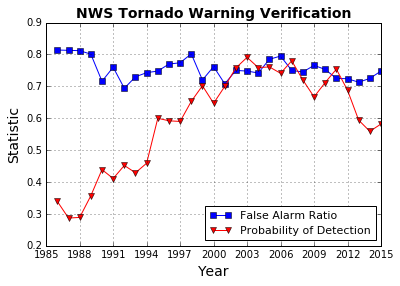

In [312]:
plt.figure(figsize=(6,4))
plt.plot(tor_warn["Year"], tor_warn["FAR"],"bs-", label="False Alarm Ratio")
plt.plot(tor_warn["Year"], tor_warn["POD"],"rv-", label="Probability of Detection")
plt.legend(loc=0, fontsize=11)
plt.ylabel("Statistic", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.xticks(np.arange(1985, 2016, 3))
plt.grid()
plt.title("NWS Tornado Warning Verification", fontsize=14, fontweight="bold")
plt.savefig("/sharp/djgagne/hail_dissertation_figures/tor_warn_verify.pdf", bbox_inches="tight")

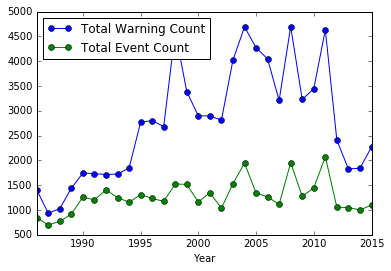

In [272]:
tor_warn.plot(x="Year", y=["Total Warning Count", "Total Event Count"], marker='o')

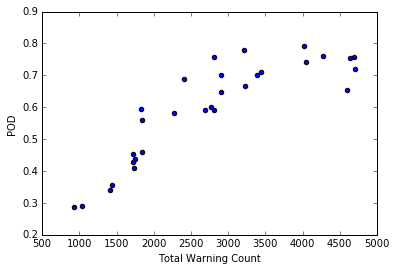

In [278]:
tor_warn.plot(x="Total Warning Count", y="POD", kind="scatter")

In [279]:
tor_warn.columns

Index([u'Year', u'Total Warning Count', u'Verified Warnings',
       u'Unverified Warnings', u'Total Event Count', u'Warned Events',
       u'Unwarned Events', u'POD', u'FAR', u'CSI', u'Mean Leadtime (min)'],
      dtype='object')

In [285]:
tor_warn["Warned Events"] / (tor_warn["Total Event Count"])

0     0.339243
1     0.286944
2     0.289235
3     0.357298
4     0.439237
5     0.411277
6     0.452279
7     0.428914
8     0.459343
9     0.600305
10    0.591721
11    0.589787
12    0.652687
13    0.702310
14    0.646552
15    0.700000
16    0.757722
17    0.791123
18    0.759383
19    0.761161
20    0.740506
21    0.780072
22    0.665302
23    0.615686
24    0.652595
25    0.701687
26    0.620853
27    0.526667
28    0.482517
29    0.513636
dtype: float64

In [282]:
tor_warn["POD"]

0     0.339
1     0.287
2     0.289
3     0.357
4     0.439
5     0.411
6     0.452
7     0.429
8     0.459
9     0.600
10    0.592
11    0.590
12    0.653
13    0.702
14    0.647
15    0.700
16    0.758
17    0.791
18    0.759
19    0.761
20    0.741
21    0.780
22    0.720
23    0.667
24    0.712
25    0.754
26    0.688
27    0.594
28    0.559
29    0.582
Name: POD, dtype: float64

In [9]:
coarse_eval = pd.concat([pd.read_csv(f, parse_dates=["Run_Date"]) for f in sorted(glob("/sharp/djgagne/ssef_coarse_neighbor_eval_2015/*.csv"))], ignore_index=True)

In [10]:
us_eval = coarse_eval.loc[coarse_eval["us_mask"] == 1]

In [177]:
all_fore_vars = us_eval.columns[["SSEF" in var for var in us_eval.columns]]
obs = us_eval["MESH_Max_60min_00.50_25"]
members = ["wrf-s3cn_arw"] + ["wrf-s3m{0:d}_arw".format(m) for m in range(3, 14)] + ["mean"]
fore_vars = ["uh_max", "cqgmax", "hailsz", "r10cmx", "Random-Forest", "Random-Forest-CV", "Elastic-Net"]
thresh = [75, 25, 25, 60, 25, 25, 25]
#thresh = [150, 50, 50, 60, 50, 50, 50]
aucs = pd.DataFrame(np.zeros((len(fore_vars), len(members))), columns=members, index=fore_vars)
rels = pd.DataFrame(np.zeros((len(fore_vars), len(members))), columns=members, index=fore_vars)
for f, fore_var in enumerate(fore_vars):
    for member in members:
        fore = us_eval["SSEF_{0}_{1}_{2:d}".format(fore_var, member, thresh[f])].values
        roc = DistributedROC(thresholds=np.concatenate([[0,0.01, 0.05], np.arange(0.1, 1.1, 0.1)]))
        rel = DistributedReliability(thresholds=np.concatenate([[0,0.01, 0.05], np.arange(0.1, 1.1, 0.1)]))
        roc.update(fore, obs)
        rel.update(fore, obs)
        aucs.loc[fore_var, member] = roc.auc()
        try:
            rels.loc[fore_var, member] = rel.brier_score()
        except ZeroDivisionError:
            rels.loc[fore_var, member] = np.nan

In [376]:
prob_thresh = 0.1
obs_var = "MESH_Max_60min_00.50_50"
coarse_files = sorted(glob("/sharp/djgagne/ssef_coarse_neighbor_eval_2015/*.csv"))
eval_day = pd.read_csv(coarse_files[0])
grid_shape = (eval_day["i_small"].max() + 1, eval_day["j_small"].max() + 1)
eval_grids_caps = {}
coarse_models = ["SSEF_Random-Forest-CV_mean_50",
                 "SSEF_hailsz_mean_50", "SSEF_uh_max_mean_150", "SSEF_cqgmax_mean_50"]
for model in coarse_models:
    eval_grids_caps[model] = {}
    for grid_type in ["TP", "FP", "FN"]:
        eval_grids_caps[model][grid_type] = np.zeros(grid_shape, dtype=int)
clon = eval_day["lon"].reshape(grid_shape)
clat = eval_day["lat"].reshape(grid_shape)
for f in coarse_files:
    print f
    eval_day = pd.read_csv(f)
    us_mask = eval_day["us_mask"].values
    for model in coarse_models:
        tp_idx = (eval_day[model] * us_mask >= prob_thresh) & (eval_day[obs_var] * us_mask == 1)
        fp_idx = (eval_day[model] * us_mask >= prob_thresh) & (eval_day[obs_var] * us_mask == 0)
        fn_idx = (eval_day[model] * us_mask < prob_thresh) & (eval_day[obs_var] * us_mask == 1)
        eval_grids_caps[model]["TP"][eval_day["i_small"][tp_idx].values, eval_day["j_small"][tp_idx].values] += 1
        eval_grids_caps[model]["FP"][eval_day["i_small"][fp_idx].values, eval_day["j_small"][fp_idx].values] += 1
        eval_grids_caps[model]["FN"][eval_day["i_small"][fn_idx].values, eval_day["j_small"][fn_idx].values] += 1

/sharp/djgagne/ssef_coarse_neighbor_eval_2015/coarse_neighbor_eval_SSEF_20150512.csv
/sharp/djgagne/ssef_coarse_neighbor_eval_2015/coarse_neighbor_eval_SSEF_20150513.csv
/sharp/djgagne/ssef_coarse_neighbor_eval_2015/coarse_neighbor_eval_SSEF_20150514.csv
/sharp/djgagne/ssef_coarse_neighbor_eval_2015/coarse_neighbor_eval_SSEF_20150515.csv
/sharp/djgagne/ssef_coarse_neighbor_eval_2015/coarse_neighbor_eval_SSEF_20150519.csv
/sharp/djgagne/ssef_coarse_neighbor_eval_2015/coarse_neighbor_eval_SSEF_20150520.csv
/sharp/djgagne/ssef_coarse_neighbor_eval_2015/coarse_neighbor_eval_SSEF_20150521.csv
/sharp/djgagne/ssef_coarse_neighbor_eval_2015/coarse_neighbor_eval_SSEF_20150522.csv
/sharp/djgagne/ssef_coarse_neighbor_eval_2015/coarse_neighbor_eval_SSEF_20150525.csv
/sharp/djgagne/ssef_coarse_neighbor_eval_2015/coarse_neighbor_eval_SSEF_20150526.csv
/sharp/djgagne/ssef_coarse_neighbor_eval_2015/coarse_neighbor_eval_SSEF_20150527.csv
/sharp/djgagne/ssef_coarse_neighbor_eval_2015/coarse_neighbor_eva

In [213]:
proj_dict, grid_dict = read_arps_map_file("/home/djgagne/hagelslag/mapfiles/ssef2015.map")
print proj_dict
print grid_dict
proj_dict["rsphere"] = proj_dict["a"]
del proj_dict["a"]
del proj_dict["b"]
del proj_dict["proj"]
del proj_dict["units"]
bmap_full = Basemap(llcrnrlon=grid_dict["sw_lon"], llcrnrlat=grid_dict["sw_lat"], urcrnrlon=grid_dict["ne_lon"],
               urcrnrlat=grid_dict["ne_lat"], resolution="l", projection="lcc",**proj_dict)

{'a': 6370000.0, 'b': 6370000.0, 'lon_0': -97.0, 'proj': 'lcc', 'units': 'm', 'lat_2': 60.0, 'lat_1': 30.0, 'lat_0': 38.50001}
{'sw_lon': -120.0759, 'ne_lon': -59.89298, 'dx': 3000.0, 'dy': 3000.0, 'sw_lat': 19.78931, 'ne_lat': 49.05653}


92
102.0 92
92
98.0 92
92
110.0 92
92
99.0 92


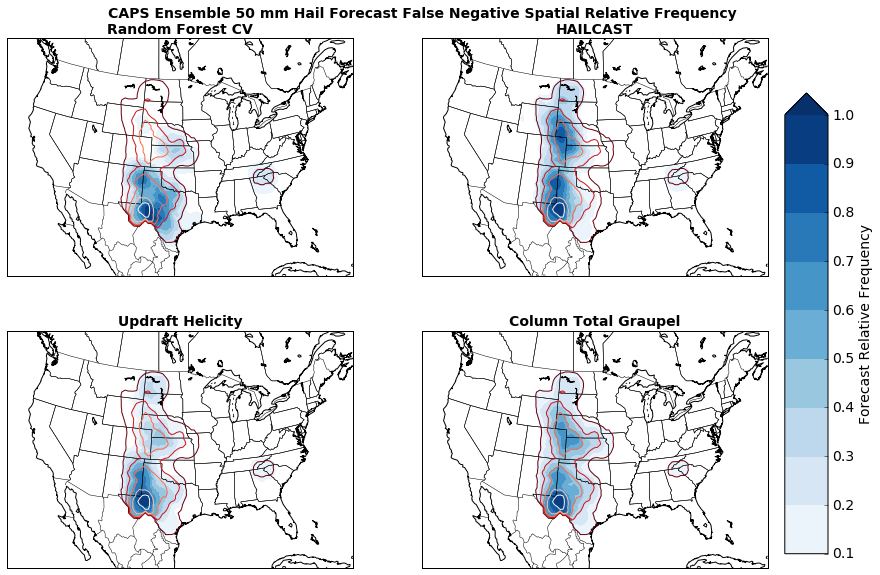

In [379]:
from scipy.ndimage import convolve
from skimage.morphology import disk
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(0.02, 0.02, 0.9, 0.95)
disk_area = disk(5)
cx, cy = bmap_full(clon, clat)
long_coarse_model_names = ["Random Forest CV", "HAILCAST", "Updraft Helicity", "Column Total Graupel"]
us_mask_grid = us_mask.reshape(grid_shape)
for m, model in enumerate(coarse_models):
    plt.subplot(2, 2, m + 1)
    tp_conv = convolve(eval_grids_caps[model]["TP"], disk_area) * us_mask_grid
    fn_conv = convolve(eval_grids_caps[model]["FN"], disk_area) * us_mask_grid
    fp_conv = convolve(eval_grids_caps[model]["FP"], disk_area) * us_mask_grid
    fore_conv = convolve(eval_grids_caps[model]["TP"] + eval_grids_caps[model]["FP"], disk_area) * us_mask_grid
    obs_conv = convolve(eval_grids_caps[model]["TP"] + eval_grids_caps[model]["FN"], disk_area) * us_mask_grid
    print obs_conv.max()
    csi_conv = tp_conv.astype(float) / (tp_conv + fp_conv)
    #plt.pcolormesh(np.ma.array(csi_conv, mask=(csi_conv==0) | np.isnan(csi_conv)) , vmin=0, vmax=0.5, cmap="viridis")
    bmap_full.drawstates()
    bmap_full.drawcoastlines()
    bmap_full.drawcountries()
    #plt.pcolormesh(cx, cy, np.ma.array(csi_conv, mask=(csi_conv==0) | np.isnan(csi_conv)),vmin=0, vmax=0.3, cmap="Blues")
    #plt.contourf(cx, cy, fn_conv, cmap="Blues")
    max_val = float(tp_conv.max() + fn_conv.max())
    print max_val, obs_conv.max()
    cf = plt.contourf(cx, cy, fn_conv / float(fn_conv.max()), np.arange(0.1, 1.1, 0.1), extend="max", cmap="Blues")
    co = plt.contour(cx, cy, obs_conv / float(obs_conv.max()), np.arange(0.1, 1.1, 0.2), extend="max", cmap="Reds_r")

    #co = plt.contourf(cx, cy, csi_conv * us_mask.reshape(grid_shape), np.arange(0.1, 0.55, 0.05), 
    #                  extend="max", cmap="Blues")
    plt.title(long_coarse_model_names[m], fontsize=14, fontweight="bold")
fig.suptitle("CAPS Ensemble 50 mm Hail Forecast False Negative Spatial Relative Frequency", fontsize=14, fontweight="bold", y=1)
cbar_ax = fig.add_axes([0.92, 0.05, 0.05, 0.8])
cbar = fig.colorbar(cf, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel("Forecast Relative Frequency", fontsize=14)
plt.savefig("/sharp/djgagne/hail_dissertation_figures/caps_spatial_fn_50.pdf", bbox_inches="tight")

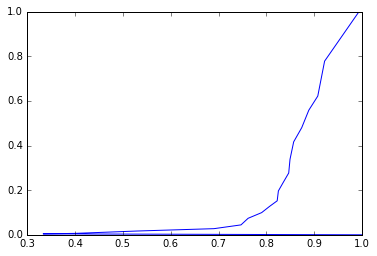

In [187]:
pods = [x.pod() for x in roc.get_contingency_tables()]
fars = [x.far() for x in roc.get_contingency_tables()]
plt.plot(fars, pods)

In [428]:
n_boot = 1000
rand_idx = np.random.randint(0, len(obs), (n_boot, len(obs)))
boot_obs = obs.values[rand_idx]
boot_aucs = np.zeros((len(fore_vars), n_boot))
boot_bss = np.zeros((len(fore_vars), n_boot))
fore_thresh = np.linspace(0, 1, 20)
roc_obj = DistributedROC(thresholds=fore_thresh)
rel_obj = DistributedReliability(thresholds=fore_thresh)
for f, fore_var in enumerate(fore_vars):
    print fore_var
    fore = us_eval["SSEF_{0}_{1}_{2:d}".format(fore_var, "mean", thresh[f])].values
    boot_fore = fore[rand_idx]
    for b in range(n_boot):
        roc_obj.update(boot_fore[b], boot_obs[b])
        rel_obj.update(boot_fore[b], boot_obs[b])
        boot_aucs[f, b] = roc_obj.auc()
        boot_bss[f, b] = rel_obj.brier_skill_score()
        roc_obj.contingency_tables.loc[:, :] = 0
        rel_obj.frequencies.loc[:, :] = 0

uh_max
cqgmax
hailsz
r10cmx
Random-Forest
Random-Forest-CV
Elastic-Net


In [166]:
def boot_rank_table(boot_scores, model_names, title, filename):
    mean_scores = boot_scores.mean(axis=1)
    score_ranks = np.argsort(mean_scores)
    boot_ranks = np.argsort(boot_scores, axis=0)
    boot_rank_counts = np.zeros((len(model_names), len(model_names)), dtype=int)
    for f, model_name in enumerate(model_names):
        boot_rank_counts[f] = [np.count_nonzero(boot_ranks[r]==f) for r in range(len(model_names))]
    boot_rank_counts = boot_rank_counts[score_ranks, ::-1]
    fig = plt.figure(figsize=(8, 5))
    tick_names = np.array([model_names[m] + " ({0:0.2f})".format(mean_scores[m]) for m in range(len(model_names))])
    plt.pcolormesh(np.ma.array(boot_rank_counts, mask=boot_rank_counts==0), edgecolor='k', cmap="RdPu", vmin=1, vmax=1000)
    for (r, c), b in np.ndenumerate(boot_rank_counts):
        if b > 900:
            tcolor="w"
        else:
            tcolor="k"
        plt.text(c + 0.5,r+0.5,b, fontsize=12, fontweight="bold", ha="center", va="center", color=tcolor)
    plt.xticks(np.arange(len(model_names)) + 0.5, np.arange(1, len(model_names) + 1), fontsize=12)
    plt.yticks(np.arange(len(model_names)) + 0.5, tick_names[score_ranks], fontsize=12)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.xlabel("Ranking", fontsize=14)
    plt.savefig(filename, bbox_inches="tight")
    return


[ 0.73424821  0.52713004  0.68989362  0.87873768  0.82810673  0.83826696
  0.82036538]
[1 2 0 6 4 5 3]
          uh_max +0.744 [   0    0 1000    0    0    0    0]
          cqgmax +0.531 [1000    0    0    0    0    0    0]
          hailsz +0.683 [   0 1000    0    0    0    0    0]
          r10cmx +0.887 [   0    0    0    0    0    0 1000]
   Random-Forest +0.843 [  0   0   0  66 912  22   0]
Random-Forest-CV +0.851 [  0   0   0   0  22 978   0]
     Elastic-Net +0.835 [  0   0   0 934  66   0   0]
[  1.35939133e-02  -2.55604819e-03  -1.31985143e-01  -4.61129886e+00
  -1.60935784e-01  -1.36455221e-01  -1.12381030e-01]
[3 4 5 2 6 1 0]
          uh_max +0.024           cqgmax -0.001           hailsz -0.129           r10cmx -4.134    Random-Forest -0.093 Random-Forest-CV -0.073      Elastic-Net -0.049


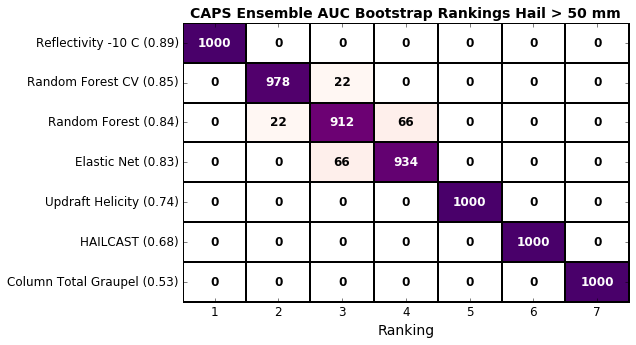

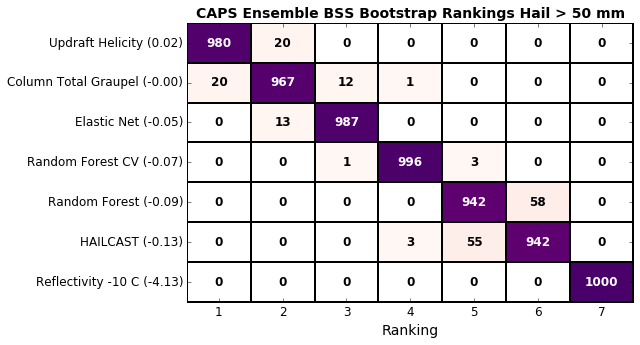

In [429]:

boot_rank_table(boot_aucs, long_model_names, "CAPS Ensemble AUC Bootstrap Rankings Hail > 50 mm", 
                "/sharp/djgagne/hail_dissertation_figures/caps_boot_auc_rank_50.pdf")
boot_rank_table(boot_bss, long_model_names, "CAPS Ensemble BSS Bootstrap Rankings Hail > 50 mm", 
                "/sharp/djgagne/hail_dissertation_figures/caps_boot_bss_rank_50.pdf")

boot_auc_ranks = np.argsort(boot_aucs, axis=0)
print boot_aucs[:,0]
print boot_auc_ranks[:, 0]
boot_auc_rank_counts = np.zeros((len(fore_vars), len(fore_vars)), dtype=int)
for f, fore_var in enumerate(fore_vars):
    boot_auc_rank_counts[f] = [np.count_nonzero(boot_auc_ranks[r]==f) for r in range(len(fore_vars))]
    print "%16s %+0.3f" % (fore_var, boot_aucs[f].mean()), boot_auc_rank_counts[f]

boot_bss_ranks = np.argsort(boot_bss, axis=0)
print boot_bss[:,0]
print boot_bss_ranks[:, 0]
for f, fore_var in enumerate(fore_vars):
    print "%16s %+0.3f" % (fore_var, boot_bss[f].mean()), 
    [np.count_nonzero(boot_bss_ranks[r]==f) for r in range(len(fore_vars)-1,-1,-1)]  

In [151]:
class DistributedROC(object):
    """
    ROC sparse representation that can be aggregated and can generate ROC curves and performance diagrams.
    A DistributedROC object is given a specified set of thresholds (could be probability or real-valued) and then
    stores a pandas DataFrame of contingency tables for each threshold. The contingency tables are updated with a
    set of forecasts and observations, but the original forecast and observation values are not kept. DistributedROC
    objects can be combined by adding them together or by storing them in an iterable and summing the contents of the
    iterable together. This is especially useful when verifying large numbers of cases in parallel.
    Attributes:
        thresholds (numpy.ndarray): List of probability thresholds in increasing order.
        obs_threshold (float):  Observation values >= obs_threshold are positive events.
        contingency_tables (pandas.DataFrame): Stores contingency table counts for each probability threshold
    Examples:
        >>>import numpy as np
        >>>forecasts = np.random.random(size=1000)
        >>>obs = np.random.random_integers(0, 1, size=1000)
        >>>roc = DistributedROC(thresholds=np.arange(0, 1.1, 0.1), obs_threshold=1)
        >>>roc.update(forecasts, obs)
        >>>print(roc.auc())
    """
    def __init__(self, thresholds=np.arange(0, 1.1, 0.1), obs_threshold=1.0, input_str=None):
        """
        Initializes the DistributedROC object. If input_str is not None, then the DistributedROC object is
         initialized with the contents of input_str. Otherwise an empty contingency table is created.
        Args:
            thresholds (numpy.array): Array of thresholds in increasing order.
            obs_threshold (float): Split threshold (>= is positive event) (< is negative event)
            input_str (None or str): String containing information for DistributedROC
        """
        self.thresholds = thresholds
        self.obs_threshold = obs_threshold
        self.contingency_tables = pd.DataFrame(np.zeros((thresholds.size, 4), dtype=int),
                                               columns=["TP", "FP", "FN", "TN"])
        if input_str is not None:
            self.from_str(input_str)

    def update(self, forecasts, observations):
        """
        Update the ROC curve with a set of forecasts and observations
        Args:
            forecasts: 1D array of forecast values
            observations: 1D array of observation values.
        """
        for t, threshold in enumerate(self.thresholds):
            pos_fore = (forecasts >= threshold)
            pos_obs = (observations >= self.obs_threshold)
            self.contingency_tables.loc[t, "TP"] += np.count_nonzero(pos_fore & pos_obs)
            self.contingency_tables.loc[t, "FP"] += np.count_nonzero(pos_fore & ~pos_obs)
            self.contingency_tables.loc[t, "FN"] += np.count_nonzero(~pos_fore & pos_obs)
            self.contingency_tables.loc[t, "TN"] += np.count_nonzero(~pos_fore & ~pos_obs)

    def clear(self):
        self.contingency_tables.loc[:, :] = 0
    
    def __add__(self, other):
        """
        Add two DistributedROC objects together and combine their contingency table values.
        Args:
            other: Another DistributedROC object.
        """
        sum_roc = DistributedROC(self.thresholds, self.obs_threshold)
        sum_roc.contingency_tables = self.contingency_tables + other.contingency_tables
        return sum_roc

    def merge(self, other_roc):
        """
        Ingest the values of another DistributedROC object into this one and update the statistics inplace.
        Args:
            other_roc: another DistributedROC object.
        """
        if other_roc.thresholds.size == self.thresholds.size and np.all(other_roc.thresholds == self.thresholds):
            self.contingency_tables += other_roc.contingency_tables
        else:
            print("Input table thresholds do not match.")

    def roc_curve(self):
        """
        Generate a ROC curve from the contingency table by calculating the probability of detection (TP/(TP+FN)) and the
        probability of false detection (FP/(FP+TN)).
        Returns:
            A pandas.DataFrame containing the POD, POFD, and the corresponding probability thresholds.
        """
        pod = self.contingency_tables["TP"].astype(float) / (self.contingency_tables["TP"] +
                                                             self.contingency_tables["FN"])
        pofd = self.contingency_tables["FP"].astype(float) / (self.contingency_tables["FP"] +
                                                              self.contingency_tables["TN"])
        return pd.DataFrame({"POD": pod, "POFD": pofd, "Thresholds": self.thresholds},
                            columns=["POD", "POFD", "Thresholds"])

    def performance_curve(self):
        """
        Calculate the Probability of Detection and False Alarm Ratio in order to output a performance diagram.
        Returns:
            pandas.DataFrame containing POD, FAR, and probability thresholds.
        """
        pod = self.contingency_tables["TP"] / (self.contingency_tables["TP"] + self.contingency_tables["FN"])
        far = self.contingency_tables["FP"] / (self.contingency_tables["FP"] + self.contingency_tables["TP"])
        far[(self.contingency_tables["FP"] + self.contingency_tables["TP"]) == 0] = np.nan
        return pd.DataFrame({"POD": pod, "FAR": far, "Thresholds": self.thresholds},
                            columns=["POD", "FAR", "Thresholds"])

    def auc(self):
        """
        Calculate the Area Under the ROC Curve (AUC).
        """
        roc_curve = self.roc_curve()
        return np.abs(np.trapz(roc_curve['POD'], x=roc_curve['POFD']))

    def max_csi(self):
        """
        Calculate the maximum Critical Success Index across all probability thresholds
        Returns:
            The maximum CSI as a float
        """
        csi = self.contingency_tables["TP"] / (self.contingency_tables["TP"] + self.contingency_tables["FN"] +
                                               self.contingency_tables["FP"])
        return csi.max()

    def get_contingency_tables(self):
        """
        Create an Array of ContingencyTable objects for each probability threshold.
        Returns:
            Array of ContingencyTable objects
        """
        return np.array([ContingencyTable(*ct) for ct in self.contingency_tables.values])

    def __str__(self):
        """
        Output the information within the DistributedROC object to a string.
        """
        out_str = "Obs_Threshold:{0:0.2f}".format(self.obs_threshold) + ";"
        out_str += "Thresholds:" + " ".join(["{0:0.2f}".format(t) for t in self.thresholds]) + ";"
        for col in self.contingency_tables.columns:
            out_str += col + ":" + " ".join(["{0:d}".format(t) for t in self.contingency_tables[col]]) + ";"
        out_str = out_str.rstrip(";")
        return out_str

    def __repr__(self):
        return self.__str__()

    def from_str(self, in_str):
        """
        Read the DistributedROC string and parse the contingency table values from it.
        Args:
            in_str (str): The string output from the __str__ method
        """
        parts = in_str.split(";")
        for part in parts:
            var_name, value = part.split(":")
            if var_name == "Obs_Threshold":
                self.obs_threshold = float(value)
            elif var_name == "Thresholds":
                self.thresholds = np.array(value.split(), dtype=float)
                self.contingency_tables = pd.DataFrame(columns=self.contingency_tables.columns,
                                                       data=np.zeros((self.thresholds.size,
                                                                     self.contingency_tables.columns.size)))
            elif var_name in self.contingency_tables.columns:
                self.contingency_tables[var_name] = np.array(value.split(), dtype=int)

def permutation_test_auc(forecast_data, model_a_col, model_b_col, obs_col, n_perm, fore_thresh):
    forecast_a = forecast_data[model_a_col].values
    forecast_b = forecast_data[model_b_col].values
    obs = forecast_data[obs_col].values
    roc_a = DistributedROC(thresholds=fore_thresh)
    roc_b = DistributedROC(thresholds=fore_thresh)
    #rel_a = DistributedReliability(thresholds=fore_thresh)
    #rel_b = DistributedReliability(thresholds=fore_thresh)
    roc_a.update(forecast_a, obs)
    roc_b.update(forecast_b, obs)
    #rel_a.update(forecast_a, obs)
    #rel_b.update(forecast_b, obs)
    auc_diff = roc_a.auc() - roc_b.auc()
    #bs_diff = rel_a.brier_score() - rel_b.brier_score()
    print auc_diff
    sample_auc_diffs = np.zeros(n_perm)
    #sample_bs_diffs = np.zeros(n_perm)
    roc_s_a = DistributedROC(thresholds=fore_thresh)
    roc_s_b = DistributedROC(thresholds=fore_thresh)

    for p in range(n_perm):
        if p % 50 == 0:
            print p,
        samples = np.random.randint(2, size=obs.size)
        sample_fore_a = np.where(samples == 1, forecast_a, forecast_b)
        sample_fore_b = np.where(samples == 0, forecast_a, forecast_b)
        roc_s_a.update(sample_fore_a, obs)
        roc_s_b.update(sample_fore_b, obs)
        sample_auc_diffs[p] = roc_s_a.auc() - roc_s_b.auc()
        roc_s_a.clear()
        roc_s_b.clear()
        #rel_s_a = DistributedReliability(thresholds=fore_thresh)
        #rel_s_a.update(sample_fore_a, obs)
        #rel_s_b = DistributedReliability(thresholds=fore_thresh)
        #rel_s_b.update(sample_fore_b, obs)
        #sample_bs_diffs[p] = rel_s_a.brier_score() - rel_s_b.brier_score()
    print ""
    return percentileofscore(sample_auc_diffs, auc_diff)

def permutation_test_bs(forecast_data, model_a_col, model_b_col, obs_col, n_perm):
    forecast_a = forecast_data[model_a_col].values
    forecast_b = forecast_data[model_b_col].values
    obs = forecast_data[obs_col].values
    bs_a = np.mean((forecast_a - obs)**2)
    bs_b = np.mean((forecast_b - obs)**2)
    bs_diff = bs_a - bs_b
    print bs_a, bs_b, bs_diff
    sample_bs_diffs = np.zeros(n_perm)
    for p in range(n_perm):
        if p % 50 == 0:
            print p,
            samples = np.random.randint(2, size=obs.size)
        sample_fore_a = np.where(samples == 1, forecast_a, forecast_b)
        sample_fore_b = np.where(samples == 0, forecast_a, forecast_b)
        bs_s_a = np.mean((sample_fore_a - obs)**2)
        bs_s_b = np.mean((sample_fore_b - obs)**2)
        sample_bs_diffs[p] = bs_s_a - bs_s_b
    print ""
    print sample_bs_diffs.min(), sample_bs_diffs.max()
    return percentileofscore(sample_bs_diffs, bs_diff)

In [56]:
print aucs['mean']
np.argsort(aucs["mean"].values)
print rels['mean']

uh_max              0.782672
cqgmax              0.826813
hailsz              0.835737
r10cmx              0.867690
Random-Forest       0.769442
Random-Forest-CV    0.769277
Elastic-Net         0.769033
Name: mean, dtype: float64
uh_max              0.037853
cqgmax              0.039395
hailsz              0.044283
r10cmx              0.045428
Random-Forest       0.037219
Random-Forest-CV    0.037215
Elastic-Net         0.037198
Name: mean, dtype: float64


In [129]:
obs_var = "MESH_Max_60min_00.50_25"
bs_pvalues = np.zeros((len(fore_vars), len(fore_vars)))
print fore_vars
ordering = np.argsort(rels["mean"].values)
fore_vars = np.array(fore_vars)
thresh = np.array(thresh)
print fore_vars[ordering]
for f, fore_var_a in enumerate(fore_vars[ordering]):
    for g, fore_var_b in enumerate(fore_vars[ordering][f+1:]):
        print fore_var_a, fore_var_b
        fore_var_a_long = "SSEF_{0}_{1}_{2:d}".format(fore_var_a, "mean", thresh[ordering][f])
        fore_var_b_long = "SSEF_{0}_{1}_{2:d}".format(fore_var_b, "mean", thresh[ordering][f+g+1])
        bs_pvalues[f, f+g+1] = permutation_test_bs(us_eval, fore_var_a_long, fore_var_b_long, obs_var, 1000) 
        print bs_pvalues[f, f+g+1]

['uh_max', 'cqgmax', 'hailsz', 'r10cmx', 'Random-Forest', 'Random-Forest-CV', 'Elastic-Net']
['Random-Forest' 'Elastic-Net' 'Random-Forest-CV' 'uh_max' 'cqgmax'
 'hailsz' 'r10cmx']
Random-Forest Elastic-Net
0.0368028262444 0.0367703160711 3.25101732612e-05
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
-1.05210896268e-05 2.02156507259e-05
100.0
Random-Forest Random-Forest-CV
0.0368028262444 0.0368018602542 9.65990115349e-07
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
-6.32849188817e-06 4.43994512604e-06
60.0
Random-Forest uh_max
0.0368028262444 0.0372716297136 -0.000468803469292
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
-0.000656381134034 0.000304216843873
5.0
Random-Forest cqgmax
0.0368028262444 0.0395184568145 -0.00271563057017
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
-0.000425164722425 0.000433847981609
0.0
Random-Forest hailsz
0.0368028262444 0.0

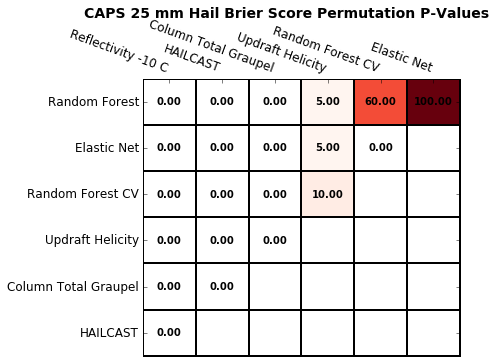

In [133]:
plt.figure(figsize=(5,5))
plt.subplots_adjust(0.1, 0.02, 0.98, 0.79)
long_model_names = np.array(["Updraft Helicity", "Column Total Graupel", "HAILCAST", "Reflectivity -10 C", "Random Forest",
                    "Random Forest CV", "Elastic Net"])
plt.pcolormesh(np.ma.array(bs_pvalues[::-1][:, ::-1], mask=bs_pvalues[::-1][:, ::-1]==0), cmap="Reds", edgecolors='k')
plt.gca().xaxis.tick_top()
plt.yticks(np.arange(7) + 0.5, long_model_names[ordering[::-1]], fontsize=12)
plt.xticks(np.arange(7) + 0.5, long_model_names[ordering[::-1]], rotation=-20, ha="right", fontsize=12)

for (r,c), pv in np.ndenumerate(bs_pvalues[::-1][:, ::-1]):
    if r > c:
        plt.text(c+0.5, r+0.5, "%0.2f" % (pv),ha="center", va="center", color="k", fontweight="bold")
plt.xlim(0,6)
plt.ylim(1,7)
plt.suptitle("CAPS 25 mm Hail Brier Score Permutation P-Values", y=0.99, fontweight="bold", fontsize=14)
plt.savefig("/sharp/djgagne/hail_dissertation_figures/caps_hail_bs_pvalues_25.pdf", bbox_inches="tight")

In [135]:
obs_var = "MESH_Max_60min_00.50_50"
bs_pvalues_50 = np.zeros((len(fore_vars), len(fore_vars)))
print fore_vars
ordering = np.argsort(rels["mean"].values)
fore_vars = np.array(fore_vars)
thresh = np.array(thresh)
print fore_vars[ordering]
for f, fore_var_a in enumerate(fore_vars[ordering]):
    for g, fore_var_b in enumerate(fore_vars[ordering][f+1:]):
        print fore_var_a, fore_var_b
        fore_var_a_long = "SSEF_{0}_{1}_{2:d}".format(fore_var_a, "mean", thresh[ordering][f])
        fore_var_b_long = "SSEF_{0}_{1}_{2:d}".format(fore_var_b, "mean", thresh[ordering][f+g+1])
        bs_pvalues_50[f, f+g+1] = permutation_test_bs(us_eval, fore_var_a_long, fore_var_b_long, obs_var, 1000) 
        print bs_pvalues_50[f, f+g+1]

['uh_max', 'cqgmax', 'hailsz', 'r10cmx', 'Random-Forest', 'Random-Forest-CV', 'Elastic-Net']
['uh_max' 'cqgmax' 'Elastic-Net' 'Random-Forest-CV' 'Random-Forest'
 'hailsz' 'r10cmx']
uh_max cqgmax
0.00603063630009 0.00612889275558 -9.82564554905e-05
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
-0.000136050147029 0.000167323201627
5.0
uh_max Elastic-Net
0.00603063630009 0.00667254222385 -0.000641905923762
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
-0.000186042950638 0.000269268502898
0.0
uh_max Random-Forest-CV
0.00603063630009 0.00685821968526 -0.000827583385173
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
-0.000204626230193 0.000132644864388
0.0
uh_max Random-Forest
0.00603063630009 0.00701846853758 -0.000987832237495
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
-0.000346968538064 0.000339820227378
0.0
uh_max hailsz
0.00603063630009 0.00715119472911 -0.00

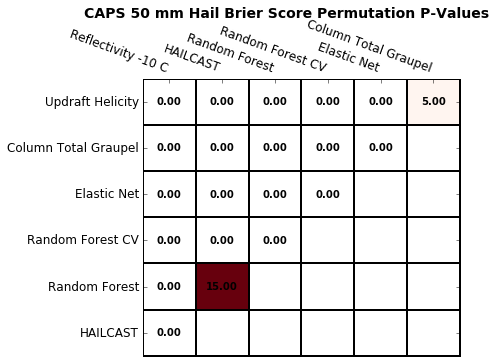

In [136]:
plt.figure(figsize=(5,5))
plt.subplots_adjust(0.1, 0.02, 0.98, 0.79)
long_model_names = np.array(["Updraft Helicity", "Column Total Graupel", "HAILCAST", "Reflectivity -10 C", "Random Forest",
                    "Random Forest CV", "Elastic Net"])
plt.pcolormesh(np.ma.array(bs_pvalues_50[::-1][:, ::-1], mask=bs_pvalues_50[::-1][:, ::-1]==0), 
               cmap="Reds", edgecolors='k', vmin=0, vmax=50)
plt.gca().xaxis.tick_top()
plt.yticks(np.arange(7) + 0.5, long_model_names[ordering[::-1]], fontsize=12)
plt.xticks(np.arange(7) + 0.5, long_model_names[ordering[::-1]], rotation=-20, ha="right", fontsize=12)

for (r,c), pv in np.ndenumerate(bs_pvalues_50[::-1][:, ::-1]):
    if r > c:
        plt.text(c+0.5, r+0.5, "%0.2f" % (pv),ha="center", va="center", color="k", fontweight="bold")
plt.xlim(0,6)
plt.ylim(1,7)
plt.suptitle("CAPS 50 mm Hail Brier Score Permutation P-Values", y=0.99, fontweight="bold", fontsize=14)
plt.savefig("/sharp/djgagne/hail_dissertation_figures/caps_hail_bs_pvalues_50.pdf", bbox_inches="tight")

In [180]:
obs_var = "MESH_Max_60min_00.50_25"
auc_pvalues_caps_25 = np.zeros((len(fore_vars), len(fore_vars)))
print fore_vars
ordering = np.argsort(aucs["mean"].values)[::-1]
fore_vars = np.array(fore_vars)
thresh = np.array(thresh)
print fore_vars[ordering]
for f, fore_var_a in enumerate(fore_vars[ordering]):
    for g, fore_var_b in enumerate(fore_vars[ordering][f+1:]):
        print fore_var_a, fore_var_b
        fore_var_a_long = "SSEF_{0}_{1}_{2:d}".format(fore_var_a, "mean", thresh[ordering][f])
        fore_var_b_long = "SSEF_{0}_{1}_{2:d}".format(fore_var_b, "mean", thresh[ordering][f+g+1])
        auc_pvalues_caps_25[f, f+g+1] = permutation_test_auc(us_eval, fore_var_a_long, fore_var_b_long, obs_var, 1000, 
                                                     np.concatenate([[0,0.01, 0.05], np.arange(0.1, 1.1, 0.1)])) 
        print auc_pvalues_caps_25[f, f+g+1]

['uh_max', 'cqgmax', 'hailsz', 'r10cmx', 'Random-Forest', 'Random-Forest-CV', 'Elastic-Net']
['r10cmx' 'hailsz' 'cqgmax' 'uh_max' 'Random-Forest-CV' 'Elastic-Net'
 'Random-Forest']
r10cmx hailsz
0.0180859096857
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
r10cmx cqgmax
0.0192946545198
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
r10cmx uh_max
0.0511270959181
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
r10cmx Random-Forest-CV
0.0652506758712
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
r10cmx Elastic-Net
0.0652995705846
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
r10cmx Random-Forest
0.0655105346568
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
hailsz cqgmax
0.00120874483404
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
72.3

In [174]:
obs_var = "MESH_Max_60min_00.50_50"
auc_pvalues_50 = np.zeros((len(fore_vars), len(fore_vars)))
print fore_vars
ordering = np.argsort(aucs["mean"].values)[::-1]
fore_vars = np.array(fore_vars)
thresh = np.array(thresh)
print fore_vars[ordering]
for f, fore_var_a in enumerate(fore_vars[ordering]):
    for g, fore_var_b in enumerate(fore_vars[ordering][f+1:]):
        print fore_var_a, fore_var_b
        fore_var_a_long = "SSEF_{0}_{1}_{2:d}".format(fore_var_a, "mean", thresh[ordering][f])
        fore_var_b_long = "SSEF_{0}_{1}_{2:d}".format(fore_var_b, "mean", thresh[ordering][f+g+1])
        auc_pvalues_50[f, f+g+1] = permutation_test_auc(us_eval, fore_var_a_long, fore_var_b_long, obs_var, 1000, 
                                                     np.concatenate([[0,0.01, 0.05], np.arange(0.1, 1.1, 0.1)])) 
        print auc_pvalues_50[f, f+g+1]

['uh_max', 'cqgmax', 'hailsz', 'r10cmx', 'Random-Forest', 'Random-Forest-CV', 'Elastic-Net']
['Random-Forest-CV' 'Elastic-Net' 'Random-Forest' 'r10cmx' 'uh_max'
 'hailsz' 'cqgmax']
Random-Forest-CV Elastic-Net
0.00327232102548
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
79.5
Random-Forest-CV Random-Forest
0.00720650930602
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
96.7
Random-Forest-CV r10cmx
0.0199893367071
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
99.1
Random-Forest-CV uh_max
0.0732359688145
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
Random-Forest-CV hailsz
0.152022147002
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
Random-Forest-CV cqgmax
0.311859072372
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
Elastic-Net Random-Forest
0.00393418828054
0 50 100 150 200 250 30

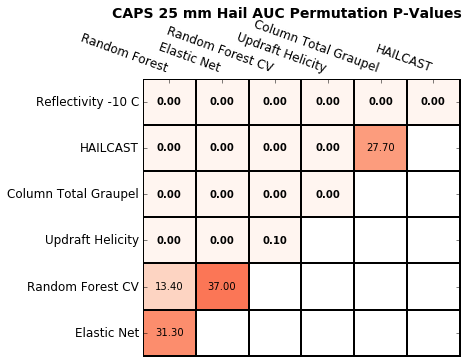

In [187]:
plt.figure(figsize=(5,5))
plt.subplots_adjust(0.1, 0.02, 0.98, 0.79)
long_model_names = np.array(["Updraft Helicity", "Column Total Graupel", "HAILCAST", "Reflectivity -10 C", "Random Forest",
                    "Random Forest CV", "Elastic Net"])
plt.pcolormesh(np.ma.array(100-auc_pvalues_caps_25[::-1][:, ::-1], mask=auc_pvalues_caps_25[::-1][:, ::-1]==0), cmap="Reds", 
               edgecolors='k', vmin=0, vmax=80)
plt.gca().xaxis.tick_top()
plt.yticks(np.arange(7) + 0.5, long_model_names[ordering[::-1]], fontsize=12)
plt.xticks(np.arange(7) + 0.5, long_model_names[ordering[::-1]], rotation=-20, ha="right", fontsize=12)

for (r,c), pv in np.ndenumerate(auc_pvalues_caps_25[::-1][:, ::-1]):
    if r > c:
        if 100-pv < 3:
            plt.text(c+0.5, r+0.5, "%0.2f" % (100-pv),ha="center", va="center", color="k", fontweight="bold")
        else:
            plt.text(c+0.5, r+0.5, "%0.2f" % (100-pv),ha="center", va="center", color="k")
plt.xlim(0,6)
plt.ylim(1,7)
plt.suptitle("CAPS 25 mm Hail AUC Permutation P-Values", y=0.99, fontweight="bold", fontsize=14)
plt.savefig("/sharp/djgagne/hail_dissertation_figures/caps_hail_auc_pvalues_25.pdf", bbox_inches="tight")

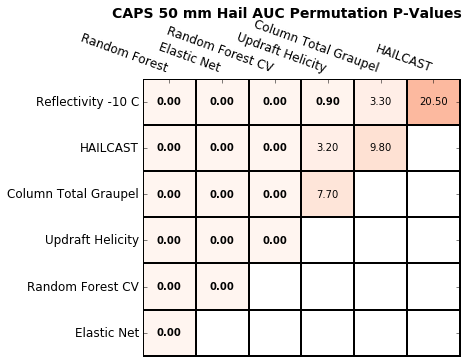

In [188]:
plt.figure(figsize=(5,5))
plt.subplots_adjust(0.1, 0.02, 0.98, 0.79)
long_model_names = np.array(["Updraft Helicity", "Column Total Graupel", "HAILCAST", "Reflectivity -10 C", "Random Forest",
                    "Random Forest CV", "Elastic Net"])
plt.pcolormesh(np.ma.array(100-auc_pvalues_50[::-1][:, ::-1], mask=auc_pvalues_50[::-1][:, ::-1]==0), cmap="Reds", 
               edgecolors='k', vmin=0, vmax=80)
plt.gca().xaxis.tick_top()
plt.yticks(np.arange(7) + 0.5, long_model_names[ordering[::-1]], fontsize=12)
plt.xticks(np.arange(7) + 0.5, long_model_names[ordering[::-1]], rotation=-20, ha="right", fontsize=12)

for (r,c), pv in np.ndenumerate(auc_pvalues_50[::-1][:, ::-1]):
    if r > c:
        if 100-pv < 3:
            plt.text(c+0.5, r+0.5, "%0.2f" % (100-pv),ha="center", va="center", color="k", fontweight="bold")
        else:
            plt.text(c+0.5, r+0.5, "%0.2f" % (100-pv),ha="center", va="center", color="k")
plt.xlim(0,6)
plt.ylim(1,7)
plt.suptitle("CAPS 50 mm Hail AUC Permutation P-Values", y=0.99, fontweight="bold", fontsize=14)
plt.savefig("/sharp/djgagne/hail_dissertation_figures/caps_hail_auc_pvalues_50.pdf", bbox_inches="tight")

(0, 5)

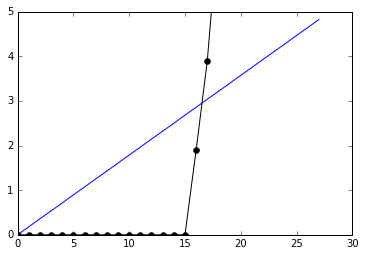

In [119]:
valid_pvalues = 100 - auc_pvalues_50[np.triu_indices(auc_pvalues_50.shape[0])]
fdr = np.arange(valid_pvalues.size) / float(valid_pvalues.size) * 5
plt.plot(np.sort(valid_pvalues), 'ko-')
plt.plot(fdr)
plt.ylim(0,5)

In [16]:

obs = us_eval["MESH_Max_60min_00.50_50"]
thresh = [150, 50, 50, 60, 50, 50, 50]
long_model_names = ["Updraft Helicity", "Column Total Graupel", "HAILCAST", "Reflectivity -10 C", "Random Forest",
                    "Random Forest CV", "Elastic Net"]
obs = us_eval["MESH_Max_60min_00.50_50"]
roc_objs = []
rel_objs = []
model_name_score = []
model_name_auc = []
model_name_csi = []
for f, fore_var in enumerate(fore_vars):
    fore = us_eval["SSEF_{0}_{1}_{2:d}".format(fore_var, "mean", thresh[f])].values
    rel_objs.append(DistributedReliability(thresholds=fore_thresh))
    roc_objs.append(DistributedROC(thresholds=fore_thresh))
    rel_objs[-1].update(fore, obs)
    roc_objs[-1].update(fore, obs)
    print fore_var, rel_objs[-1].brier_skill_score(), roc_objs[-1].auc(), roc_objs[-1].max_csi()
    model_name_score.append(long_model_names[f] + " ({0:0.2f})".format(rel_objs[-1].brier_skill_score()))
    model_name_auc.append(long_model_names[f] + " ({0:0.2f})".format(roc_objs[-1].auc()))
    model_name_csi.append(long_model_names[f] + " ({0:0.2f})".format(roc_objs[-1].max_csi()))
colors = ["red", "blue", "green", "orange", "purple", "cyan", "yellow"]
markers = ["*", "*", "*", "*", "v", "v", "v"]
attributes_diagram(rel_objs, model_name_score, colors, markers, "/sharp/djgagne/hail_dissertation_figures/caps_mean_hail_rel_50.pdf", 
                      figsize=(8, 8), xlabel="Forecast Probability",
                       ylabel="Observed Relative Frequency", ticks=np.arange(0, 1.05, 0.05), dpi=300, 
                       title="CAPS Ensemble Probability Hail > 50 mm Reliability", legend_params=dict(loc=0, fontsize=10), inset_params=None,
                       inset_position=(0.1, 0.45, 0.25, 0.25), bootstrap_sets=None, ci=(2.5, 97.5))
roc_curve(roc_objs, model_name_auc, colors, markers, "/sharp/djgagne/hail_dissertation_figures/caps_mean_hail_roc_50.pdf",
          legend_params=dict(loc=0, fontsize=10), title="CAPS Ensemble Probability Hail > 50 mm ROC Curves")
performance_diagram(roc_objs, model_name_csi, colors, markers, "/sharp/djgagne/hail_dissertation_figures/caps_mean_hail_perf_50.pdf",
          legend_params=dict(loc=0, fontsize=10), title="CAPS Ensemble Probability Hail > 50 mm Performance")

NameError: name 'fore_vars' is not defined

In [316]:
roc_objs = []
rel_objs = []
obs = us_eval["MESH_Max_60min_00.50_25"]
thresh = [75, 25, 25, 60, 25, 25, 25]
long_model_names = ["Updraft Helicity", "Column Total Graupel", "HAILCAST", "Reflectivity -10 C", "Random Forest",
                    "Random Forest CV", "Elastic Net"]
model_name_score = []
model_name_auc = []
model_name_csi = []
for f, fore_var in enumerate(fore_vars):
    fore = us_eval["SSEF_{0}_{1}_{2:d}".format(fore_var, "mean", thresh[f])].values
    rel_objs.append(DistributedReliability(thresholds=fore_thresh))
    roc_objs.append(DistributedROC(thresholds=fore_thresh))
    rel_objs[-1].update(fore, obs)
    roc_objs[-1].update(fore, obs)
    print fore_var, rel_objs[-1].brier_skill_score(), roc_objs[-1].auc(), roc_objs[-1].max_csi()
    model_name_score.append(long_model_names[f] + " ({0:0.2f})".format(rel_objs[-1].brier_skill_score()))
    model_name_auc.append(long_model_names[f] + " ({0:0.2f})".format(roc_objs[-1].auc()))
    model_name_csi.append(long_model_names[f] + " ({0:0.2f})".format(roc_objs[-1].max_csi()))
colors = ["red", "blue", "green", "orange", "purple", "cyan", "yellow"]
markers = ["*", "*", "*", "*", "v", "v", "v"]


uh_max 0.138270064883 0.776212567792 0.242027800491
cqgmax 0.104197527419 0.823240187696 0.203694874851
hailsz -0.00669671161612 0.835776913727 0.21588188348
r10cmx -0.0231584458469 0.86095630401 0.205897771953
Random-Forest 0.15351256426 0.76836984756 0.262330354187
Random-Forest-CV 0.153733793062 0.768365594401 0.262896002654
Elastic-Net 0.15426292613 0.768506015048 0.262224432289


In [342]:
attributes_diagram(rel_objs, model_name_score, colors, markers, "/sharp/djgagne/hail_dissertation_figures/caps_mean_hail_rel_25.pdf", 
                      figsize=(8, 8), xlabel="Forecast Probability",
                       ylabel="Observed Relative Frequency", ticks=np.arange(0, 1.05, 0.05), dpi=300, 
                       title="CAPS Ensemble Probability Hail > 25 mm Reliability", legend_params=dict(loc=0, fontsize=10), inset_params=None,
                       inset_position=(0.1, 0.45, 0.25, 0.25), bootstrap_sets=None, ci=(2.5, 97.5))
roc_curve(roc_objs, model_name_auc, colors, markers, "/sharp/djgagne/hail_dissertation_figures/caps_mean_hail_roc_25.pdf",
          legend_params=dict(loc=0, fontsize=10), title="CAPS Ensemble Probability Hail > 25 mm ROC Curves")
performance_diagram(roc_objs, model_name_csi, colors, markers, "/sharp/djgagne/hail_dissertation_figures/caps_mean_hail_perf_25.pdf",
          legend_params=dict(loc=0, fontsize=10), title="CAPS Ensemble Probability Hail > 25 mm Performance")


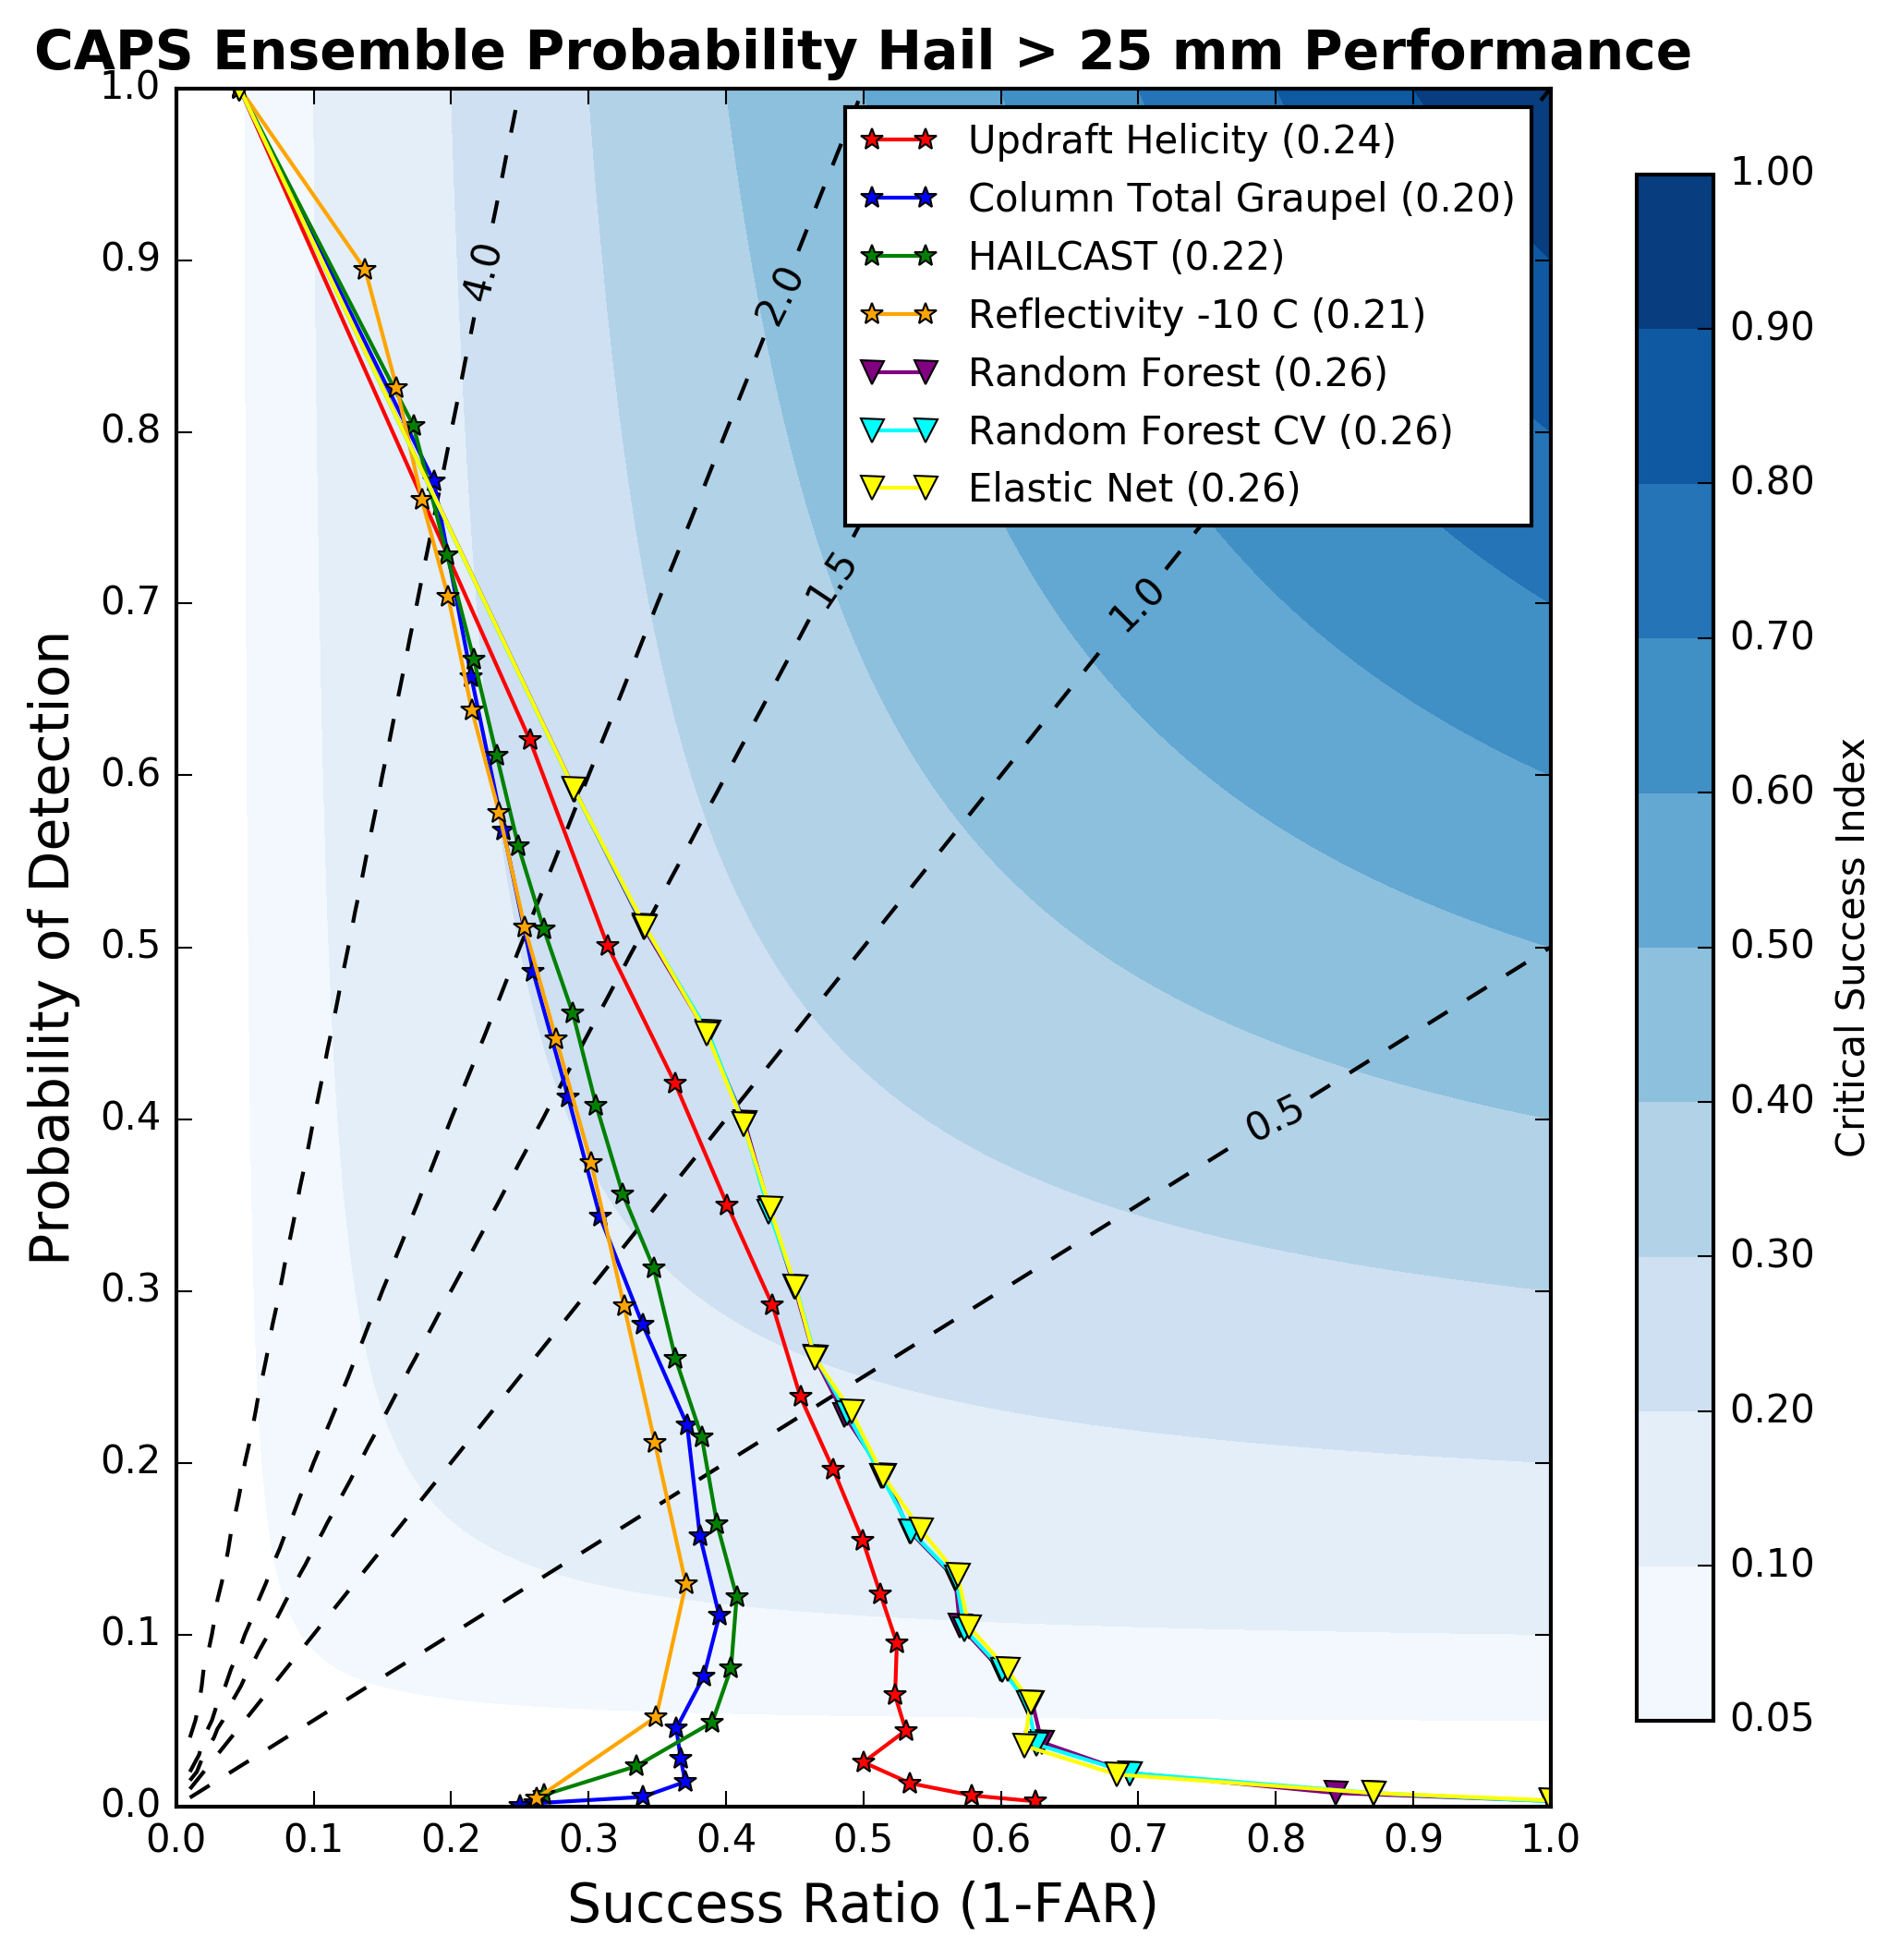

In [341]:
Image( "/sharp/djgagne/hail_dissertation_figures/caps_mean_hail_perf_25.png", width=500)

In [266]:
model_name_auc.append(long_model_names[f] + " ({0:0.2f})".format(roc_objs[-1].auc()))

1 loops, best of 3: 1 s per loop


In [293]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from mpl_toolkits.axes_grid.inset_locator import InsetPosition

def roc_curve(roc_objs, obj_labels, colors, markers, filename, figsize=(8, 8),
              xlabel="Probability of False Detection",
              ylabel="Probability of Detection",
              title="ROC Curve", ticks=np.arange(0, 1.1, 0.1), dpi=300,
              legend_params=None, bootstrap_sets=None, ci=(2.5, 97.5)):
    """
    Plots a set receiver/relative operating characteristic (ROC) curves from DistributedROC objects.

    The ROC curve shows how well a forecast discriminates between two outcomes over a series of thresholds. It
    features Probability of Detection (True Positive Rate) on the y-axis and Probability of False Detection
    (False Alarm Rate) on the x-axis. This plotting function allows one to customize the colors and markers of the
    ROC curves as well as the parameters of the legend and the title.

    Args:
        roc_objs (list): DistributedROC objects being plotted.
        obj_labels (list): Label describing the forecast associated with a DistributedROC object.
        colors (list): List of matplotlib-readable colors (names or hex-values) for each curve.
        markers (list): Matplotlib marker (e.g. *, o, v, etc.) for each curve.
        filename (str): Name of figure file being saved.
        figsize (tuple): (Width, height) of the figure in inches.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): The title of the figure.
        ticks (numpy.ndarray): Values shown on the x and y axes.
        dpi (int): Figure resolution in dots per inch.
        legend_params (None or dict): Keyword arguments for the formatting of the figure legend.

    Examples:

        >>> from hagelslag.evaluation import DistributedROC
        >>> import numpy as np
        >>> forecasts = np.random.random(1000)
        >>> obs = np.random.random_integers(0, 1, 1000)
        >>> roc = DistributedROC()
        >>> roc.update(forecasts, obs)
        >>> roc_curve([roc], ["Random"], ["orange"], ["o"], "random_roc.png")
    """
    if legend_params is None:
        legend_params = dict(loc=4, fontsize=10, framealpha=1, frameon=True)
    plt.figure(figsize=figsize, dpi=dpi)
    plt.plot(ticks, ticks, "k--")
    if bootstrap_sets is not None:
        for b, b_set in enumerate(bootstrap_sets):
            broc_curves = np.dstack([b_roc.roc_curve().values for b_roc in b_set])
            pod_range = np.percentile(broc_curves[:,0], ci, axis=1)
            pofd_range = np.percentile(broc_curves[:, 1], ci, axis=1)
            pod_poly = np.concatenate((pod_range[1], pod_range[0, ::-1]))
            pofd_poly = np.concatenate((pofd_range[0], pofd_range[1, ::-1]))
            pod_poly[np.isnan(pod_poly)] = 0
            pofd_poly[np.isnan(pofd_poly)] = 0
            plt.fill(pofd_poly, pod_poly, alpha=0.5, color=colors[b])
    for r, roc_obj in enumerate(roc_objs):
        roc_data = roc_obj.roc_curve()
        plt.plot(roc_data["POFD"], roc_data["POD"], marker=markers[r], color=colors[r], label=obj_labels[r])
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.legend(**legend_params)
    plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    plt.close()

def attributes_diagram(rel_objs, obj_labels, colors, markers, filename, figsize=(8, 8), xlabel="Forecast Probability",
                       ylabel="Observed Relative Frequency", ticks=np.arange(0, 1.05, 0.05), dpi=300, 
                       title="Attributes Diagram", legend_params=None, inset_params=None,
                       inset_position=(0.12, 0.72, 0.25, 0.25), bootstrap_sets=None, ci=(2.5, 97.5)):
    """
    Plot reliability curves against a 1:1 diagonal to determine if probability forecasts are consistent with their
    observed relative frequency. Also adds gray areas to show where the climatological probabilities lie and what
    areas result in a positive Brier Skill Score.

    Args:
        rel_objs (list): List of DistributedReliability objects.
        obj_labels (list): List of labels describing the forecast model associated with each curve.
        colors (list): List of colors for each line
        markers (list): List of line markers
        filename (str): Where to save the figure.
        figsize (tuple): (Width, height) of the figure in inches.
        xlabel (str): X-axis label
        ylabel (str): Y-axis label
        ticks (array): Tick value labels for the x and y axes.
        dpi (int): resolution of the saved figure in dots per inch.
        title (str): Title of figure
        legend_params (dict): Keyword arguments for the plot legend.
        inset_params (dict): Keyword arguments for the inset axis.
        inset_position (tuple): Position of the inset axis in normalized axes coordinates (left, bottom, width, height)
        bootstrap_sets (list): A list of arrays of bootstrapped DistributedROC objects. If not None,
            confidence regions will be plotted.
        ci (tuple): tuple of bootstrap confidence interval percentiles
    """
    if legend_params is None:
        legend_params = dict(loc=4, fontsize=10, framealpha=1, frameon=True)
    if inset_params is None:
        inset_params = dict(width="25%", height="25%", loc=2, axes_kwargs=dict(axisbg='white'))
    fig, ax = plt.subplots(figsize=figsize)
    plt.plot(ticks, ticks, "k--")
    inset_hist = inset_axes(ax, **inset_params)
    ip = InsetPosition(ax, inset_position)
    inset_hist.set_axes_locator(ip)
    climo = rel_objs[0].climatology()
    no_skill = 0.5 * ticks + 0.5 * climo
    skill_x = [climo, climo, 1, 1, climo, climo, 0, 0, climo]
    skill_y = [climo, 1, 1, no_skill[-1], climo, 0, 0, no_skill[0], climo]
    f = ax.fill(skill_x, skill_y, "0.8")
    f[0].set_zorder(1)
    ax.plot(ticks, np.ones(ticks.shape) * climo, "k--")
    if bootstrap_sets is not None:
        for b, b_set in enumerate(bootstrap_sets):
            brel_curves = np.vstack([b_rel.reliability_curve()["Positive_Relative_Freq"].values for b_rel in b_set])
            rel_range = np.nanpercentile(brel_curves, ci, axis=0)
            fb = ax.fill_between(b_rel.thresholds[:-1], rel_range[1], rel_range[0], alpha=0.5, color=colors[b])
            fb.set_zorder(2)
    r_curve_objs = []
    for r, rel_obj in enumerate(rel_objs):
        rel_curve = rel_obj.reliability_curve()
        r_curve_objs.extend(ax.plot(rel_curve["Bin_Start"], rel_curve["Positive_Relative_Freq"], color=colors[r], marker=markers[r],
                 label=obj_labels[r]))
        inset_hist.semilogy(rel_curve["Bin_Start"] * 100, rel_obj.frequencies["Total_Freq"][:-1], color=colors[r],
                            marker=markers[r])
    inset_hist.set_xlabel("Forecast Probability")
    inset_hist.set_ylabel("Frequency")
    ax.annotate("No Skill", (0.6, no_skill[12]), rotation=22.5)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xticks(ticks)
    ax.set_xticklabels((ticks * 100).astype(int))
    ax.set_yticks(ticks)
    ax.set_yticklabels((ticks * 100).astype(int))
    ax.legend(**legend_params)
    ax.set_title(title, fontsize=14, fontweight="bold")
    plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    plt.close()
    
def performance_diagram(roc_objs, obj_labels, colors, markers, filename, figsize=(8, 8),
                        xlabel="Success Ratio (1-FAR)",
                        ylabel="Probability of Detection", ticks=np.arange(0, 1.1, 0.1),
                        dpi=300, csi_cmap="Blues",
                        csi_label="Critical Success Index", title="Performance Diagram",
                        legend_params=None, bootstrap_sets=None, ci=(2.5, 97.5)):
    """
    Draws a performance diagram from a set of DistributedROC objects.

    A performance diagram is a variation on the ROC curve in which the Probability of False Detection on the
    x-axis has been replaced with the Success Ratio (1-False Alarm Ratio or Precision). The diagram also shows
    the Critical Success Index (CSI or Threat Score) as a series of curved contours, and the frequency bias as
    angled diagonal lines. Points along the 1:1 diagonal are unbiased, and better performing models should appear
    in the upper right corner. The performance diagram is particularly useful for displaying verification for
    severe weather warnings as it displays all three commonly used statistics (POD, FAR, and CSI) simultaneously
    on the same chart.

    Args:
        roc_objs (list): DistributedROC objects being plotted.
        obj_labels: list or array of labels describing each DistributedROC object.
        obj_labels (list): Label describing the forecast associated with a DistributedROC object.
        colors (list): List of matplotlib-readable colors (names or hex-values) for each curve.
        markers (list): Matplotlib marker (e.g. *, o, v, etc.) for each curve.
        filename (str): Name of figure file being saved.
        figsize (tuple): (Width, height) of the figure in inches.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): The title of the figure.
        ticks (numpy.ndarray): Values shown on the x and y axes.
        dpi (int): Figure resolution in dots per inch.
        csi_cmap (str): Matplotlib colormap used to fill CSI contours.
        csi_label (str): Label for CSI colormap.
        legend_params (None or dict): Keyword arguments for the formatting of the figure legend.
        bootstrap_sets (list): A list of arrays of bootstrapped DistributedROC objects. If not None,
            confidence regions will be plotted.
        ci (tuple): tuple of bootstrap confidence interval percentiles

    Examples:

        >>> from hagelslag.evaluation import DistributedROC
        >>> import numpy as np
        >>> forecasts = np.random.random(1000)
        >>> obs = np.random.random_integers(0, 1, 1000)
        >>> roc = DistributedROC()
        >>> roc.update(forecasts, obs)
        >>> performance_diagram([roc], ["Random"], ["orange"], ["o"], "random_performance.png")
    """
    if legend_params is None:
        legend_params = dict(loc=4, fontsize=10, framealpha=1, frameon=True)
    plt.figure(figsize=figsize)
    grid_ticks = np.arange(0, 1.01, 0.01)
    sr_g, pod_g = np.meshgrid(grid_ticks, grid_ticks)
    bias = pod_g / sr_g
    csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)
    csi_contour = plt.contourf(sr_g, pod_g, csi, np.concatenate([[0.05], np.arange(0.1, 1.1, 0.1)]), cmap=csi_cmap)
    b_contour = plt.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed")
    plt.clabel(b_contour, fmt="%1.1f", manual=[(0.2, 0.9), (0.4, 0.9), (0.5, 0.7), (0.7, 0.7), (0.8, 0.4)])
    if bootstrap_sets is not None:
        for b, b_set in enumerate(bootstrap_sets):
            perf_curves = np.dstack([b_roc.performance_curve().values for b_roc in b_set])
            pod_range = np.nanpercentile(perf_curves[:, 0], ci, axis=1)
            sr_range = np.nanpercentile(1 - perf_curves[:, 1], ci, axis=1)
            pod_poly = np.concatenate((pod_range[1], pod_range[0, ::-1]))
            sr_poly = np.concatenate((sr_range[1], sr_range[0, ::-1]))
            pod_poly[np.isnan(pod_poly)] = 0
            sr_poly[np.isnan(sr_poly)] = 1
            plt.fill(sr_poly, pod_poly, alpha=0.5, color=colors[b])
    for r, roc_obj in enumerate(roc_objs):
        perf_data = roc_obj.performance_curve()
        plt.plot(1 - perf_data["FAR"], perf_data["POD"], marker=markers[r], color=colors[r], label=obj_labels[r])
    cbar = plt.colorbar(csi_contour, shrink=0.9)
    cbar.set_label(csi_label)
    cbar.set_ticks(np.concatenate([[0.05], np.arange(0.1, 1.1, 0.1)]))
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.legend(**legend_params)
    plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    plt.close()

In [268]:
%timeit boot_fore = fore[rand_idx]

1 loops, best of 3: 966 ms per loop


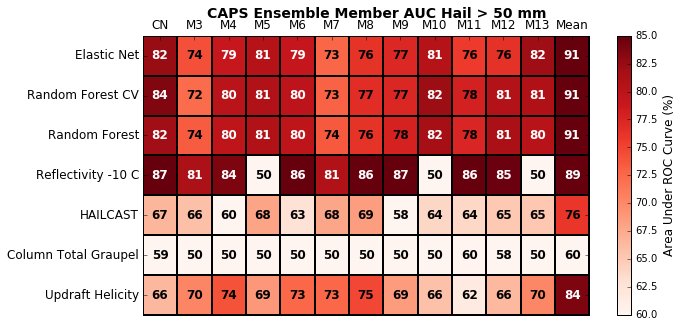

In [120]:
fig, ax = plt.subplots(figsize=(10, 5))
mem_names = ["CN"] + ["M{0:d}".format(m) for m in range(3, 14)] + ["Mean"]
plt.pcolormesh(aucs * 100, edgecolors='k', vmin=60, vmax=85, cmap="Reds")
for (r,c), v in np.ndenumerate(aucs):
    if v > 0.79:
        fontcolor="w"
    else:
        fontcolor="k"
    plt.text(c + 0.5, r + 0.5, "{0:0.0f}".format(v * 100), ha='center', va='center', 
             fontsize=12, fontweight="bold", fontdict=dict(color=fontcolor))
cbar = plt.colorbar()
cbar.set_label("Area Under ROC Curve (%)", fontsize=12)
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
plt.xticks(np.arange(len(aucs.columns)) + 0.5, mem_names, rotation=0, fontsize=12)
plt.yticks(np.arange(len(aucs.index)) + 0.5, long_model_names, fontsize=12)

plt.suptitle("CAPS Ensemble Member AUC Hail > 50 mm", fontsize=14, fontweight="bold", x=0.45)
plt.xlim(0, len(aucs.columns))
plt.savefig("/sharp/djgagne/hail_dissertation_figures/caps_hail_member_auc_50.pdf", bbox_inches="tight", dpi=300)

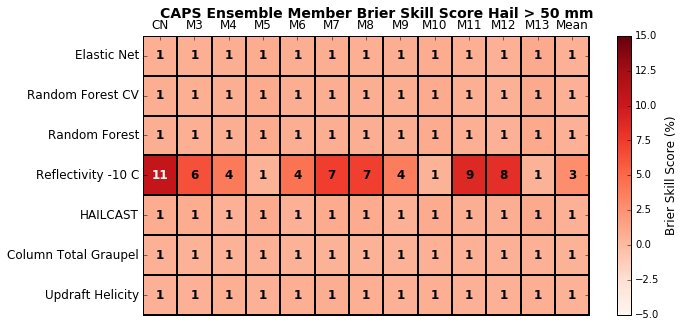

In [121]:
fig, ax = plt.subplots(figsize=(10, 5))
mem_names = ["CN"] + ["M{0:d}".format(m) for m in range(3, 14)] + ["Mean"]
plt.pcolormesh(rels * 100, vmin=-5, vmax=15, edgecolors='k', cmap="Reds")
for (r,c), v in np.ndenumerate(rels):
    if v > 0.1:
        fontcolor="w"
    else:
        fontcolor="k"
    if ~np.isnan(v):
        plt.text(c + 0.5, r + 0.5, "{0:0.0f}".format(v * 100), ha='center', va='center', 
             fontsize=12, fontweight="bold", fontdict=dict(color=fontcolor))
cbar = plt.colorbar()
cbar.set_label("Brier Skill Score (%)", fontsize=12)
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
plt.xticks(np.arange(len(aucs.columns)) + 0.5, mem_names, rotation=0, fontsize=12)
plt.yticks(np.arange(len(aucs.index)) + 0.5, long_model_names, fontsize=12)

plt.suptitle("CAPS Ensemble Member Brier Skill Score Hail > 50 mm", fontsize=14, fontweight="bold", x=0.45)
plt.xlim(0, len(aucs.columns))
plt.savefig("/sharp/djgagne/hail_dissertation_figures/caps_hail_member_bss_50.pdf", bbox_inches="tight", dpi=300)

In [218]:
rels.max()

wrf-s3cn_arw     0.071095
wrf-s3m3_arw     0.054560
wrf-s3m4_arw     0.056043
wrf-s3m5_arw     0.035294
wrf-s3m6_arw     0.072960
wrf-s3m7_arw     0.024752
wrf-s3m8_arw     0.056809
wrf-s3m9_arw     0.061323
wrf-s3m10_arw    0.035206
wrf-s3m11_arw    0.049396
wrf-s3m12_arw    0.067490
wrf-s3m13_arw    0.049907
mean             0.154373
dtype: float64

In [190]:
proj_dict, grid_dict = read_arps_map_file("/home/djgagne/hagelslag/mapfiles/ssef2015.map")
print proj_dict
print grid_dict
proj_dict["rsphere"] = proj_dict["a"]
del proj_dict["a"]
del proj_dict["b"]
del proj_dict["proj"]
del proj_dict["units"]
#bmap = Basemap(llcrnrlon=grid_dict["sw_lon"], llcrnrlat=grid_dict["sw_lat"], urcrnrlon=grid_dict["ne_lon"],
#               urcrnrlat=grid_dict["ne_lat"], resolution="l", projection="lcc",**proj_dict)
bmap = Basemap(llcrnrlon=-107, llcrnrlat=28, urcrnrlon=-80, urcrnrlat=48,
               resolution="i", projection="lcc", **proj_dict)

{'a': 6370000.0, 'b': 6370000.0, 'lon_0': -97.0, 'proj': 'lcc', 'units': 'm', 'lat_2': 60.0, 'lat_1': 30.0, 'lat_0': 38.50001}
{'sw_lon': -120.0759, 'ne_lon': -59.89298, 'dx': 3000.0, 'dy': 3000.0, 'sw_lat': 19.78931, 'ne_lat': 49.05653}


2015-05-12 00:00:00
2015-05-13 00:00:00
2015-05-14 00:00:00


KeyboardInterrupt: 

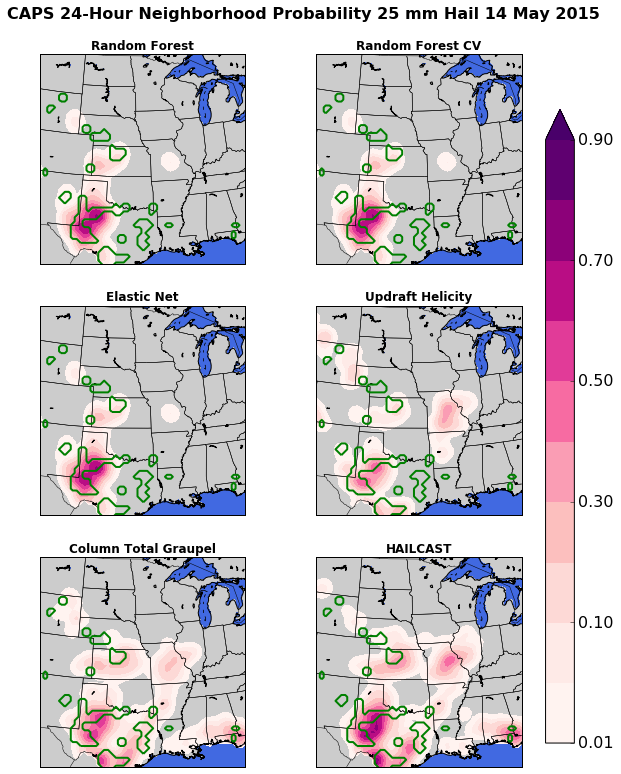

In [6]:
run_date = datetime(2015, 6, 1)
case_thresh = 25
run_dates = pd.DatetimeIndex(start="2015-05-12", end="2015-06-05", freq="1D")
for run_date in run_dates.to_pydatetime():
    data_filename = "/sharp/djgagne/ssef_coarse_neighbor_eval_2015/coarse_neighbor_eval_SSEF_{0}.csv".format(run_date.strftime("%Y%m%d"))
    if exists(data_filename):
        print run_date
        data = pd.read_csv(data_filename)
        ds = (data["i_small"].max() + 1, data["j_small"].max() + 1)
        for case_thresh in [25, 50]:
            mesh = data["MESH_Max_60min_00.50_{0:d}".format(case_thresh)].values.reshape(ds)
            case_models = ["Random-Forest", "Random-Forest-CV", "Elastic-Net", "uh_max", "cqgmax", "hailsz"]
            uh_index = case_models.index("uh_max")
            case_cols = ["SSEF_{0}_mean_{1:d}".format(c, case_thresh) for c in case_models]
            case_cols[uh_index] = case_cols[uh_index].replace(str(case_thresh), str(case_thresh/ 25 * 75))
            case_model_names = ["Random Forest", "Random Forest CV", "Elastic Net", "Updraft Helicity", "Column Total Graupel",
                                "HAILCAST"]
            us_mask = data["us_mask"].values.reshape(ds)
            lat = data["lat"].values.reshape(ds)
            lon = data["lon"].values.reshape(ds)
            bx, by = bmap(lon, lat)
            pmi, pmj = np.where(mesh * us_mask > 0)
            fig, axes = plt.subplots(3,2, figsize=(8, 11), dpi=300)
            plt.subplots_adjust(0.02, 0.02, 0.9, 0.92)
            for a, ax in enumerate(axes.ravel()):
                bmap.drawstates(ax=ax)
                bmap.drawcoastlines(ax=ax)
                bmap.drawcountries(ax=ax)
                bmap.drawlsmask(ocean_color='royalblue',ax=ax)

                co = ax.contourf(bx, by, data[case_cols[a]].values.reshape(ds) * us_mask,
                            [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], extend='max', cmap="RdPu")
                #ax.scatter(bx[pmi, pmj], by[pmi, pmj], 1, 'k')
                ax.contour(bx, by, mesh * us_mask, [0.5], colors='green', linewidths=2)
                ax.set_title(case_model_names[a], fontsize=12, fontweight="bold")
            cbar_ax = fig.add_axes([0.92, 0.05, 0.05, 0.8])
            plt.suptitle("CAPS 24-Hour Neighborhood Probability {0} mm Hail {1}".format(case_thresh, run_date.strftime("%d %B %Y")), 
                         fontsize=16, fontweight="bold",
                        x=0.5)
            cbar = fig.colorbar(co, cax=cbar_ax)
            cbar.ax.tick_params(labelsize=16)
            plt.savefig("/sharp/djgagne/hail_dissertation_figures/caps_coarse_hail_{0}_{1}.pdf".format(case_thresh, run_date.strftime("%Y%m%d")), 
                        bbox_inches="tight")
            plt.close()

In [198]:
run_date = datetime(2015, 6, 1)
case_thresh = 25
run_dates = pd.DatetimeIndex(start="2015-05-27", end="2015-05-28", freq="1D")
for run_date in run_dates.to_pydatetime():
    data_filename = "/sharp/djgagne/ssef_coarse_neighbor_eval_2015/coarse_neighbor_eval_SSEF_{0}.csv".format(run_date.strftime("%Y%m%d"))
    if exists(data_filename):
        print run_date
        data = pd.read_csv(data_filename)
        ds = (data["i_small"].max() + 1, data["j_small"].max() + 1)
        for case_thresh in [25, 50]:
            mesh = data["MESH_Max_60min_00.50_{0:d}".format(case_thresh)].values.reshape(ds)
            case_models = ["Random-Forest", "uh_max", "hailsz"]
            uh_index = case_models.index("uh_max")
            case_cols = ["SSEF_{0}_mean_{1:d}".format(c, case_thresh) for c in case_models]
            case_cols[uh_index] = case_cols[uh_index].replace(str(case_thresh), str(case_thresh/ 25 * 75))
            case_model_names = ["Random Forest", "Updraft Helicity", "HAILCAST"]
            us_mask = data["us_mask"].values.reshape(ds)
            lat = data["lat"].values.reshape(ds)
            lon = data["lon"].values.reshape(ds)
            bx, by = bmap(lon, lat)
            pmi, pmj = np.where(mesh * us_mask > 0)
            fig, axes = plt.subplots(1,3, figsize=(9, 3.5), dpi=300)
            plt.subplots_adjust(0.02, 0.02, 0.92, 0.95)
            for a, ax in enumerate(axes.ravel()):
                bmap.drawstates(ax=ax)
                bmap.drawcoastlines(ax=ax)
                bmap.drawcountries(ax=ax)
                bmap.drawlsmask(ocean_color='royalblue',ax=ax)

                co = ax.contourf(bx, by, data[case_cols[a]].values.reshape(ds) * us_mask,
                            [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], extend='max', cmap="RdPu")
                #ax.scatter(bx[pmi, pmj], by[pmi, pmj], 1, 'k')
                ax.contour(bx, by, mesh * us_mask, [0.5], colors='green', linewidths=2)
                ax.set_title(case_model_names[a], fontsize=12, fontweight="bold")
            cbar_ax = fig.add_axes([0.94, 0.15, 0.03, 0.7])
            plt.suptitle("CAPS 24-Hour Neighborhood Probability {0} mm Hail {1}".format(case_thresh, run_date.strftime("%d %B %Y")), 
                         fontsize=14, fontweight="bold",
                        x=0.5)
            cbar = fig.colorbar(co, cax=cbar_ax)
            cbar.ax.tick_params(labelsize=12)
            plt.savefig("/sharp/djgagne/hail_dissertation_figures/caps_hail_{0}_{1}_preevents.pdf".format(case_thresh, run_date.strftime("%Y%m%d")), 
                        bbox_inches="tight")
            plt.close()

2015-05-27 00:00:00
2015-05-28 00:00:00


2015-05-15 00:00:00
2015-05-19 00:00:00
2015-05-20 00:00:00
2015-05-21 00:00:00
2015-05-22 00:00:00
2015-05-23 00:00:00
2015-05-24 00:00:00
2015-05-25 00:00:00


KeyboardInterrupt: 

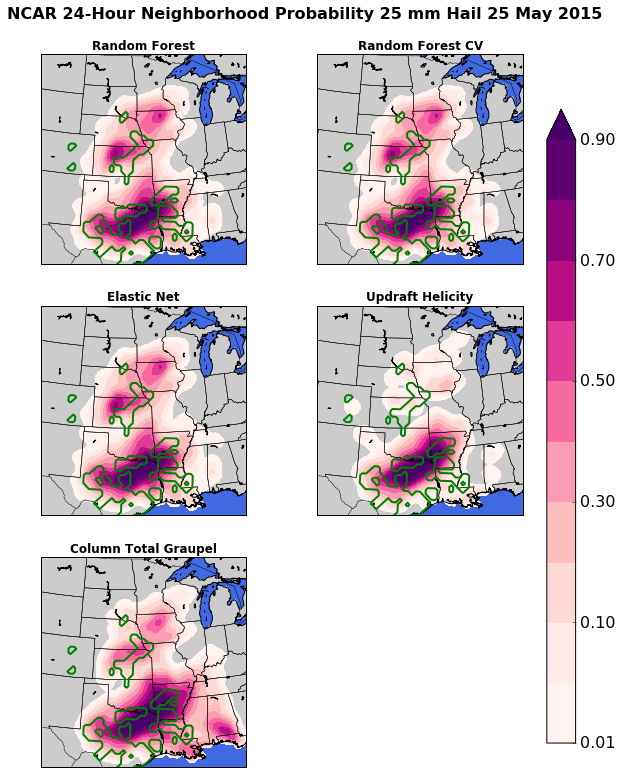

In [243]:
run_dates = pd.DatetimeIndex(start="2015-05-12", end="2015-07-31", freq="1D")
for run_date in run_dates.to_pydatetime():
    data_filename = "/sharp/djgagne/ncar_coarse_neighbor_eval_2015/coarse_neighbor_eval_NCAR_{0}.csv".format(run_date.strftime("%Y%m%d"))
    if exists(data_filename):
        print run_date
        data = pd.read_csv(data_filename)
        ds = (data["i_small"].max() + 1, data["j_small"].max() + 1)
        for case_thresh in [25, 50]:
            mesh = data["MESH_Max_60min_00.50_{0:d}".format(case_thresh)].values.reshape(ds)
            case_models = ["Random-Forest", "Random-Forest-CV", "Elastic-Net", "UP_HELI_MAX", "GRPL_MAX"]
            uh_index = case_models.index("UP_HELI_MAX")
            case_cols = ["NCAR_{0}_mean_{1:d}".format(c, case_thresh) for c in case_models]
            case_cols[uh_index] = case_cols[uh_index].replace(str(case_thresh), str(case_thresh/ 25 * 75))
            case_model_names = ["Random Forest", "Random Forest CV", "Elastic Net", "Updraft Helicity", "Column Total Graupel"]
            us_mask = data["us_mask"].values.reshape(ds)
            lat = data["lat"].values.reshape(ds)
            lon = data["lon"].values.reshape(ds)
            bx, by = bmap(lon, lat)
            pmi, pmj = np.where(mesh * us_mask > 0)
            fig, axes = plt.subplots(3,2, figsize=(8, 11), dpi=300)
            plt.subplots_adjust(0.02, 0.02, 0.9, 0.92)
            for a, ax in enumerate(axes.ravel()[:-1]):
                bmap.drawstates(ax=ax)
                bmap.drawcoastlines(ax=ax)
                bmap.drawcountries(ax=ax)
                bmap.drawlsmask(ocean_color='royalblue',ax=ax)

                co = ax.contourf(bx, by, data[case_cols[a]].values.reshape(ds) * us_mask,
                            [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], extend='max', cmap="RdPu")
                #ax.scatter(bx[pmi, pmj], by[pmi, pmj], 1, 'k')
                ax.contour(bx, by, mesh * us_mask, [0.5], colors='green', linewidths=2)
                ax.set_title(case_model_names[a], fontsize=12, fontweight="bold")
            axes.ravel()[-1].axis('off')
            axes.ravel()[-1].get_xaxis().set_visible(False)
            axes.ravel()[-1].get_yaxis().set_visible(False)
            cbar_ax = fig.add_axes([0.92, 0.05, 0.05, 0.8])
            plt.suptitle("NCAR 24-Hour Neighborhood Probability {0} mm Hail {1}".format(case_thresh, run_date.strftime("%d %B %Y")), 
                         fontsize=16, fontweight="bold",
                        x=0.5)
            cbar = fig.colorbar(co, cax=cbar_ax)
            cbar.ax.tick_params(labelsize=16)
            plt.savefig("/sharp/djgagne/hail_dissertation_figures/ncar_coarse_hail_{0}_{1}.pdf".format(case_thresh, run_date.strftime("%Y%m%d")), 
                        bbox_inches="tight")
            plt.close()

In [122]:
coarse_eval_ncar = pd.concat([pd.read_csv(f, parse_dates=["Run_Date"]) 
                              for f in sorted(glob("/sharp/djgagne/ncar_coarse_neighbor_eval_2015/*.csv"))], ignore_index=True)

In [123]:
coarse_us_eval_ncar = coarse_eval_ncar.loc[coarse_eval_ncar["us_mask"] == 1]

In [107]:
all_fore_vars = us_eval.columns[["SSEF" in var for var in us_eval.columns]]
obs = us_eval["MESH_Max_60min_00.50_50"]
members = ["wrf-s3cn_arw"] + ["wrf-s3m{0:d}_arw".format(m) for m in range(3, 14)] + ["mean"]
fore_vars = ["uh_max", "cqgmax", "hailsz", "r10cmx", "Random-Forest", "Random-Forest-CV", "Elastic-Net"]
#thresh = [75, 25, 25, 60, 25, 25, 25]
thresh = [150, 50, 50, 60, 50, 50, 50]
aucs = pd.DataFrame(np.zeros((len(fore_vars), len(members))), columns=members, index=fore_vars)
rels = pd.DataFrame(np.zeros((len(fore_vars), len(members))), columns=members, index=fore_vars)
for f, fore_var in enumerate(fore_vars):
    for member in members:
        fore = us_eval["SSEF_{0}_{1}_{2:d}".format(fore_var, member, thresh[f])].values
        roc = DistributedROC(thresholds=np.concatenate([[0,0.01, 0.05], np.arange(0.1, 1.1, 0.1)]))
        rel = DistributedReliability(thresholds=np.concatenate([[0,0.01, 0.05], np.arange(0.1, 1.1, 0.1)]))
        roc.update(fore, obs)
        rel.update(fore, obs)
        aucs.loc[fore_var, member] = roc.auc()
        try:
            rels.loc[fore_var, member] = rel.brier_score()
        except ZeroDivisionError:
            rels.loc[fore_var, member] = np.nan

In [158]:
roc_objs = []
rel_objs = []
obs = coarse_us_eval_ncar["MESH_Max_60min_00.50_50"]
#thresh = [75, 25, 25, 25, 25]
thresh = [150, 50, 50, 50, 50]
fore_thresh = np.linspace(0, 1, 20)
fore_vars = ["UP_HELI_MAX", "GRPL_MAX", "Random-Forest", "Random-Forest-CV", "Elastic-Net"]
long_model_names = ["Updraft Helicity", "Column Total Graupel", "Random Forest",
                    "Random Forest CV", "Elastic Net"]
model_name_score = []
model_name_auc = []
model_name_csi = []
aucs_ncar = np.zeros(len(fore_vars))
rels_ncar = np.zeros(len(fore_vars))
for f, fore_var in enumerate(fore_vars):
    print fore_var
    fore = coarse_us_eval_ncar["NCAR_{0}_{1}_{2:d}".format(fore_var, "mean", thresh[f])].values
    rel_objs.append(DistributedReliability(thresholds=fore_thresh))
    roc_objs.append(DistributedROC(thresholds=fore_thresh))
    rel_objs[-1].update(fore, obs)
    roc_objs[-1].update(fore, obs)
    aucs_ncar[f] = roc_objs[-1].auc()
    rels_ncar[f] = rel_objs[-1].brier_score()
    print fore_var, rel_objs[-1].brier_score_components(), roc_objs[-1].auc(), roc_objs[-1].max_csi()
    model_name_score.append(long_model_names[f] + " ({0:0.2f})".format(rel_objs[-1].brier_skill_score()))
    model_name_auc.append(long_model_names[f] + " ({0:0.2f})".format(roc_objs[-1].auc()))
    model_name_csi.append(long_model_names[f] + " ({0:0.2f})".format(roc_objs[-1].max_csi()))
colors = ["red", "blue", "purple", "cyan", "yellow"]
markers = ["*", "*", "v", "v", "v"]
#attributes_diagram(rel_objs, model_name_score, colors, markers, "/sharp/djgagne/hail_dissertation_figures/ncar_mean_hail_rel_25.pdf", 
#                      figsize=(8, 8), xlabel="Forecast Probability",
#                       ylabel="Observed Relative Frequency", ticks=np.arange(0, 1.05, 0.05), dpi=300, 
#                       title="NCAR Ensemble Probability Hail > 25 mm Reliability", legend_params=dict(loc=0, fontsize=10), inset_params=None,
#                       inset_position=(0.1, 0.45, 0.25, 0.25), bootstrap_sets=None, ci=(2.5, 97.5))
#roc_curve(roc_objs, model_name_auc, colors, markers, "/sharp/djgagne/hail_dissertation_figures/ncar_mean_hail_roc_25.pdf",
#          legend_params=dict(loc=0, fontsize=10), title="NCAR Ensemble Probability Hail > 25 mm ROC Curves")
#performance_diagram(roc_objs, model_name_csi, colors, markers, "/sharp/djgagne/hail_dissertation_figures/ncar_mean_hail_perf_25.pdf",
#          legend_params=dict(loc=0, fontsize=10), title="NCAR Ensemble Probability Hail > 25 mm Performance")


UP_HELI_MAX
UP_HELI_MAX (0.000521491837361185, 0.0002549712006570137, 0.006870782395440897) 0.701019610331 0.0850391080047
GRPL_MAX
GRPL_MAX (0.0014766037809730015, 9.272028341917166e-05, 0.006870782395440897) 0.655890715892 0.0439739413681
Random-Forest
Random-Forest (0.001231861607089727, 0.0004395873611612777, 0.006870782395440897) 0.814187430894 0.113884266962
Random-Forest-CV
Random-Forest-CV (0.0010165937413482077, 0.000433004797814518, 0.006870782395440897) 0.806704507911 0.112726098191
Elastic-Net
Elastic-Net (0.00020074754795496014, 0.00037992652680208226, 0.006870782395440897) 0.73085594614 0.110065046217


In [141]:
obs_var = "MESH_Max_60min_00.50_25"
bs_pvalues = np.zeros((len(fore_vars), len(fore_vars)))
print fore_vars
ordering = np.argsort(rels_ncar)
fore_vars = np.array(fore_vars)
thresh = np.array(thresh)
print fore_vars[ordering]
for f, fore_var_a in enumerate(fore_vars[ordering]):
    for g, fore_var_b in enumerate(fore_vars[ordering][f+1:]):
        print fore_var_a, fore_var_b
        fore_var_a_long = "NCAR_{0}_{1}_{2:d}".format(fore_var_a, "mean", thresh[ordering][f])
        fore_var_b_long = "NCAR_{0}_{1}_{2:d}".format(fore_var_b, "mean", thresh[ordering][f+g+1])
        bs_pvalues[f, f+g+1] = permutation_test_bs(coarse_us_eval_ncar, fore_var_b_long, fore_var_a_long, obs_var, 1000) 
        print bs_pvalues[f, f+g+1]

 ['UP_HELI_MAX' 'GRPL_MAX' 'Random-Forest' 'Random-Forest-CV' 'Elastic-Net']
['UP_HELI_MAX' 'Random-Forest-CV' 'Random-Forest' 'Elastic-Net' 'GRPL_MAX']
UP_HELI_MAX Random-Forest-CV
0.0483432133899 0.0471282710403 0.00121494234957
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
-0.000321232130608 0.000241562628804
100.0
UP_HELI_MAX Random-Forest
0.0484210563295 0.0471282710403 0.00129278528913
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
-0.000351294833748 0.000347468162695
100.0
UP_HELI_MAX Elastic-Net
0.0486674952163 0.0471282710403 0.00153922417592
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
-0.000295272643416 0.000227835594741
100.0
UP_HELI_MAX GRPL_MAX
0.0596439153991 0.0471282710403 0.0125156443588
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
-0.000471271396068 0.000382243183922
100.0
Random-Forest-CV Random-Forest
0.0484210563295 0.0483432133899 7.784

In [143]:
obs_var = "MESH_Max_60min_00.50_50"
bs_pvalues = np.zeros((len(fore_vars), len(fore_vars)))
print fore_vars
ordering = np.argsort(rels_ncar)
fore_vars = np.array(fore_vars)
thresh = np.array(thresh)
print fore_vars[ordering]
for f, fore_var_a in enumerate(fore_vars[ordering]):
    for g, fore_var_b in enumerate(fore_vars[ordering][f+1:]):
        print fore_var_a, fore_var_b
        fore_var_a_long = "NCAR_{0}_{1}_{2:d}".format(fore_var_a, "mean", thresh[ordering][f])
        fore_var_b_long = "NCAR_{0}_{1}_{2:d}".format(fore_var_b, "mean", thresh[ordering][f+g+1])
        bs_pvalues[f, f+g+1] = permutation_test_bs(coarse_us_eval_ncar, fore_var_b_long, fore_var_a_long, obs_var, 1000) 
        print bs_pvalues[f, f+g+1]

['UP_HELI_MAX', 'GRPL_MAX', 'Random-Forest', 'Random-Forest-CV', 'Elastic-Net']
['Elastic-Net' 'UP_HELI_MAX' 'Random-Forest-CV' 'Random-Forest' 'GRPL_MAX']
Elastic-Net UP_HELI_MAX
0.00722703306033 0.00675173521903 0.000475297841304
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
-6.76266582358e-05 0.000117739334615
100.0
Elastic-Net Random-Forest-CV
0.00780001584963 0.00675173521903 0.0010482806306
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
-6.59136417991e-05 5.03881927881e-05
100.0
Elastic-Net Random-Forest
0.00806881948459 0.00675173521903 0.00131708426557
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
-7.17509687038e-05 4.54997293077e-05
100.0
Elastic-Net GRPL_MAX
0.00856647092923 0.00675173521903 0.00181473571021
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
-0.000131661440085 0.000100657901161
100.0
UP_HELI_MAX Random-Forest-CV
0.00780001584963 0.00722703

In [152]:
obs_var = "MESH_Max_60min_00.50_25"
auc_pvalues = np.zeros((len(fore_vars), len(fore_vars)))
print fore_vars
ordering = np.argsort(aucs_ncar)[::-1]
fore_vars = np.array(fore_vars)
thresh = np.array(thresh)
print fore_vars[ordering]
for f, fore_var_a in enumerate(fore_vars[ordering]):
    for g, fore_var_b in enumerate(fore_vars[ordering][f+1:]):
        print fore_var_a, fore_var_b
        fore_var_a_long = "NCAR_{0}_{1}_{2:d}".format(fore_var_a, "mean", thresh[ordering][f])
        fore_var_b_long = "NCAR_{0}_{1}_{2:d}".format(fore_var_b, "mean", thresh[ordering][f+g+1])
        auc_pvalues[f, f+g+1] = permutation_test_auc(coarse_us_eval_ncar, fore_var_a_long, fore_var_b_long, obs_var, 1000, 
                                                     np.concatenate([[0,0.01, 0.05], np.arange(0.1, 1.1, 0.1)])) 
        print auc_pvalues[f, f+g+1]

['UP_HELI_MAX' 'GRPL_MAX' 'Random-Forest' 'Random-Forest-CV' 'Elastic-Net']
['Random-Forest' 'Random-Forest-CV' 'Elastic-Net' 'GRPL_MAX' 'UP_HELI_MAX']
Random-Forest Random-Forest-CV
0.000158337469884
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
89.4
Random-Forest Elastic-Net
0.000665371124522
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
Random-Forest GRPL_MAX
0.00772663773748
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
Random-Forest UP_HELI_MAX
0.0790997407855
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
Random-Forest-CV Elastic-Net
0.000507033654637
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
99.9
Random-Forest-CV GRPL_MAX
0.0075683002676
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
Random-Forest-CV UP_HELI_MAX
0.0789414033156
0 50 100 150 200 250 300 350 400 450 

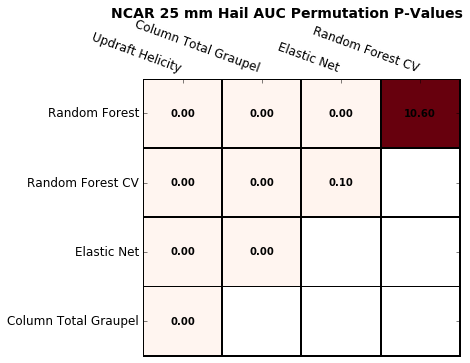

In [157]:
plt.figure(figsize=(5,5))
plt.subplots_adjust(0.1, 0.02, 0.98, 0.79)
long_model_names = np.array(["Updraft Helicity", "Column Total Graupel", "Random Forest", "Random Forest CV", "Elastic Net"])
plt.pcolormesh(np.ma.array(100-auc_pvalues[::-1][:, ::-1], mask=auc_pvalues[::-1][:, ::-1]==0), cmap="Reds", edgecolors='k')
plt.gca().xaxis.tick_top()
plt.yticks(np.arange(5) + 0.5, long_model_names[ordering[::-1]], fontsize=12)
plt.xticks(np.arange(5) + 0.5, long_model_names[ordering[::-1]], rotation=-20, ha="right", fontsize=12)

for (r,c), pv in np.ndenumerate(auc_pvalues[::-1][:, ::-1]):
    if r > c:
        plt.text(c+0.5, r+0.5, "%0.2f" % (100-pv),ha="center", va="center", color="k", fontweight="bold")
plt.xlim(0,4)
plt.ylim(1,5)
plt.suptitle("NCAR 25 mm Hail AUC Permutation P-Values", y=0.99, fontweight="bold", fontsize=14)
plt.savefig("/sharp/djgagne/hail_dissertation_figures/ncar_hail_auc_pvalues_25.pdf", bbox_inches="tight")

In [160]:
obs_var = "MESH_Max_60min_00.50_50"
auc_pvalues = np.zeros((len(fore_vars), len(fore_vars)))
print fore_vars
print aucs_ncar
ordering = np.argsort(aucs_ncar)[::-1]
fore_vars = np.array(fore_vars)
thresh = np.array(thresh)
print fore_vars[ordering]
for f, fore_var_a in enumerate(fore_vars[ordering]):
    for g, fore_var_b in enumerate(fore_vars[ordering][f+1:]):
        print fore_var_a, fore_var_b
        fore_var_a_long = "NCAR_{0}_{1}_{2:d}".format(fore_var_a, "mean", thresh[ordering][f])
        fore_var_b_long = "NCAR_{0}_{1}_{2:d}".format(fore_var_b, "mean", thresh[ordering][f+g+1])
        auc_pvalues[f, f+g+1] = permutation_test_auc(coarse_us_eval_ncar, fore_var_a_long, fore_var_b_long, obs_var, 1000, 
                                                     np.concatenate([[0,0.01, 0.05], np.arange(0.1, 1.1, 0.1)])) 
        print auc_pvalues[f, f+g+1]

 ['UP_HELI_MAX' 'GRPL_MAX' 'Random-Forest' 'Random-Forest-CV' 'Elastic-Net']
[ 0.70101961  0.65589072  0.81418743  0.80670451  0.73085595]
['Random-Forest' 'Random-Forest-CV' 'Elastic-Net' 'UP_HELI_MAX' 'GRPL_MAX']
Random-Forest Random-Forest-CV
0.00559653787934
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
99.7
Random-Forest Elastic-Net
0.0635448108424
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
Random-Forest UP_HELI_MAX
0.0870660605011
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
Random-Forest GRPL_MAX
0.140300964148
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
Random-Forest-CV Elastic-Net
0.0579482729631
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
Random-Forest-CV UP_HELI_MAX
0.0814695226218
0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 
100.0
Random-Forest-CV GRPL_

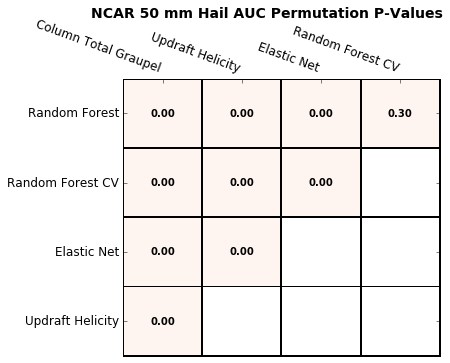

In [163]:
plt.figure(figsize=(5,5))
plt.subplots_adjust(0.1, 0.02, 0.98, 0.79)
long_model_names = np.array(["Updraft Helicity", "Column Total Graupel", "Random Forest", "Random Forest CV", "Elastic Net"])
plt.pcolormesh(np.ma.array(100-auc_pvalues[::-1][:, ::-1], mask=auc_pvalues[::-1][:, ::-1]==0), cmap="Reds", vmin=0, vmax=100, 
               edgecolors='k')
plt.gca().xaxis.tick_top()
plt.yticks(np.arange(5) + 0.5, long_model_names[ordering[::-1]], fontsize=12)
plt.xticks(np.arange(5) + 0.5, long_model_names[ordering[::-1]], rotation=-20, ha="right", fontsize=12)

for (r,c), pv in np.ndenumerate(auc_pvalues[::-1][:, ::-1]):
    if r > c:
        plt.text(c+0.5, r+0.5, "%0.2f" % (100-pv),ha="center", va="center", color="k", fontweight="bold")
plt.xlim(0,4)
plt.ylim(1,5)
plt.suptitle("NCAR 50 mm Hail AUC Permutation P-Values", y=0.99, fontweight="bold", fontsize=14)
plt.savefig("/sharp/djgagne/hail_dissertation_figures/ncar_hail_auc_pvalues_50.pdf", bbox_inches="tight")

In [291]:
roc_objs = []
rel_objs = []
obs = coarse_us_eval_ncar["MESH_Max_60min_00.50_50"]
thresh = [150, 50, 50, 50, 50]
fore_vars = ["UP_HELI_MAX", "GRPL_MAX", "Random-Forest", "Random-Forest-CV", "Elastic-Net"]
long_model_names = ["Updraft Helicity", "Column Total Graupel", "Random Forest",
                    "Random Forest CV", "Elastic Net"]
model_name_score = []
model_name_auc = []
model_name_csi = []
for f, fore_var in enumerate(fore_vars):
    fore = coarse_us_eval_ncar["NCAR_{0}_{1}_{2:d}".format(fore_var, "mean", thresh[f])].values
    rel_objs.append(DistributedReliability(thresholds=fore_thresh))
    roc_objs.append(DistributedROC(thresholds=fore_thresh))
    rel_objs[-1].update(fore, obs)
    roc_objs[-1].update(fore, obs)
    print fore_var, rel_objs[-1].brier_score_components(), roc_objs[-1].auc(), roc_objs[-1].max_csi()
    model_name_score.append(long_model_names[f] + " ({0:0.2f})".format(rel_objs[-1].brier_skill_score()))
    model_name_auc.append(long_model_names[f] + " ({0:0.2f})".format(roc_objs[-1].auc()))
    model_name_csi.append(long_model_names[f] + " ({0:0.2f})".format(roc_objs[-1].max_csi()))
colors = ["red", "blue", "purple", "cyan", "yellow"]
markers = ["*", "*", "v", "v", "v"]
attributes_diagram(rel_objs, model_name_score, colors, markers, "/sharp/djgagne/hail_dissertation_figures/ncar_mean_hail_rel_50.pdf", 
                      figsize=(8, 8), xlabel="Forecast Probability",
                       ylabel="Observed Relative Frequency", ticks=np.arange(0, 1.05, 0.05), dpi=300, 
                       title="NCAR Ensemble Probability Hail > 50 mm Reliability", legend_params=dict(loc=0, fontsize=10), inset_params=None,
                       inset_position=(0.1, 0.45, 0.25, 0.25), bootstrap_sets=None, ci=(2.5, 97.5))
roc_curve(roc_objs, model_name_auc, colors, markers, "/sharp/djgagne/hail_dissertation_figures/ncar_mean_hail_roc_50.pdf",
          legend_params=dict(loc=0, fontsize=10), title="NCAR Ensemble Probability Hail > 50 mm ROC Curves")
performance_diagram(roc_objs, model_name_csi, colors, markers, "/sharp/djgagne/hail_dissertation_figures/ncar_mean_hail_perf_50.pdf",
          legend_params=dict(loc=0, fontsize=10), title="NCAR Ensemble Probability Hail > 50 mm Performance")


UP_HELI_MAX (0.000521491837361185, 0.0002549712006570137, 0.006870782395440897) 0.701019610331 0.0850391080047
GRPL_MAX (0.0014766037809730015, 9.272028341917166e-05, 0.006870782395440897) 0.655890715892 0.0439739413681
Random-Forest (0.001231861607089727, 0.0004395873611612777, 0.006870782395440897) 0.814187430894 0.113884266962
Random-Forest-CV (0.0010165937413482077, 0.000433004797814518, 0.006870782395440897) 0.806704507911 0.112726098191
Elastic-Net (0.00020074754795496014, 0.00037992652680208226, 0.006870782395440897) 0.73085594614 0.110065046217


In [382]:
prob_thresh = 0.1
obs_var = "MESH_Max_60min_00.50_25"
coarse_files = sorted(glob("/sharp/djgagne/ncar_coarse_neighbor_eval_2015/*.csv"))
eval_day = pd.read_csv(coarse_files[0])
grid_shape = (eval_day["i_small"].max() + 1, eval_day["j_small"].max() + 1)
eval_grids = {}
coarse_models = ["NCAR_Random-Forest-CV_mean_25", "NCAR_Elastic-Net_mean_25",
                 "NCAR_UP_HELI_MAX_mean_75", "NCAR_GRPL_MAX_mean_25"]
for model in coarse_models:
    eval_grids[model] = {}
    for grid_type in ["TP", "FP", "FN"]:
        eval_grids[model][grid_type] = np.zeros(grid_shape, dtype=int)
clon = eval_day["lon"].reshape(grid_shape)
clat = eval_day["lat"].reshape(grid_shape)
for f in coarse_files:
    print f
    eval_day = pd.read_csv(f)
    us_mask = eval_day["us_mask"].values
    for model in coarse_models:
        tp_idx = (eval_day[model] * us_mask >= prob_thresh) & (eval_day[obs_var] * us_mask == 1)
        fp_idx = (eval_day[model] * us_mask >= prob_thresh) & (eval_day[obs_var] * us_mask == 0)
        fn_idx = (eval_day[model] * us_mask < prob_thresh) & (eval_day[obs_var] * us_mask == 1)
        eval_grids[model]["TP"][eval_day["i_small"][tp_idx].values, eval_day["j_small"][tp_idx].values] += 1
        eval_grids[model]["FP"][eval_day["i_small"][fp_idx].values, eval_day["j_small"][fp_idx].values] += 1
        eval_grids[model]["FN"][eval_day["i_small"][fn_idx].values, eval_day["j_small"][fn_idx].values] += 1

/sharp/djgagne/ncar_coarse_neighbor_eval_2015/coarse_neighbor_eval_NCAR_20150515.csv
/sharp/djgagne/ncar_coarse_neighbor_eval_2015/coarse_neighbor_eval_NCAR_20150519.csv
/sharp/djgagne/ncar_coarse_neighbor_eval_2015/coarse_neighbor_eval_NCAR_20150520.csv
/sharp/djgagne/ncar_coarse_neighbor_eval_2015/coarse_neighbor_eval_NCAR_20150521.csv
/sharp/djgagne/ncar_coarse_neighbor_eval_2015/coarse_neighbor_eval_NCAR_20150522.csv
/sharp/djgagne/ncar_coarse_neighbor_eval_2015/coarse_neighbor_eval_NCAR_20150523.csv
/sharp/djgagne/ncar_coarse_neighbor_eval_2015/coarse_neighbor_eval_NCAR_20150524.csv
/sharp/djgagne/ncar_coarse_neighbor_eval_2015/coarse_neighbor_eval_NCAR_20150525.csv
/sharp/djgagne/ncar_coarse_neighbor_eval_2015/coarse_neighbor_eval_NCAR_20150526.csv
/sharp/djgagne/ncar_coarse_neighbor_eval_2015/coarse_neighbor_eval_NCAR_20150527.csv
/sharp/djgagne/ncar_coarse_neighbor_eval_2015/coarse_neighbor_eval_NCAR_20150528.csv
/sharp/djgagne/ncar_coarse_neighbor_eval_2015/coarse_neighbor_eva

1150.0 973
1152.0 973
1194.0 973
1110.0 973


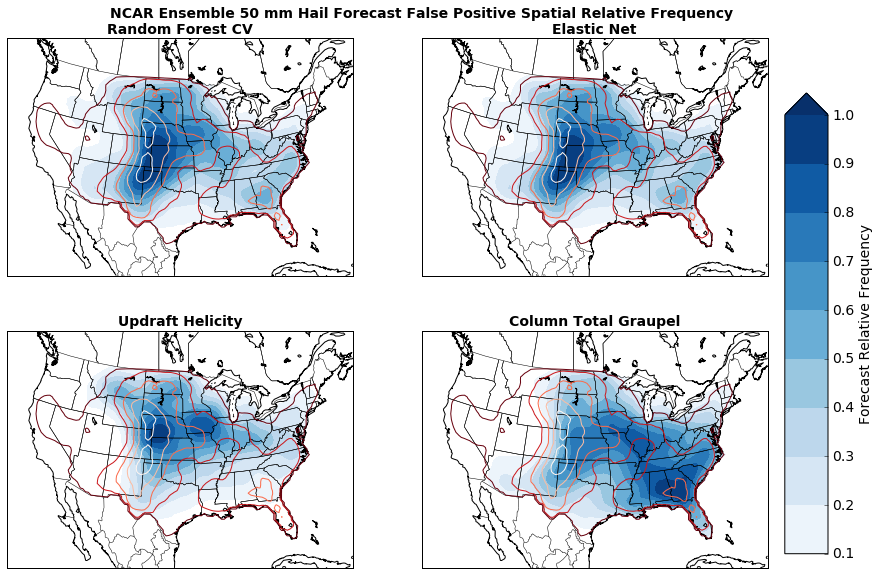

In [383]:
from scipy.ndimage import convolve
from skimage.morphology import disk
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(0.02, 0.02, 0.9, 0.95)
disk_area = disk(5)
cx, cy = bmap_full(clon, clat)
long_coarse_model_names = ["Random Forest CV", "Elastic Net", "Updraft Helicity", "Column Total Graupel"]
us_mask_grid = us_mask.reshape(grid_shape)
for m, model in enumerate(coarse_models):
    plt.subplot(2, 2, m + 1)
    tp_conv = convolve(eval_grids[model]["TP"], disk_area) * us_mask_grid
    fn_conv = convolve(eval_grids[model]["FN"], disk_area) * us_mask_grid
    fp_conv = convolve(eval_grids[model]["FP"], disk_area) * us_mask_grid
    fore_conv = convolve(eval_grids[model]["TP"] + eval_grids[model]["FP"], disk_area) * us_mask_grid
    obs_conv = convolve(eval_grids[model]["TP"] + eval_grids[model]["FN"], disk_area) * us_mask_grid
    csi_conv = tp_conv.astype(float) / (tp_conv + fp_conv)
    #plt.pcolormesh(np.ma.array(csi_conv, mask=(csi_conv==0) | np.isnan(csi_conv)) , vmin=0, vmax=0.5, cmap="viridis")
    bmap_full.drawstates()
    bmap_full.drawcoastlines()
    bmap_full.drawcountries()
    #plt.pcolormesh(cx, cy, np.ma.array(csi_conv, mask=(csi_conv==0) | np.isnan(csi_conv)),vmin=0, vmax=0.3, cmap="Blues")
    #plt.contourf(cx, cy, fn_conv, cmap="Blues")
    max_val = float(tp_conv.max() + fn_conv.max())
    print max_val, obs_conv.max()
    cf = plt.contourf(cx, cy, fp_conv / float(fp_conv.max()), np.arange(0.1, 1.1, 0.1), extend="max", cmap="Blues")
    co = plt.contour(cx, cy, obs_conv / float(obs_conv.max()), np.arange(0.1, 1.1, 0.2), extend="max", cmap="Reds_r")

    #co = plt.contourf(cx, cy, csi_conv * us_mask.reshape(grid_shape), np.arange(0.1, 0.55, 0.05), 
    #                  extend="max", cmap="Blues")
    plt.title(long_coarse_model_names[m], fontsize=14, fontweight="bold")
fig.suptitle("NCAR Ensemble 50 mm Hail Forecast False Positive Spatial Relative Frequency", fontsize=14, fontweight="bold", y=1)
cbar_ax = fig.add_axes([0.92, 0.05, 0.05, 0.8])
cbar = fig.colorbar(cf, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel("Forecast Relative Frequency", fontsize=14)
plt.savefig("/sharp/djgagne/hail_dissertation_figures/ncar_spatial_fp_25.pdf", bbox_inches="tight")

339.0 338
345.0 338
357.0 338
366.0 338


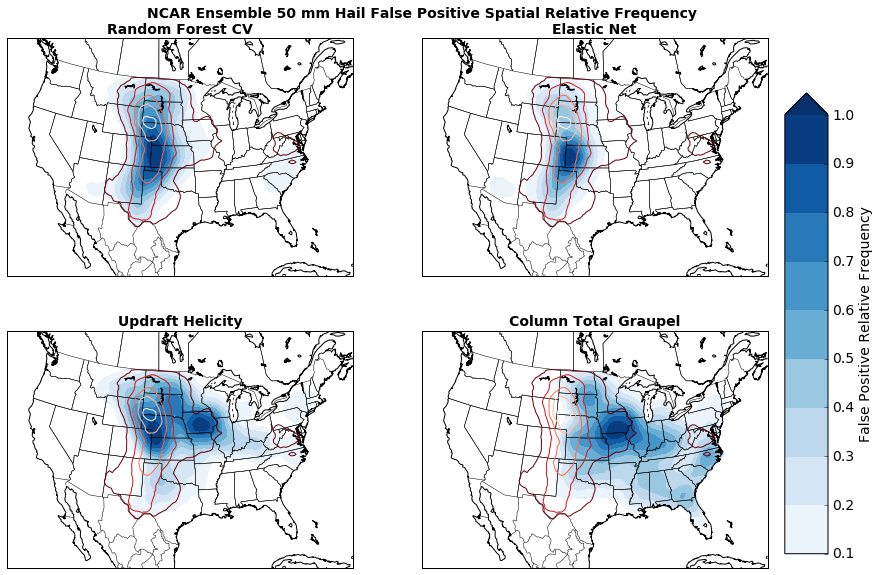

In [357]:
from scipy.ndimage import convolve
from skimage.morphology import disk
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(0.02, 0.02, 0.9, 0.95)
disk_area = disk(5)
cx, cy = bmap_full(clon, clat)
long_coarse_model_names = ["Random Forest CV", "Elastic Net", "Updraft Helicity", "Column Total Graupel"]
us_mask_grid = us_mask.reshape(grid_shape)
for m, model in enumerate(coarse_models):
    plt.subplot(2, 2, m + 1)
    tp_conv = convolve(eval_grids[model]["TP"], disk_area) * us_mask_grid
    fn_conv = convolve(eval_grids[model]["FN"], disk_area) * us_mask_grid
    fp_conv = convolve(eval_grids[model]["FP"], disk_area) * us_mask_grid
    fore_conv = convolve(eval_grids[model]["TP"] + eval_grids[model]["FP"], disk_area) * us_mask_grid
    obs_conv = convolve(eval_grids[model]["TP"] + eval_grids[model]["FN"], disk_area) * us_mask_grid
    csi_conv = tp_conv.astype(float) / (tp_conv + fp_conv)
    #plt.pcolormesh(np.ma.array(csi_conv, mask=(csi_conv==0) | np.isnan(csi_conv)) , vmin=0, vmax=0.5, cmap="viridis")
    bmap_full.drawstates()
    bmap_full.drawcoastlines()
    bmap_full.drawcountries()
    #plt.pcolormesh(cx, cy, np.ma.array(csi_conv, mask=(csi_conv==0) | np.isnan(csi_conv)),vmin=0, vmax=0.3, cmap="Blues")
    #plt.contourf(cx, cy, fn_conv, cmap="Blues")
    max_val = float(tp_conv.max() + fn_conv.max())
    print max_val, obs_conv.max()
    cf = plt.contourf(cx, cy, fp_conv / float(fp_conv.max()), np.arange(0.1, 1.1, 0.1), extend="max", cmap="Blues")
    co = plt.contour(cx, cy, obs_conv / float(obs_conv.max()), np.arange(0.1, 1.1, 0.2), extend="max", cmap="Reds_r")

    #co = plt.contourf(cx, cy, csi_conv * us_mask.reshape(grid_shape), np.arange(0.1, 0.55, 0.05), 
    #                  extend="max", cmap="Blues")
    plt.title(long_coarse_model_names[m], fontsize=14, fontweight="bold")
fig.suptitle("NCAR Ensemble 50 mm Hail False Positive Spatial Relative Frequency", fontsize=14, fontweight="bold", y=1)
cbar_ax = fig.add_axes([0.92, 0.05, 0.05, 0.8])
cbar = fig.colorbar(cf, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel("False Positive Relative Frequency", fontsize=14)
plt.savefig("/sharp/djgagne/hail_dissertation_figures/ncar_spatial_fp_50.pdf", bbox_inches="tight")

In [164]:
n_boot = 1000
num_obs = len(obs)
#rand_idx = np.random.randint(0, len(obs), (n_boot, len(obs)))
#ncar_boot_obs = obs.values[rand_idx]
ncar_boot_aucs = np.zeros((len(fore_vars), n_boot))
ncar_boot_bss = np.zeros((len(fore_vars), n_boot))
fore_thresh = np.linspace(0, 1, 20)
roc_obj = DistributedROC(thresholds=fore_thresh)
rel_obj = DistributedReliability(thresholds=fore_thresh)
for b in range(n_boot):
    if b % 100 == 0:
        print b
    rand_idx = np.random.randint(0, num_obs, num_obs)
    ncar_boot_obs = obs.values[rand_idx]
    for f, fore_var in enumerate(fore_vars):
        ncar_fore = coarse_us_eval_ncar["NCAR_{0}_{1}_{2:d}".format(fore_var, "mean", thresh[f])].values
        ncar_boot_fore = ncar_fore[rand_idx]
        roc_obj.update(ncar_boot_fore, ncar_boot_obs)
        rel_obj.update(ncar_boot_fore, ncar_boot_obs)
        ncar_boot_aucs[f, b] = roc_obj.auc()
        ncar_boot_bss[f, b] = rel_obj.brier_skill_score()
        roc_obj.contingency_tables.loc[:, :] = 0
        rel_obj.frequencies.loc[:, :] = 0

0
100
200
300
400
500
600
700
800
900


In [15]:


#sample_auc_diffs, sample_bs_diffs, auc_diff, bs_diff = permutation_test(coarse_us_eval_ncar, "NCAR_Random-Forest-CV_mean_25", "NCAR_Elastic-Net_mean_25", 
#                       "MESH_Max_60min_00.50_25", 1000, np.concatenate([[0.01, 0.05], np.arange(0.1, 1.1, 0.1)]))

In [14]:
permutation_test(us_eval, "SSEF_Random-Forest-CV_mean_50", "SSEF_Random-Forest_mean_50",
                "MESH_Max_60min_00.50_50", 100, np.concatenate([[0.01, 0.05], np.arange(0.1, 1.1, 0.1)]))

0.0015094662666
-0.000795891311406
0
50
100.0 9.0
-0.00108146175035 0.00109966254198
-0.00148549203955 0.00120548771698


In [403]:
percentileofscore(sample_bs_diffs, bs_diff)

0.0

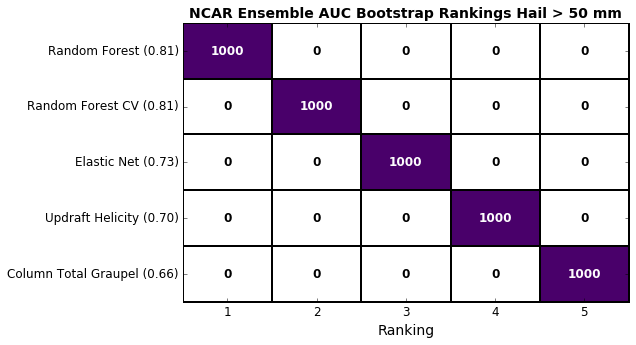

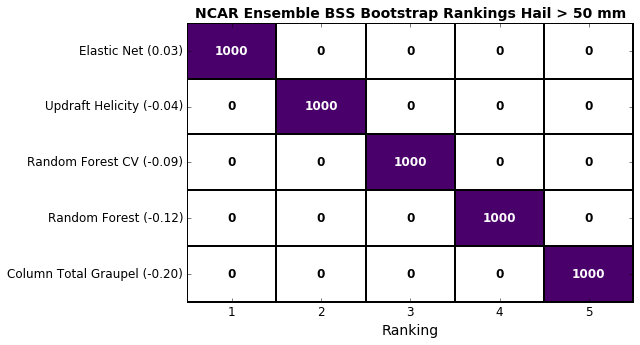

In [168]:
boot_rank_table(ncar_boot_aucs, long_model_names, "NCAR Ensemble AUC Bootstrap Rankings Hail > 50 mm", 
                "/sharp/djgagne/hail_dissertation_figures/ncar_boot_auc_rank_50.pdf")
boot_rank_table(ncar_boot_bss, long_model_names, "NCAR Ensemble BSS Bootstrap Rankings Hail > 50 mm", 
                "/sharp/djgagne/hail_dissertation_figures/ncar_boot_bss_rank_50.pdf")

In [546]:
%timeit len(obs)

The slowest run took 15.96 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 2.26 µs per loop


In [551]:
np.__version__

'1.10.4'

In [25]:
obs_files = sorted(glob("/sharp/djgagne/track_data_spring2015_cqg_closest_csv/track_step_SSEF_wrf-s3cn_arw_*.csv"))
obs_data = pd.concat([pd.read_csv(obs_file) for obs_file in obs_files], ignore_index=True)
obs_data_pos = obs_data.loc[obs_data["Hail_Size"] > 0]

(array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
         3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9]),
 array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
          4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
          9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
         18. ,  18.5,  19. ,  19.5,  20. ,  20.5]),
 <matplotlib.image.AxesImage at 0x2ba6bd52add0>)

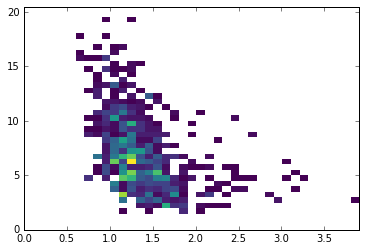

In [30]:

plt.hist2d(obs_data_pos["Shape"], obs_data_pos["Scale"], (np.arange(0, 4, 0.1), np.arange(0, 21, 0.5)), cmin=1, 
           cmap="viridis")

(array([ 120.,  775.,  434.,  101.,   25.,   12.,    8.,    2.,    1.,    1.]),
 array([ 0.59745,  0.96259,  1.32773,  1.69287,  2.05801,  2.42315,
         2.78829,  3.15343,  3.51857,  3.88371,  4.24885]),
 <a list of 10 Patch objects>)

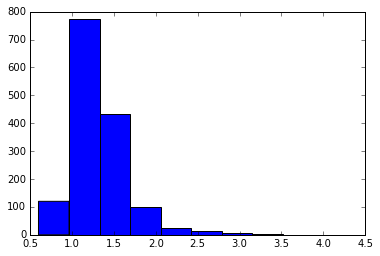

In [33]:
plt.hist(obs_data_pos["Shape"])

In [64]:
import json
from scipy.stats import gamma
obs_files_json = sorted(glob("/sharp/djgagne/track_data_spring2015_cqg_masked_json/2015*/wrf-s3cn_arw/mesh*.json"))
all_obs_params = []
for obs_file in obs_files_json:
    json_file = open(obs_file)
    obs_obj = json.load(json_file)
    json_file.close()
    for step in obs_obj['features']:
        vals = np.array(step['properties']['timesteps'])
        mask = np.array(step['properties']['masks'])
        masked_vals = vals.ravel()[mask.ravel() == 1]
        params = gamma.fit(masked_vals, floc=masked_vals.min()-0.1)
        all_obs_params.append(params)

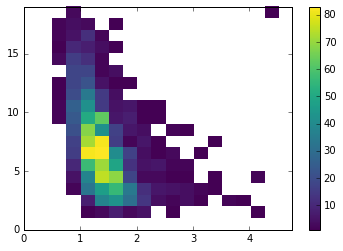

In [69]:
obs_param_arr = np.array(all_obs_params)
plt.hist2d(obs_param_arr[:,0], obs_param_arr[:, 2], (np.arange(0, 5, 0.25), np.arange(0, 20, 1)), 
          cmap="viridis", cmin=1)
plt.colorbar()

(0.0, 1.0, 0.0, 1.0)

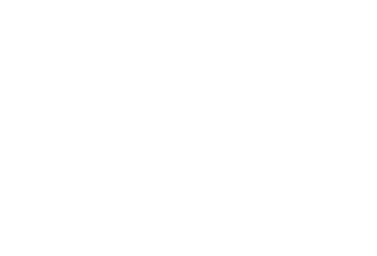

In [72]:
fig, ax = plt.subplots()
ax.axis('off')

In [146]:
mem_2016 = ["wrf-core01_arw"] + ["wrf-core{0:02d}_arw".format(x) for x in range(3, 11)]
n_probs_thomp_25 = []
n_probs_thomp_50 = []
for mem in mem_2016:
    mo = ModelOutput("SSEF", mem, datetime(2016,5,16), "hailk1", datetime(2016,5,16,13), 
                     datetime(2016,5,17,12), "/sharp/djgagne/spring2016_nc/")
    mo.load_data()
    mo.load_map_info("/home/djgagne/hagelslag/mapfiles/ssef2015.map")
    n_probs_thomp_25.append(mo.period_neighborhood_probability(42, 1, 25, 14))
    n_probs_thomp_50.append(mo.period_neighborhood_probability(42, 1, 50, 14))

hailk1 2204
Exceed points 379
hailk1 667
Exceed points 95
hailk1 10246
Exceed points 1400
hailk1 0
hailk1 58122
Exceed points 4044
hailk1 2929
Exceed points 913
hailk1 15999
Exceed points 1605
hailk1 0
hailk1 12421
Exceed points 1430
hailk1 0
hailk1 63639
Exceed points 3937
hailk1 5015
Exceed points 906
hailk1 11802
Exceed points 1219
hailk1 0
hailk1 18470
Exceed points 1855
hailk1 0
hailk1 2969
Exceed points 343
hailk1 980
Exceed points 107


hailk1 1149
Exceed points 246


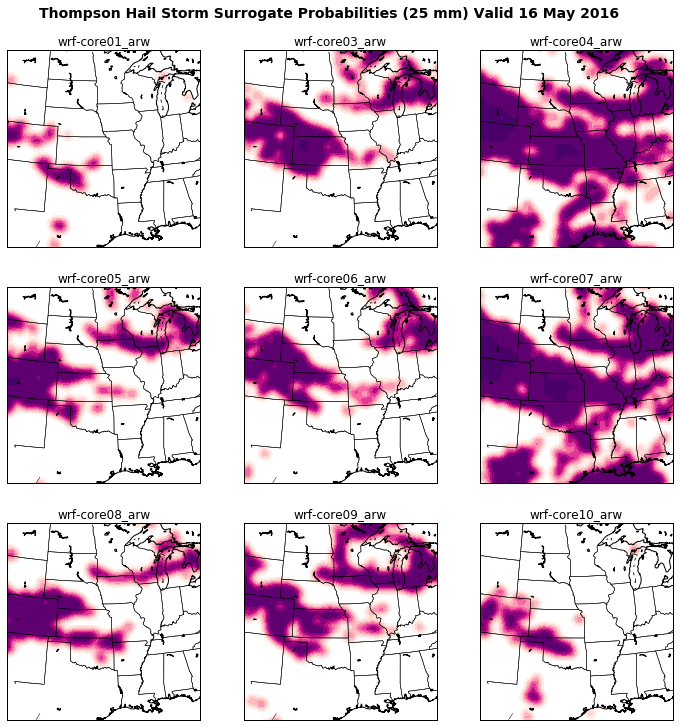

In [156]:
bxs, bys = bmap(mo.lon[::14, ::14], mo.lat[::14, ::14])
plt.figure(figsize=(12, 12))
for m, mem in enumerate(mem_2016):
    plt.subplot(3, 3, m+1)
    bmap.drawstates()
    bmap.drawcoastlines()
    plt.title(mem)
    plt.contourf(bxs, bys, n_probs_thomp_25[m], np.arange(0.1, 1.1, 0.1), cmap="RdPu", extend="max")
plt.suptitle("Thompson Hail Storm Surrogate Probabilities (25 mm) Valid 16 May 2016", fontsize=14, fontweight="bold",
            y=0.95)
    #plt.colorbar(shrink=0.7)

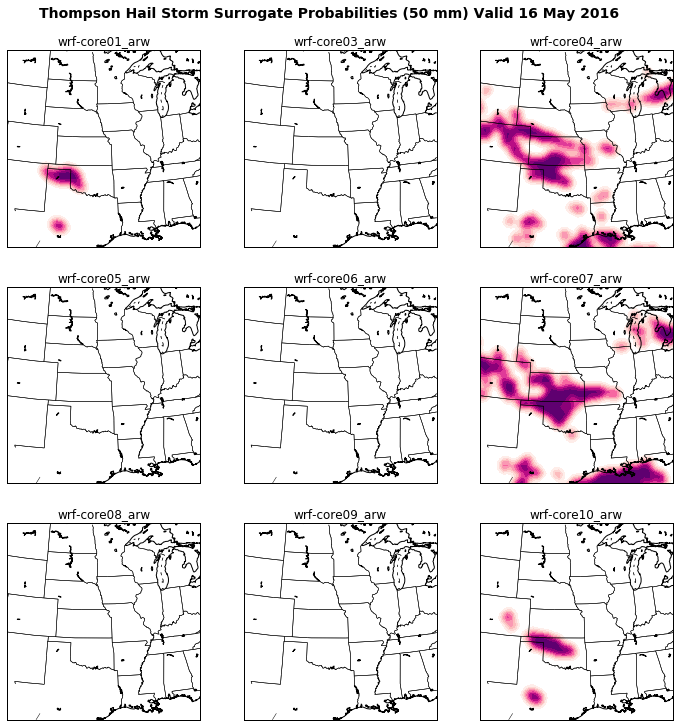

In [150]:
bxs, bys = bmap(mo.lon[::14, ::14], mo.lat[::14, ::14])
plt.figure(figsize=(12, 12))
for m, mem in enumerate(mem_2016):
    plt.subplot(3, 3, m+1)
    bmap.drawstates()
    bmap.drawcoastlines()
    plt.title(mem)
    plt.contourf(bxs, bys, n_probs_thomp_50[m], np.arange(0.1, 1.1, 0.1), cmap="RdPu", extend="max")
plt.suptitle("Thompson Hail Storm Surrogate Probabilities (50 mm) Valid 16 May 2016", fontsize=14, fontweight="bold",
            y=0.95)
    #plt.colorbar(shrink=0.7)

In [102]:
hailcast = ModelOutput("SSEF", "wrf-core01_arw", datetime(2016,5,26), "hailsz", datetime(2016,5,26,13), 
                 datetime(2016,5,27,12), "/sharp/djgagne/spring2016_nc/")
hailcast.load_data()
hailcast.load_map_info("/home/djgagne/hagelslag/mapfiles/ssef2015.map")
nprob_hc = hailcast.period_neighborhood_probability(42, 1, 50, 14)

hailsz 529
Exceed points 215


In [151]:
mem_2016 = ["wrf-core01_arw"] + ["wrf-core{0:02d}_arw".format(x) for x in range(3, 11)]
n_probs_hc_25 = []
n_probs_hc_50 = []
for mem in mem_2016:
    mo = ModelOutput("SSEF", mem, datetime(2016,5,16), "hailsz", datetime(2016,5,16,13), 
                     datetime(2016,5,17,12), "/sharp/djgagne/spring2016_nc/")
    mo.load_data()
    mo.load_map_info("/home/djgagne/hagelslag/mapfiles/ssef2015.map")
    n_probs_hc_25.append(mo.period_neighborhood_probability(42, 1, 25, 14))
    n_probs_hc_50.append(mo.period_neighborhood_probability(42, 1, 50, 14))

hailsz 1571
Exceed points 324
hailsz 5
Exceed points 7
hailsz 1046
Exceed points 210
hailsz 7
Exceed points 14
hailsz 147
Exceed points 40
hailsz 0
hailsz 33
Exceed points 29
hailsz 0
hailsz 633
Exceed points 188
hailsz 3
Exceed points 7
hailsz 429
Exceed points 28
hailsz 0
hailsz 1
Exceed points 3
hailsz 0
hailsz 561
Exceed points 151
hailsz 13
Exceed points 12
hailsz 1597
Exceed points 277
hailsz 20
Exceed points 19


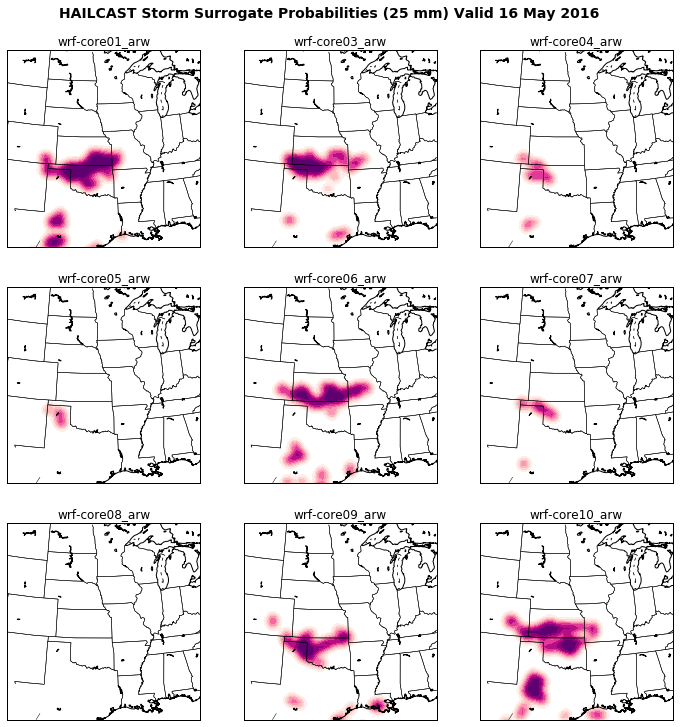

In [155]:
bxs, bys = bmap(mo.lon[::14, ::14], mo.lat[::14, ::14])
plt.figure(figsize=(12, 12))
for m, mem in enumerate(mem_2016):
    plt.subplot(3, 3, m+1)
    bmap.drawstates()
    bmap.drawcoastlines()
    plt.title(mem)
    plt.contourf(bxs, bys, n_probs_hc_25[m], np.arange(0.1, 1.1, 0.1), cmap="RdPu", extend="max")
plt.suptitle("HAILCAST Storm Surrogate Probabilities (25 mm) Valid 16 May 2016", fontsize=14, fontweight="bold",
            y=0.95)

In [153]:
mem_2016 = ["wrf-core01_arw"] + ["wrf-core{0:02d}_arw".format(x) for x in range(3, 11)]
n_probs_ml_25 = []
n_probs_ml_50 = []
for mem in mem_2016:
    mo = HailForecastGrid(datetime(2016,5,16), datetime(2016,5,16,13), 
                     datetime(2016,5,17,12), "SSEF", "Random-Forest-CV", [mem], "hail", 2, 
                          "/sharp/djgagne/hail_forecasts_grib2_ssef_cqg_closest_2016/")
    mo.load_data()
    n_probs_ml_25.append(mo.period_neighborhood_probability(42, 1, 25, 14))
    n_probs_ml_50.append(mo.period_neighborhood_probability(42, 1, 50, 14))

(0, 480)
(0, 31)
(0, 464)
(0, 22)
(0, 564)
(0, 45)
(0, 769)
(0, 48)
(0, 416)
(0, 20)
(0, 648)
(0, 54)
(0, 676)
(0, 38)
(0, 355)
(0, 17)
(0, 992)
(0, 68)


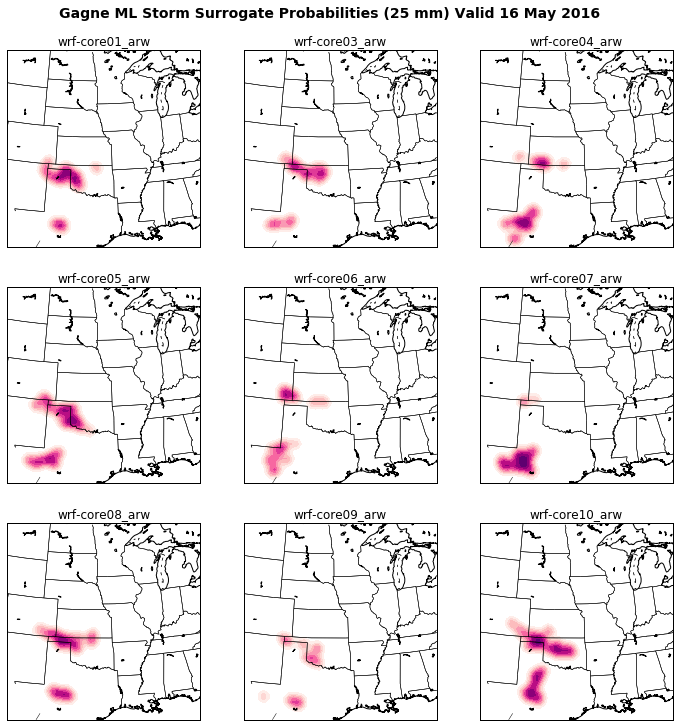

In [157]:
bxs, bys = bmap(mo.lon[::14, ::14], mo.lat[::14, ::14])
plt.figure(figsize=(12, 12))
for m, mem in enumerate(mem_2016):
    plt.subplot(3, 3, m+1)
    bmap.drawstates()
    bmap.drawcoastlines()
    plt.title(mem)
    plt.contourf(bxs, bys, n_probs_ml_50[m][0], np.arange(0.1, 1.1, 0.1), cmap="RdPu", extend="max")
plt.suptitle("Gagne ML Storm Surrogate Probabilities (25 mm) Valid 16 May 2016", fontsize=14, fontweight="bold",
            y=0.95)

NameError: name 'combined_stats' is not defined